# dAMN with E. coli and P. putida dataset

In [1]:
# check environment should be:
"""
Python version: 3.10.18
TF version: 2.16.2
Keras version: 3.9.2
NumPy version: 1.23.5
CobraPy version: 0.29.1
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
import utils
import data
import model
import plot
import sys
import cobra

print("Python version:", sys.version)
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("NumPy version:", np.__version__)
print("CobraPy version:", cobra.__version__)
print("Executable:", sys.executable)
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))

Python version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:46:00) [Clang 18.1.8 ]
TF version: 2.16.2
Keras version: 3.9.2
NumPy version: 1.23.5
CobraPy version: 0.29.1
Executable: /Users/jean-loup-faulon/miniforge3/envs/M4/bin/python
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Train

In [ ]:
# E. coli
# Cell is slow you may past the cell in python code
# If you run this cell you will looses the models stored in folder model/

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
import utils
import data
import model
import plot
import sys

train_test_split = 'forecast' # 'forecast' or 'medium'
folder = './'
file_name = 'M28_OD_20'
media_file = folder+'data/'+'M28_media.csv'                 
od_file = folder+'data/'+file_name+'.csv'               
cobra_model_file = folder+'data/'+'iML1515_duplicated.xml'
biomass_rxn_id = 'BIOMASS_Ec_iML1515_core_75p37M'

# Hyperparameters
seed = 30
np.random.seed(seed=seed)
hidden_layers_lag = [50]
hidden_layers_flux = [500]
num_epochs = 1000
x_fold = 3    
batch_size = 10
patience = 100
N_iter = 3
run_name = f'{file_name}_{train_test_split}'

# Create model
mdl, train_array, train_dev, val_array, val_dev, val_ids = model.create_model_train_val(
    media_file, od_file,
    cobra_model_file,
    biomass_rxn_id,
    x_fold=x_fold, 
    hidden_layers_lag=hidden_layers_lag, 
    hidden_layers_flux=hidden_layers_flux, 
    dropout_rate=0.2,
    #lag_function='hill',
    loss_weight=[0.1, 1, 1, 1], # SV, negV, C, dropC
    loss_decay=[ 0,   1, 0, 0],
    verbose=False,
    train_test_split=train_test_split
)

# Saving for future testing and validation
np.savetxt(f'{folder}model/{run_name}_val_array.txt', val_array, fmt='%f')
np.savetxt(f'{folder}model/{run_name}_val_dev.txt', val_dev, fmt='%f')
np.savetxt(f'{folder}model/{run_name}_val_ids.txt', np.asarray(val_ids), fmt='%d')

# pretrain
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=280,
        decay_rate=0.9,
        staircase=True
    )
(
    (losses_s_v_train, losses_neg_v_train, losses_c_train, losses_drop_c_train),
    (losses_s_v_val, losses_neg_v_val, losses_c_val, losses_drop_c_val)
) = model.train_model(
        mdl, train_array, val_array=val_array,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        num_epochs=num_epochs, batch_size=batch_size, patience=patience,
        verbose=True,
        train_test_split=train_test_split,
        x_fold=x_fold
    )

# Train model
for i in range(N_iter):
    (
        (losses_s_v_train, losses_neg_v_train, losses_c_train, losses_drop_c_train),
        (losses_s_v_val, losses_neg_v_val, losses_c_val, losses_drop_c_val)
    ) = model.train_model(
        mdl, train_array, val_array=val_array,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        num_epochs=num_epochs, batch_size=batch_size, patience=patience,
        verbose=True,
        train_test_split=train_test_split,
        x_fold=x_fold
    )
    mdl_name = f'{folder}model/{run_name}_{str(i)}'
    mdl.save_model(model_name=mdl_name, verbose=True)


# Plot last run
plot.plot_loss('Training S_v', losses_s_v_train, num_epochs, save="./figure")
plot.plot_loss('Training Neg_v', losses_neg_v_train, num_epochs, save="./figure")
plot.plot_loss('Training C', losses_c_train, num_epochs, save="./figure")
plot.plot_loss('Training Drop_c', losses_drop_c_train, num_epochs, save="./figure")

if x_fold > 1:
    plot.plot_loss('Validation S_v', losses_s_v_val, num_epochs, save="./figure")
    plot.plot_loss('Validation Neg_v', losses_neg_v_val, num_epochs, save="./figure")
    plot.plot_loss('Validation C', losses_c_val, num_epochs, save="./figure")
    plot.plot_loss('Validation Drop_c', losses_drop_c_val, num_epochs, save="./figure")


[process_data] detected OD mode (M28-style OD + DEV)
Transport[28,236] = 1.0  BIOMASS
Transport[25,3105] = -1.0  EX_csn_e_i csn_e
Transport[7,3110] = -1.0  EX_cys__L_e_i cys__L_e
Transport[0,3145] = -1.0  EX_glc__D_e_i glc__D_e
Transport[9,3149] = -1.0  EX_gln__L_e_i gln__L_e
Transport[8,3150] = -1.0  EX_glu__L_e_i glu__L_e
Transport[10,3152] = -1.0  EX_gly_e_i gly_e
Transport[24,3165] = -1.0  EX_gua_e_i gua_e
Transport[11,3178] = -1.0  EX_his__L_e_i his__L_e
Transport[12,3186] = -1.0  EX_ile__L_e_i ile__L_e
Transport[13,3195] = -1.0  EX_leu__L_e_i leu__L_e
Transport[14,3200] = -1.0  EX_lys__L_e_i lys__L_e
Transport[15,3208] = -1.0  EX_met__L_e_i met__L_e
Transport[16,3241] = -1.0  EX_phe__L_e_i phe__L_e
Transport[17,3260] = -1.0  EX_pro__L_e_i pro__L_e
Transport[18,3274] = -1.0  EX_ser__L_e_i ser__L_e
Transport[2,3281] = -1.0  EX_succ_e_i succ_e
Transport[19,3289] = -1.0  EX_thr__L_e_i thr__L_e
Transport[20,3294] = -1.0  EX_trp__L_e_i trp__L_e
Transport[21,3301] = -1.0  EX_tyr__L_e_i 

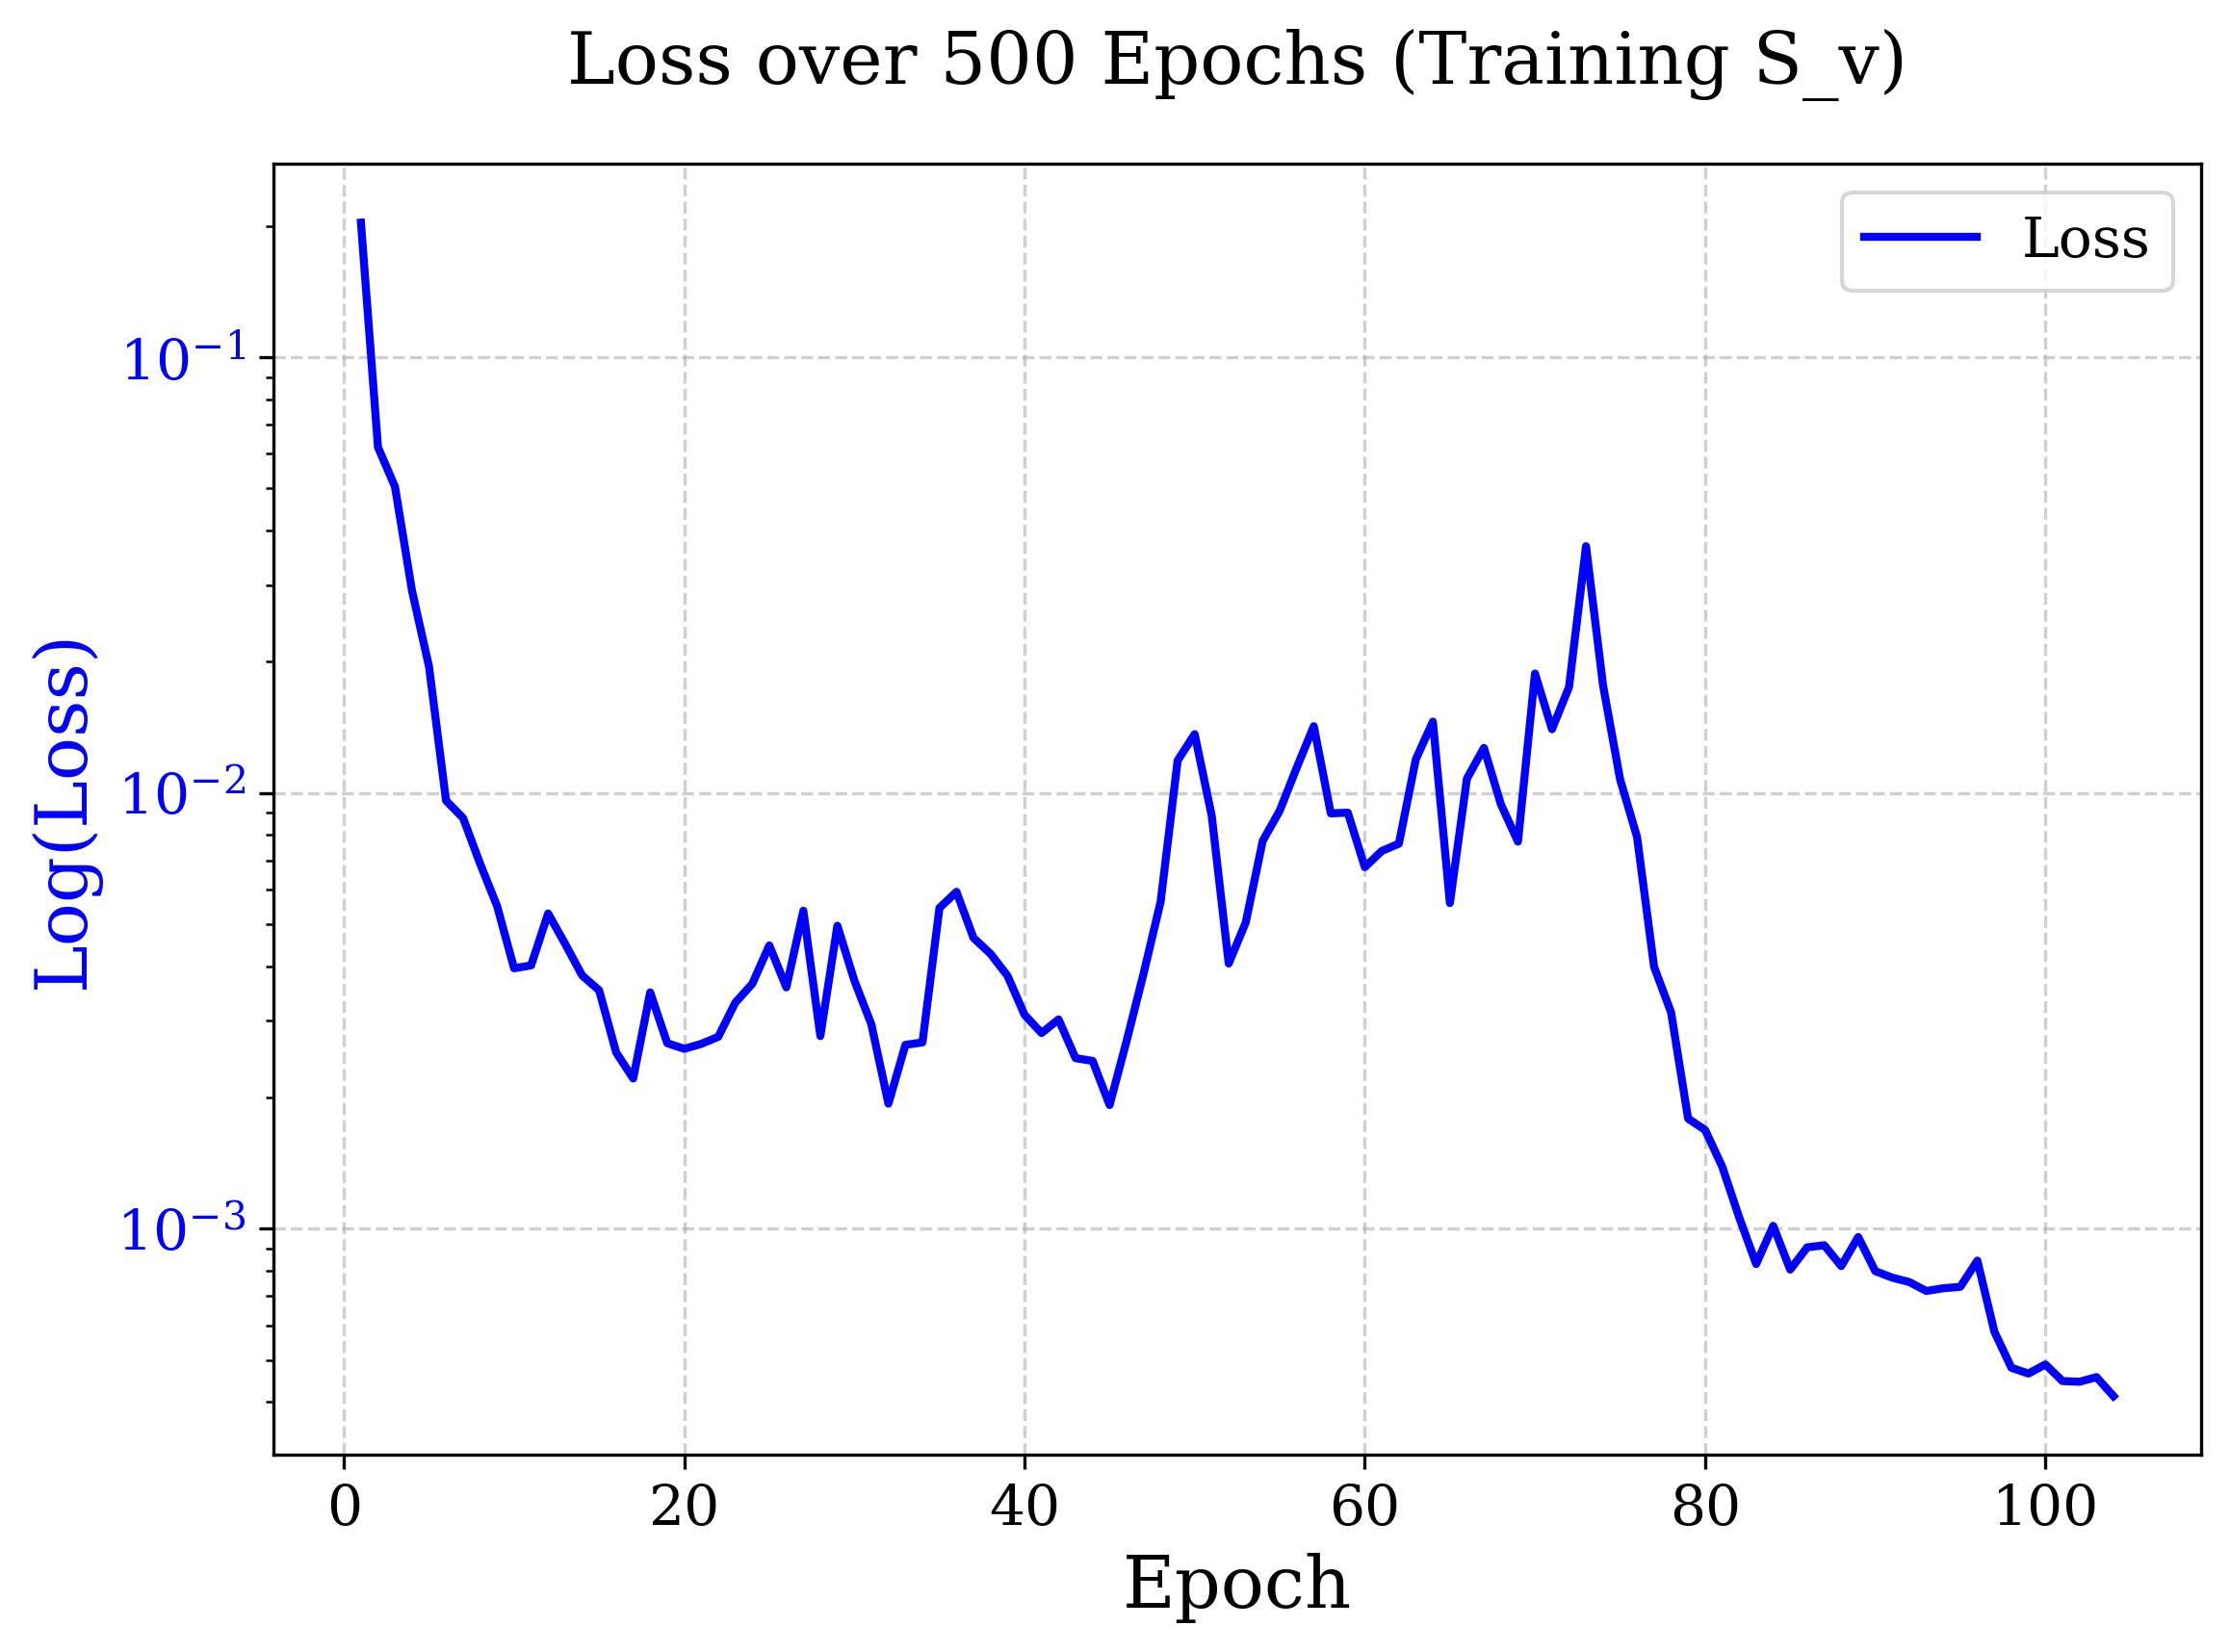

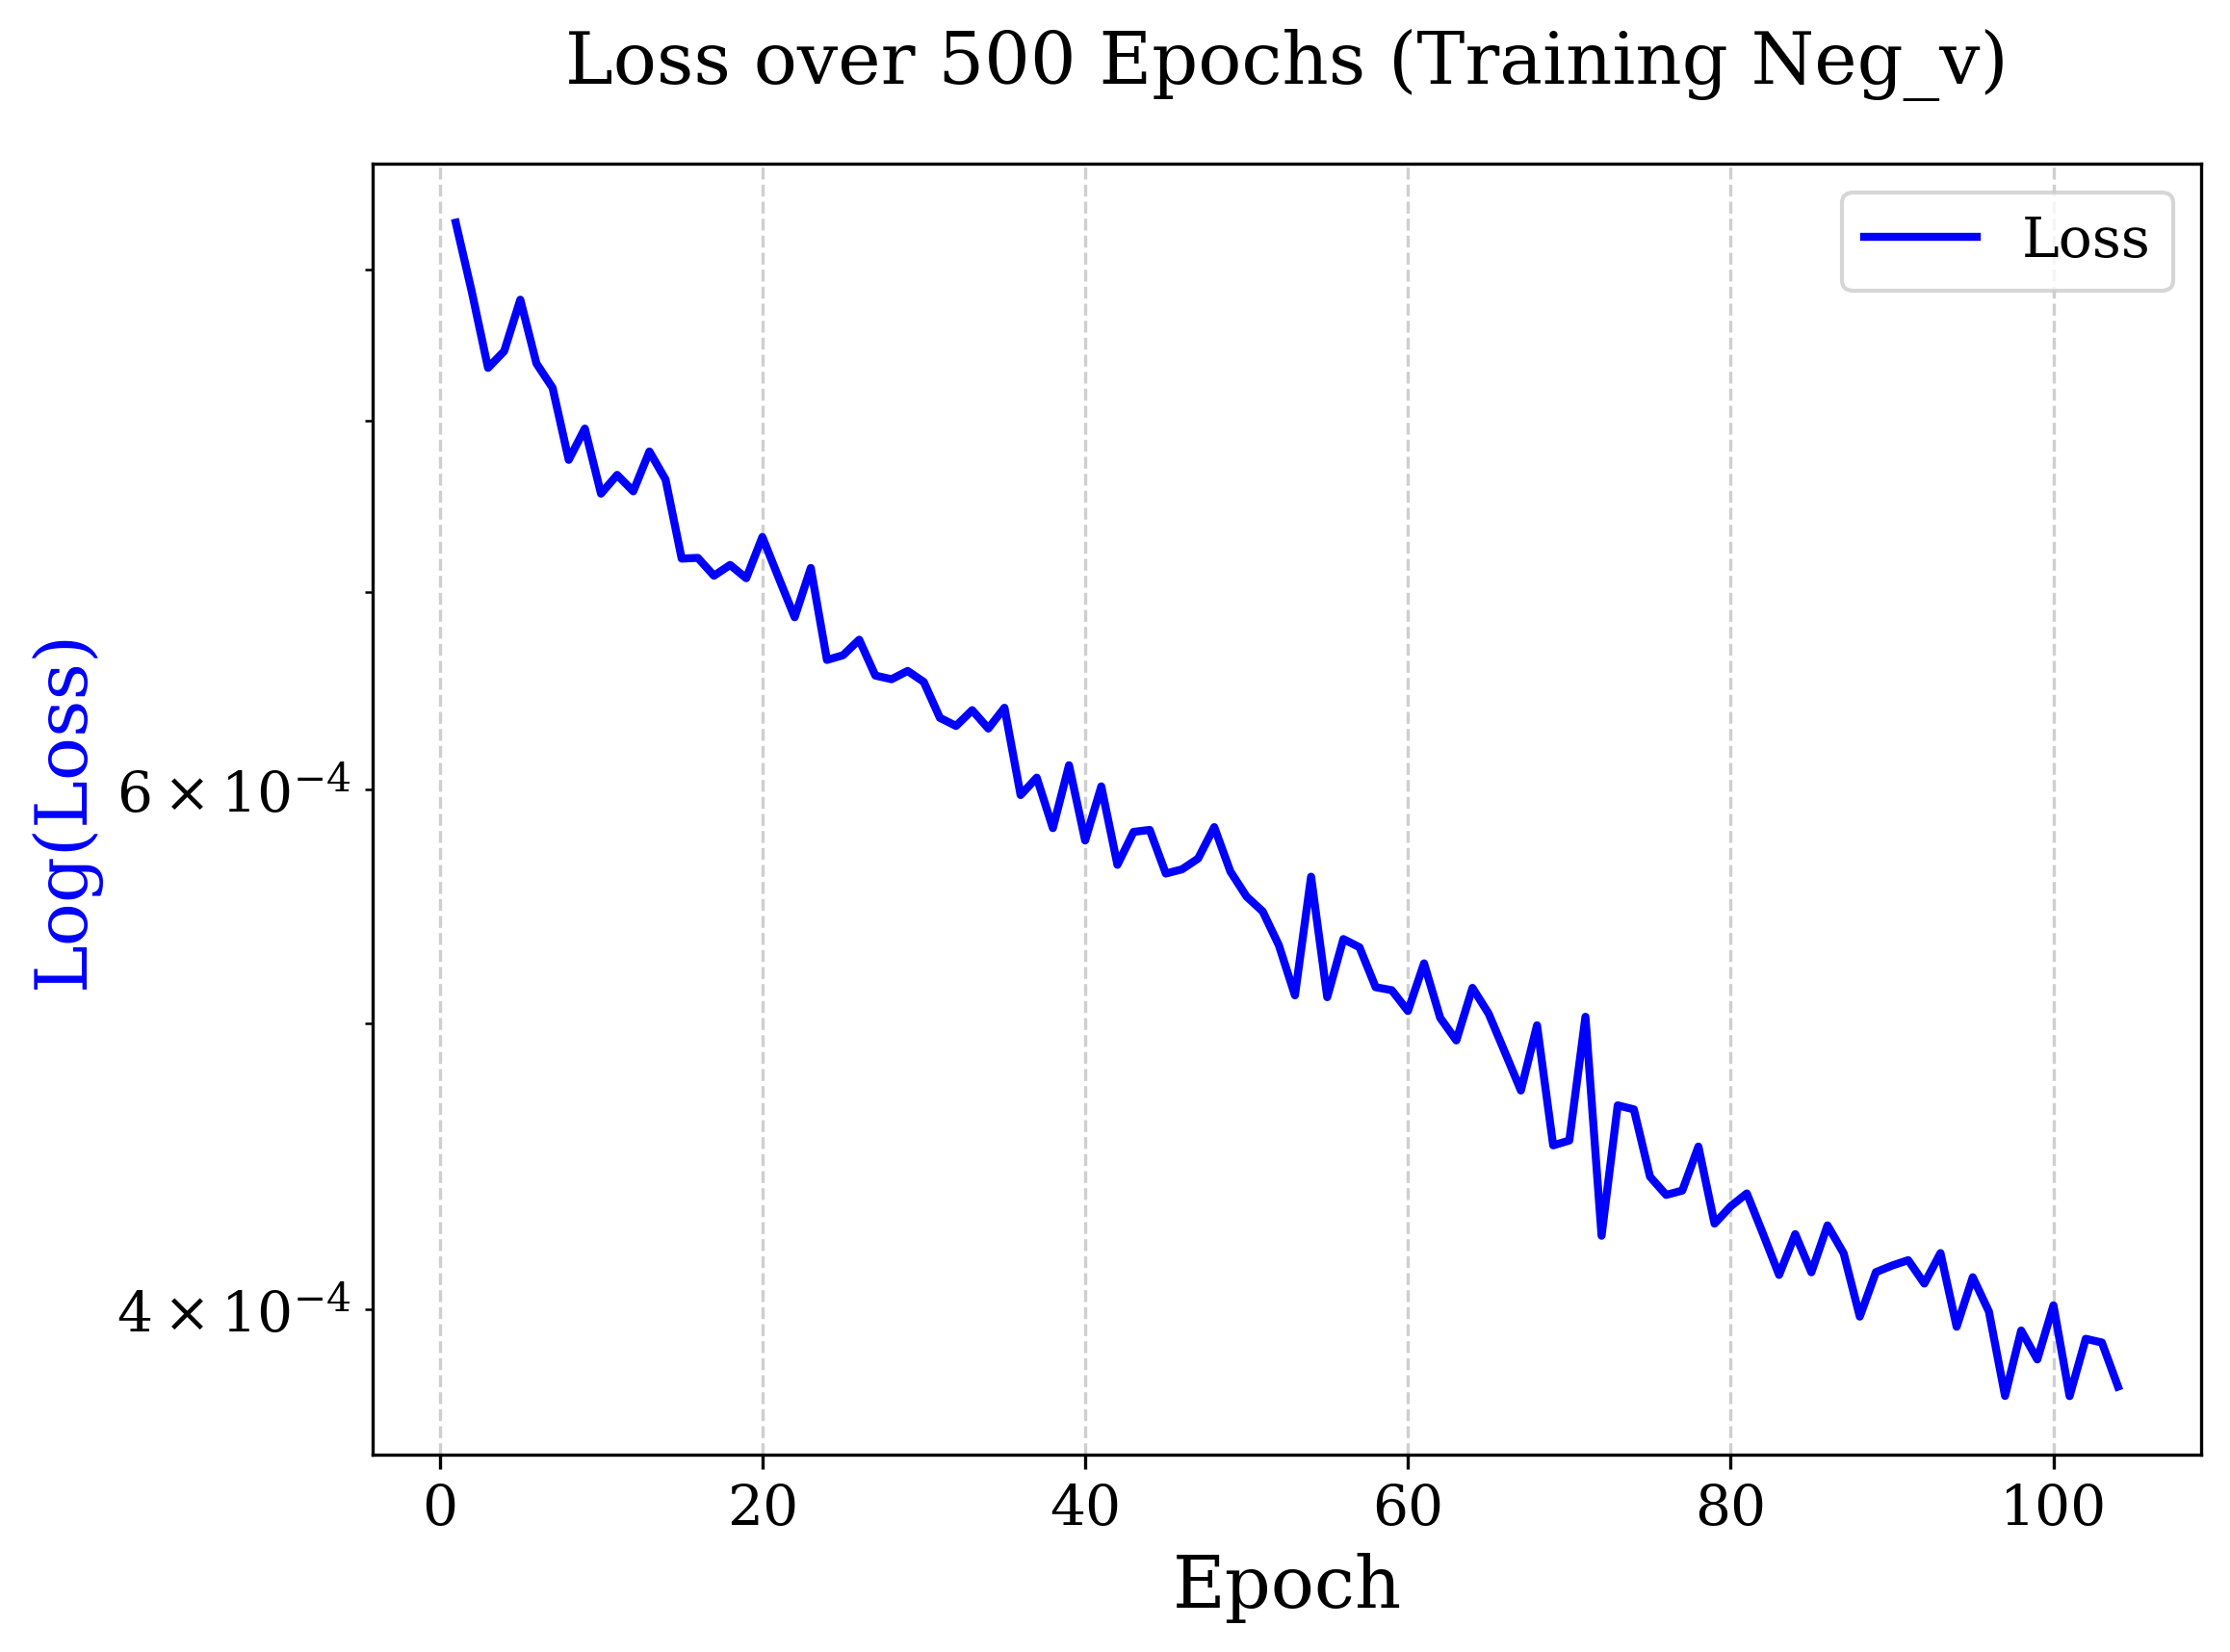

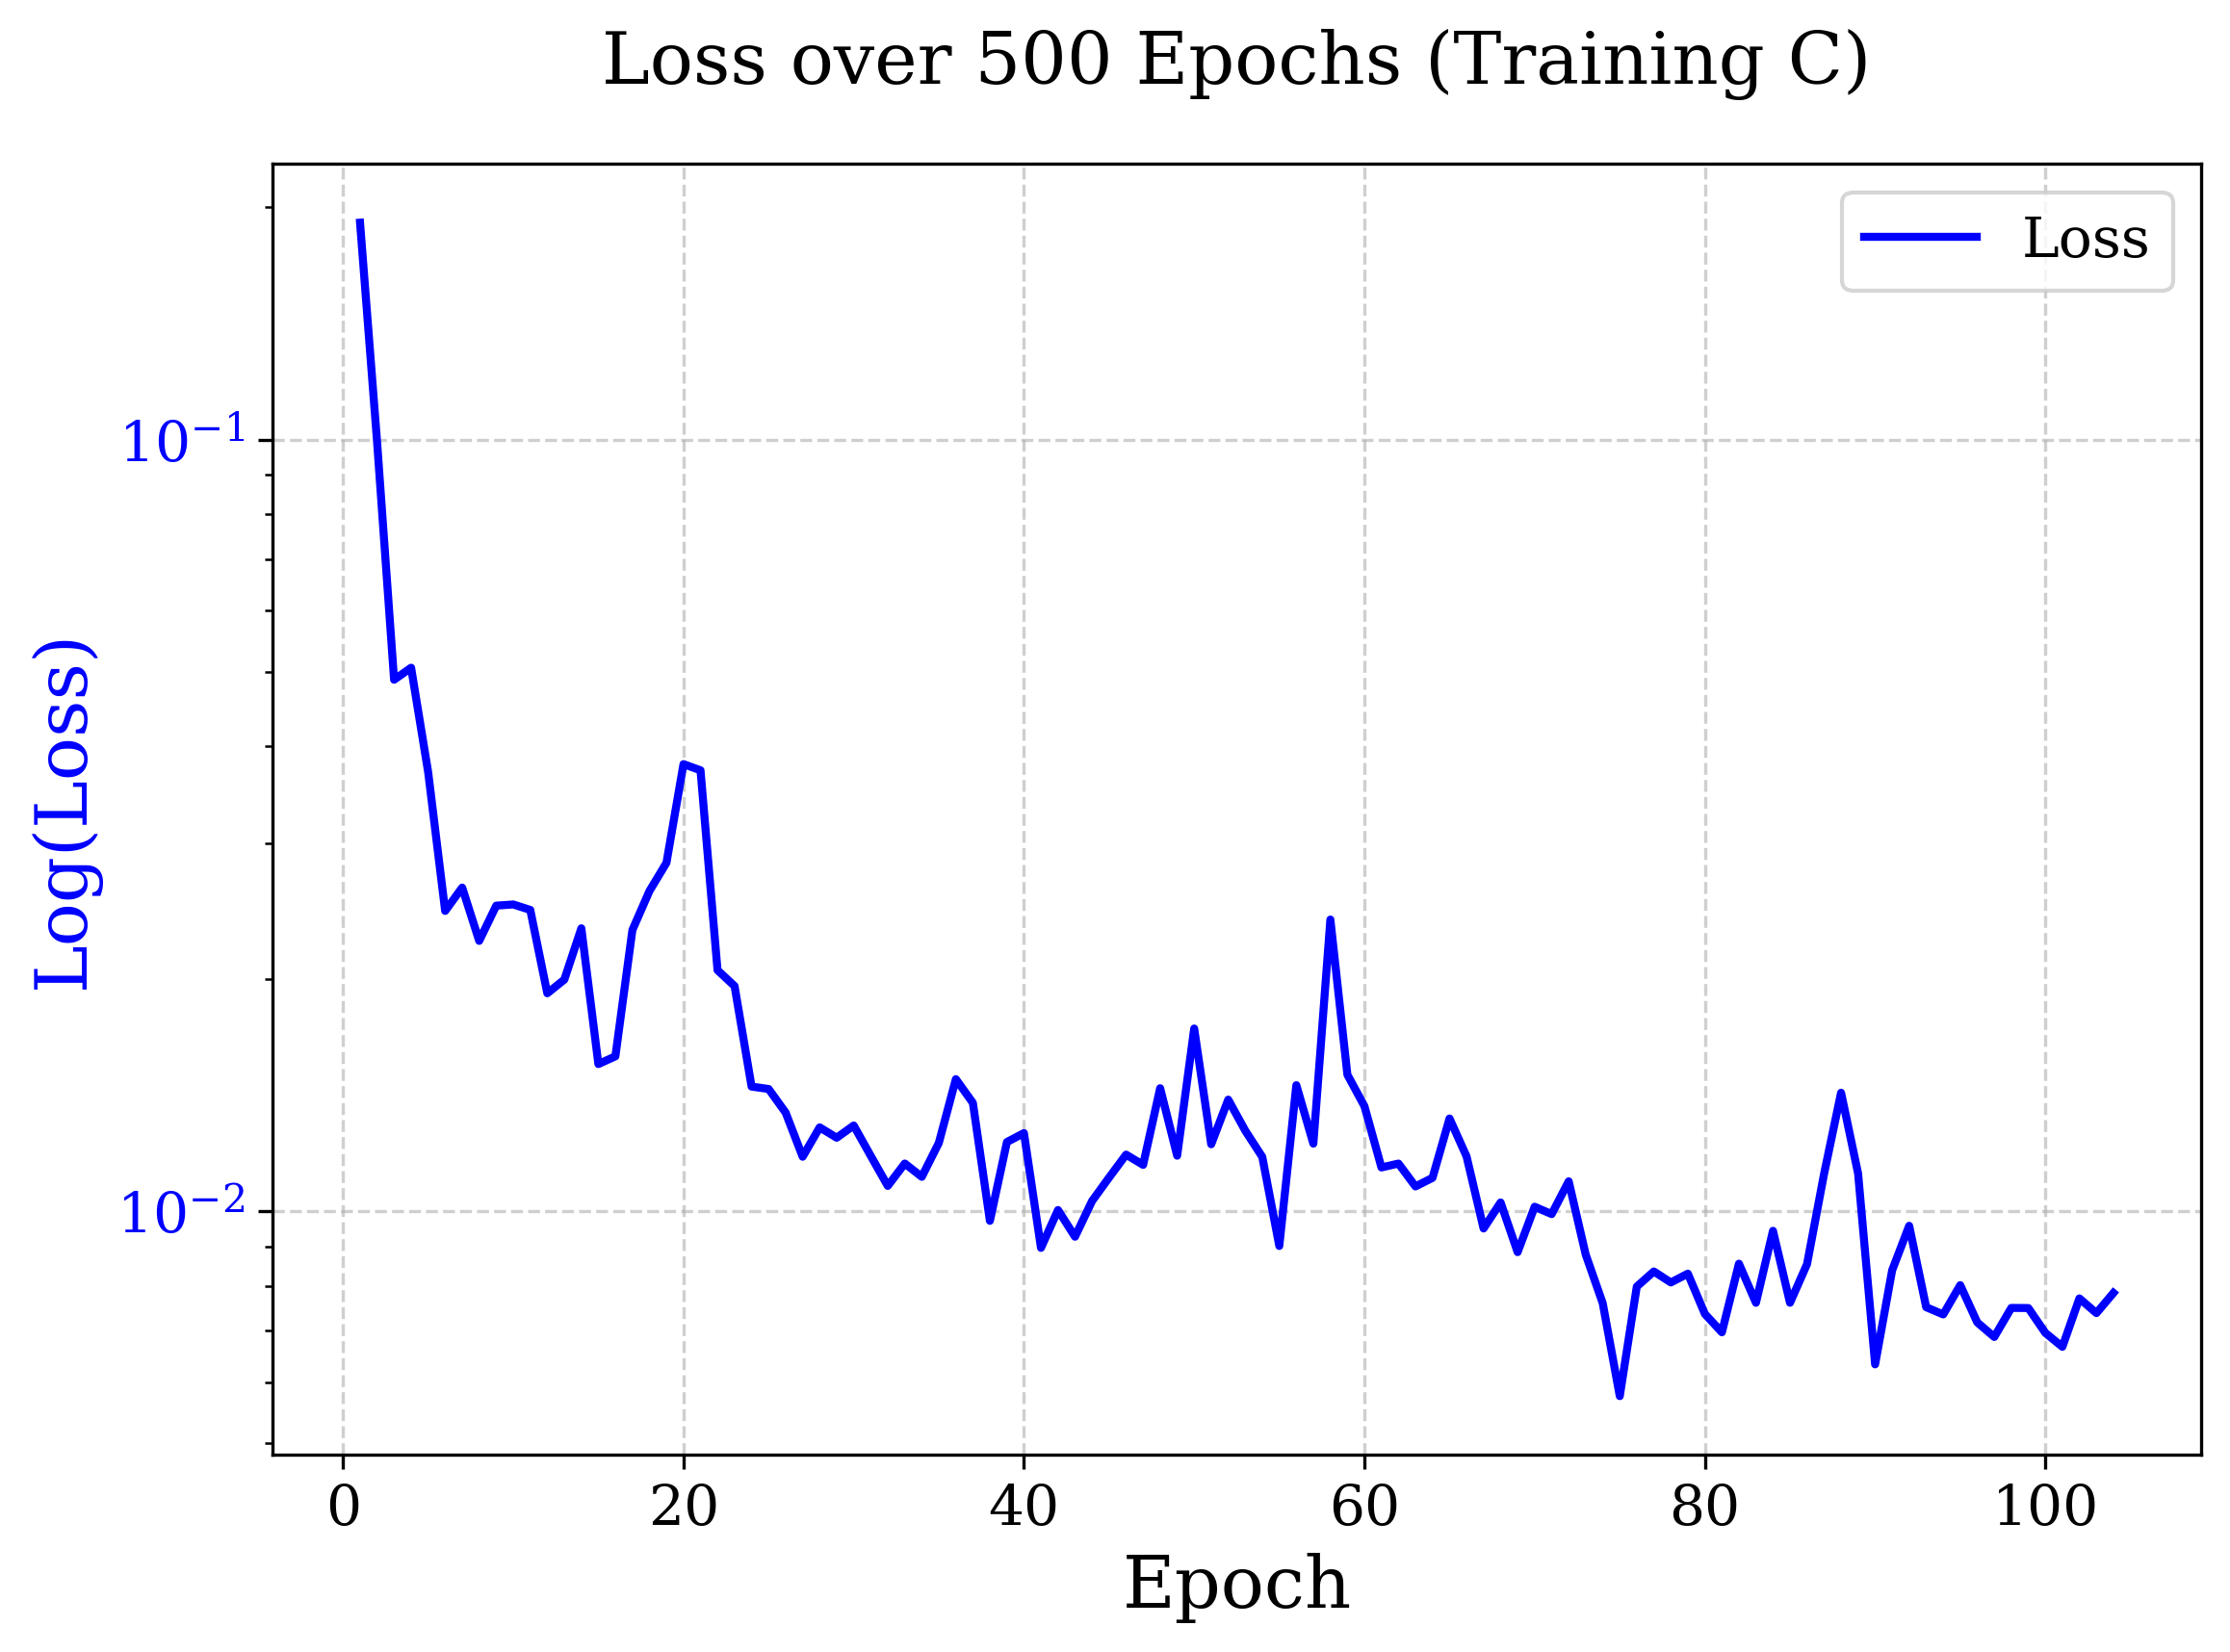

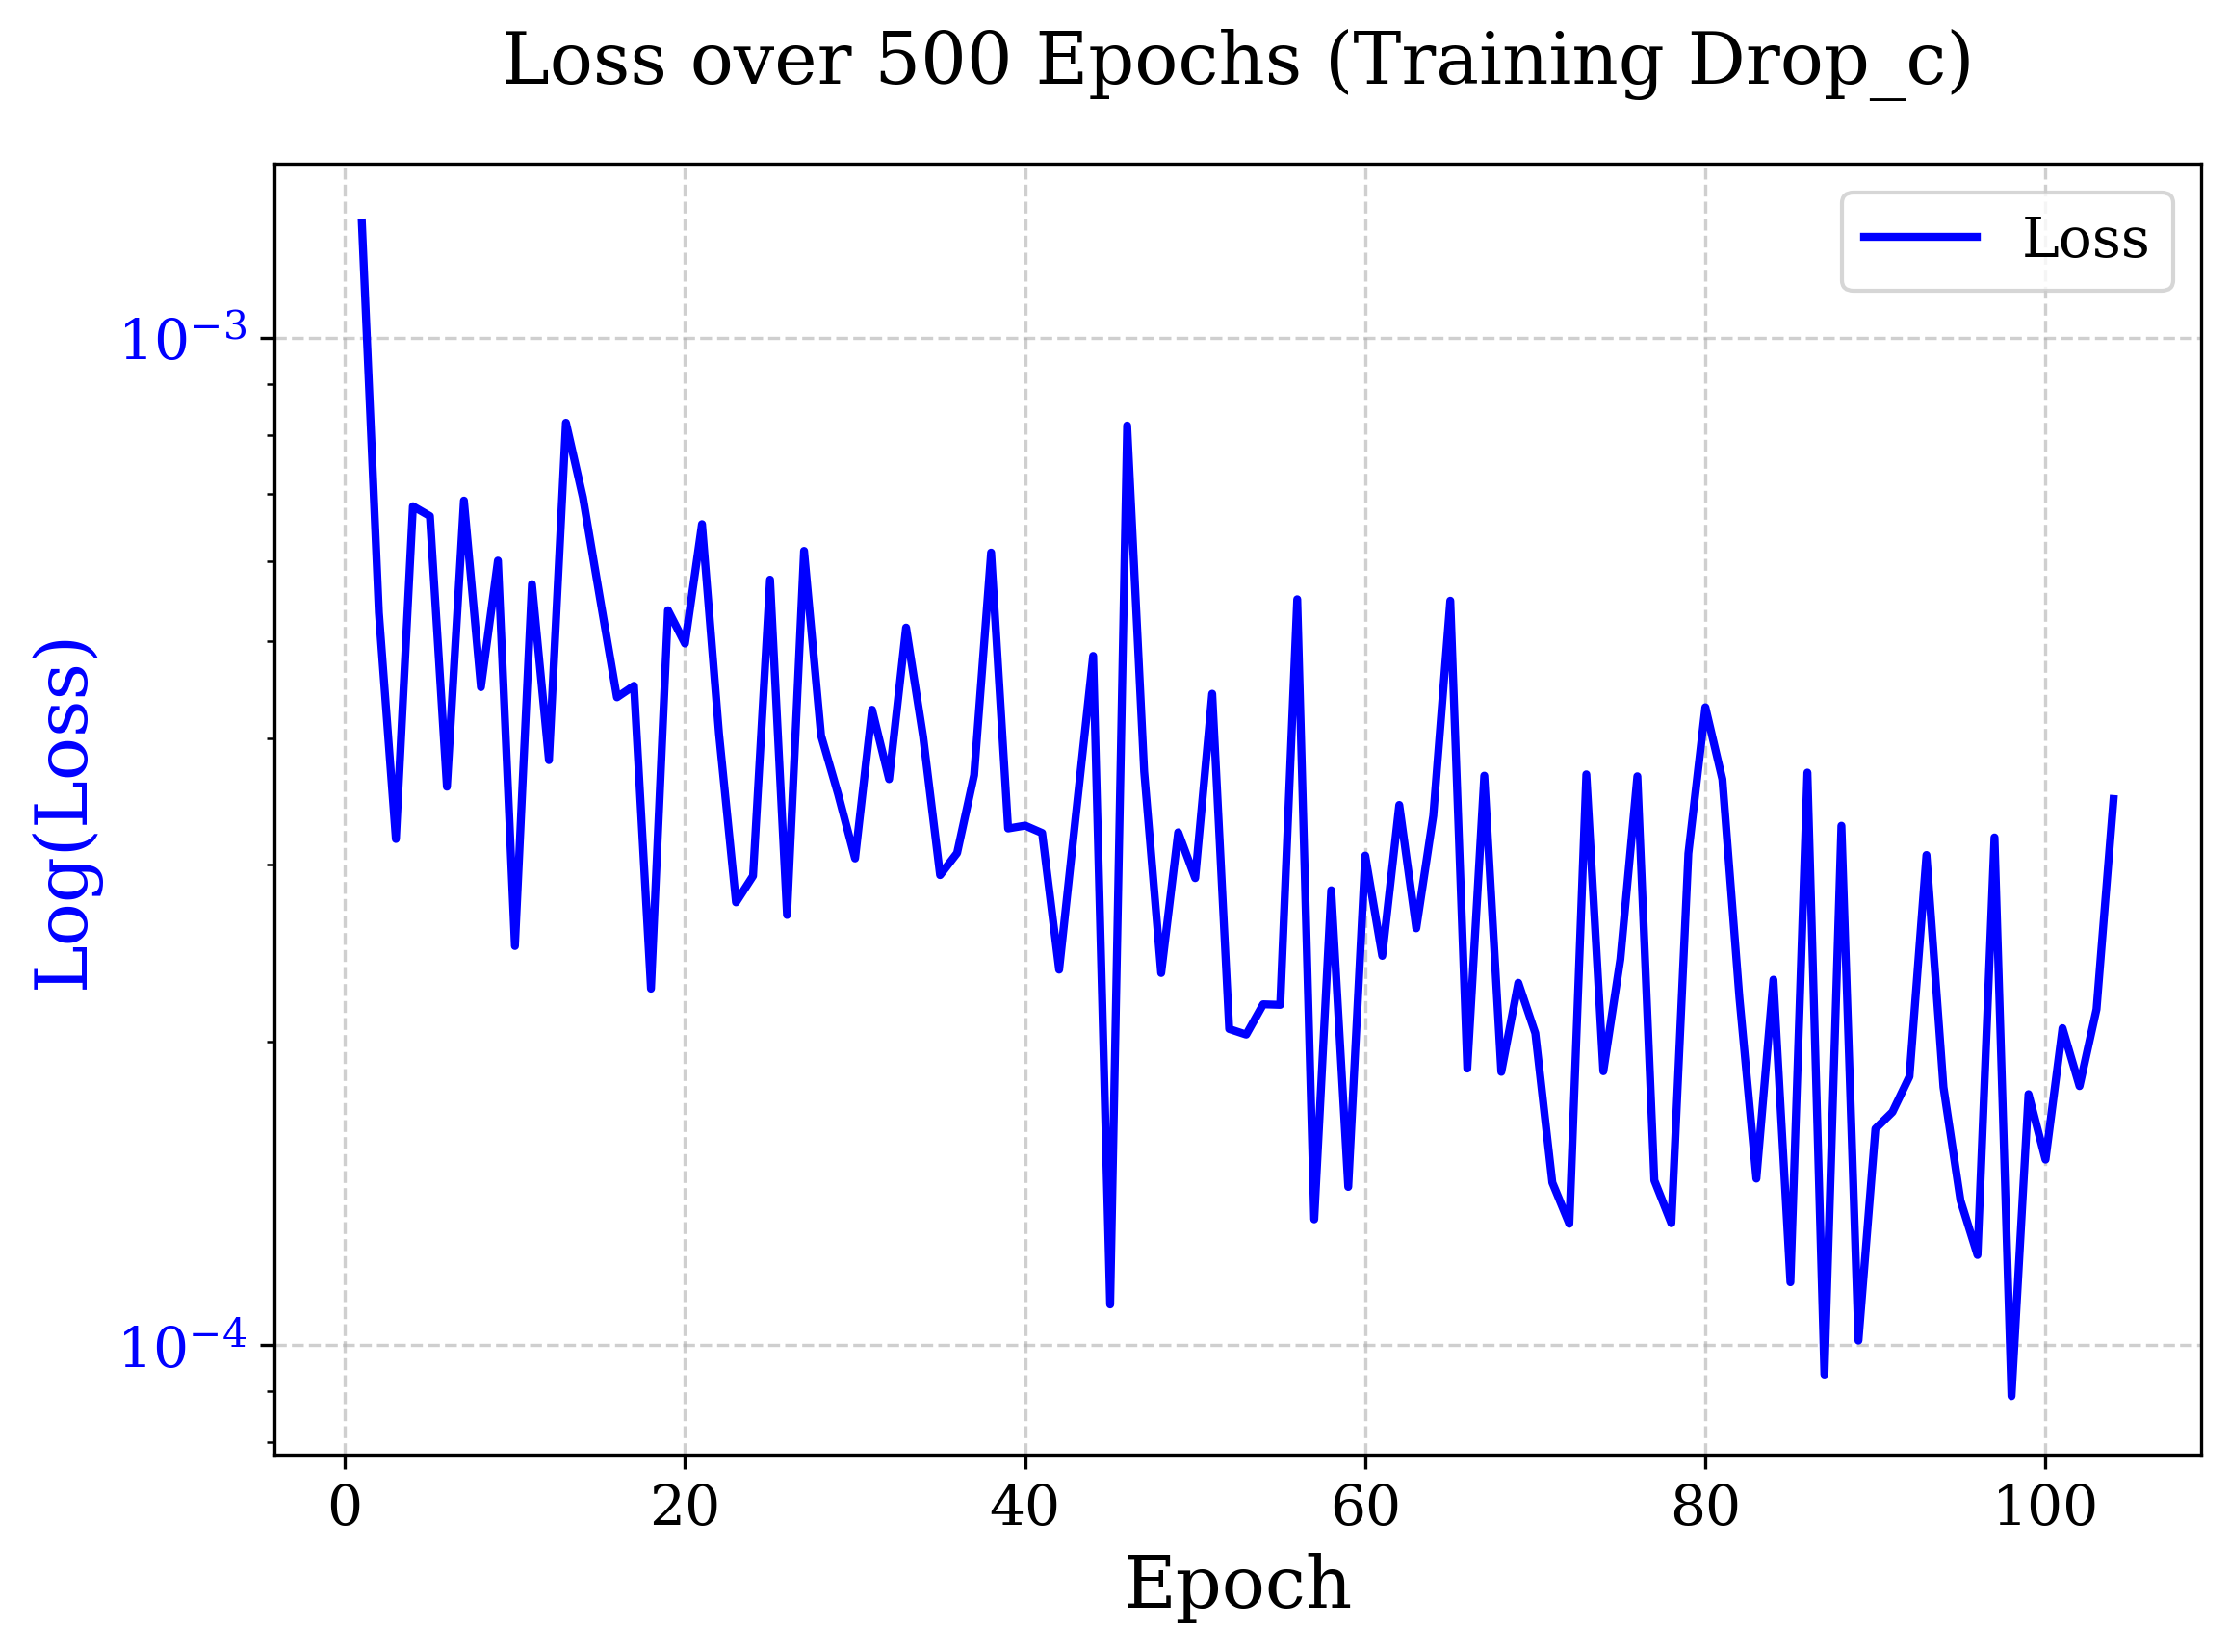

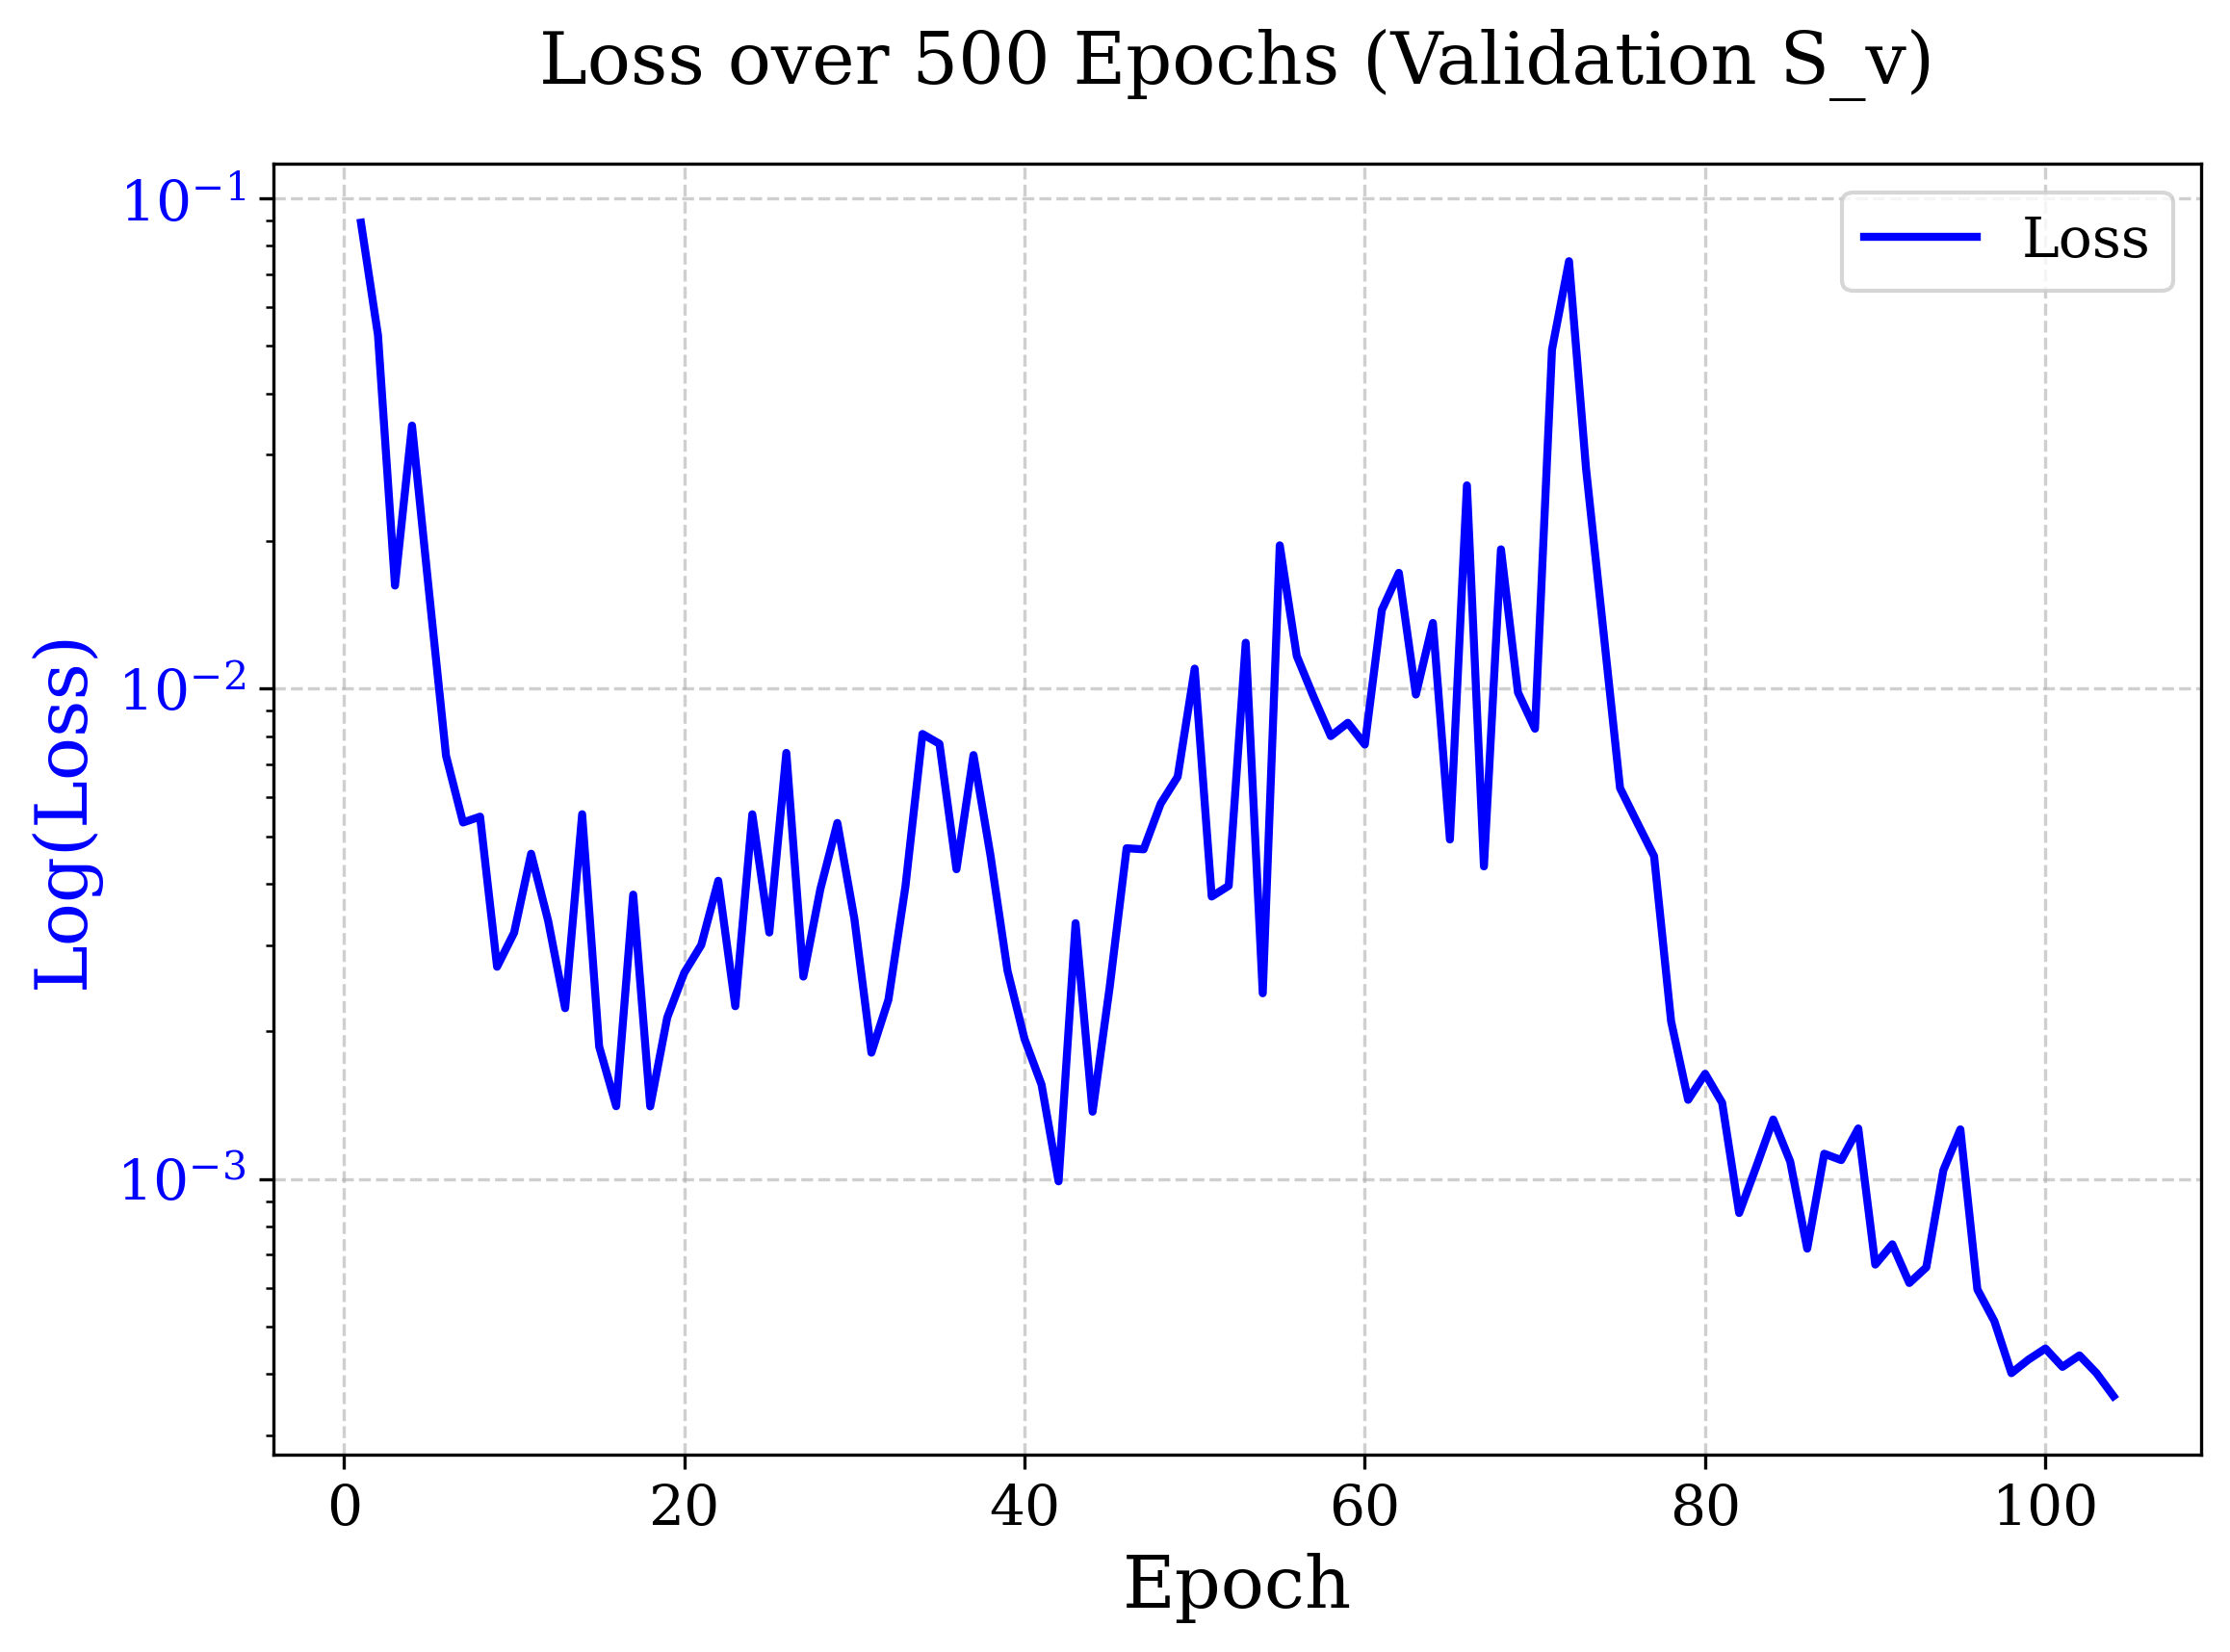

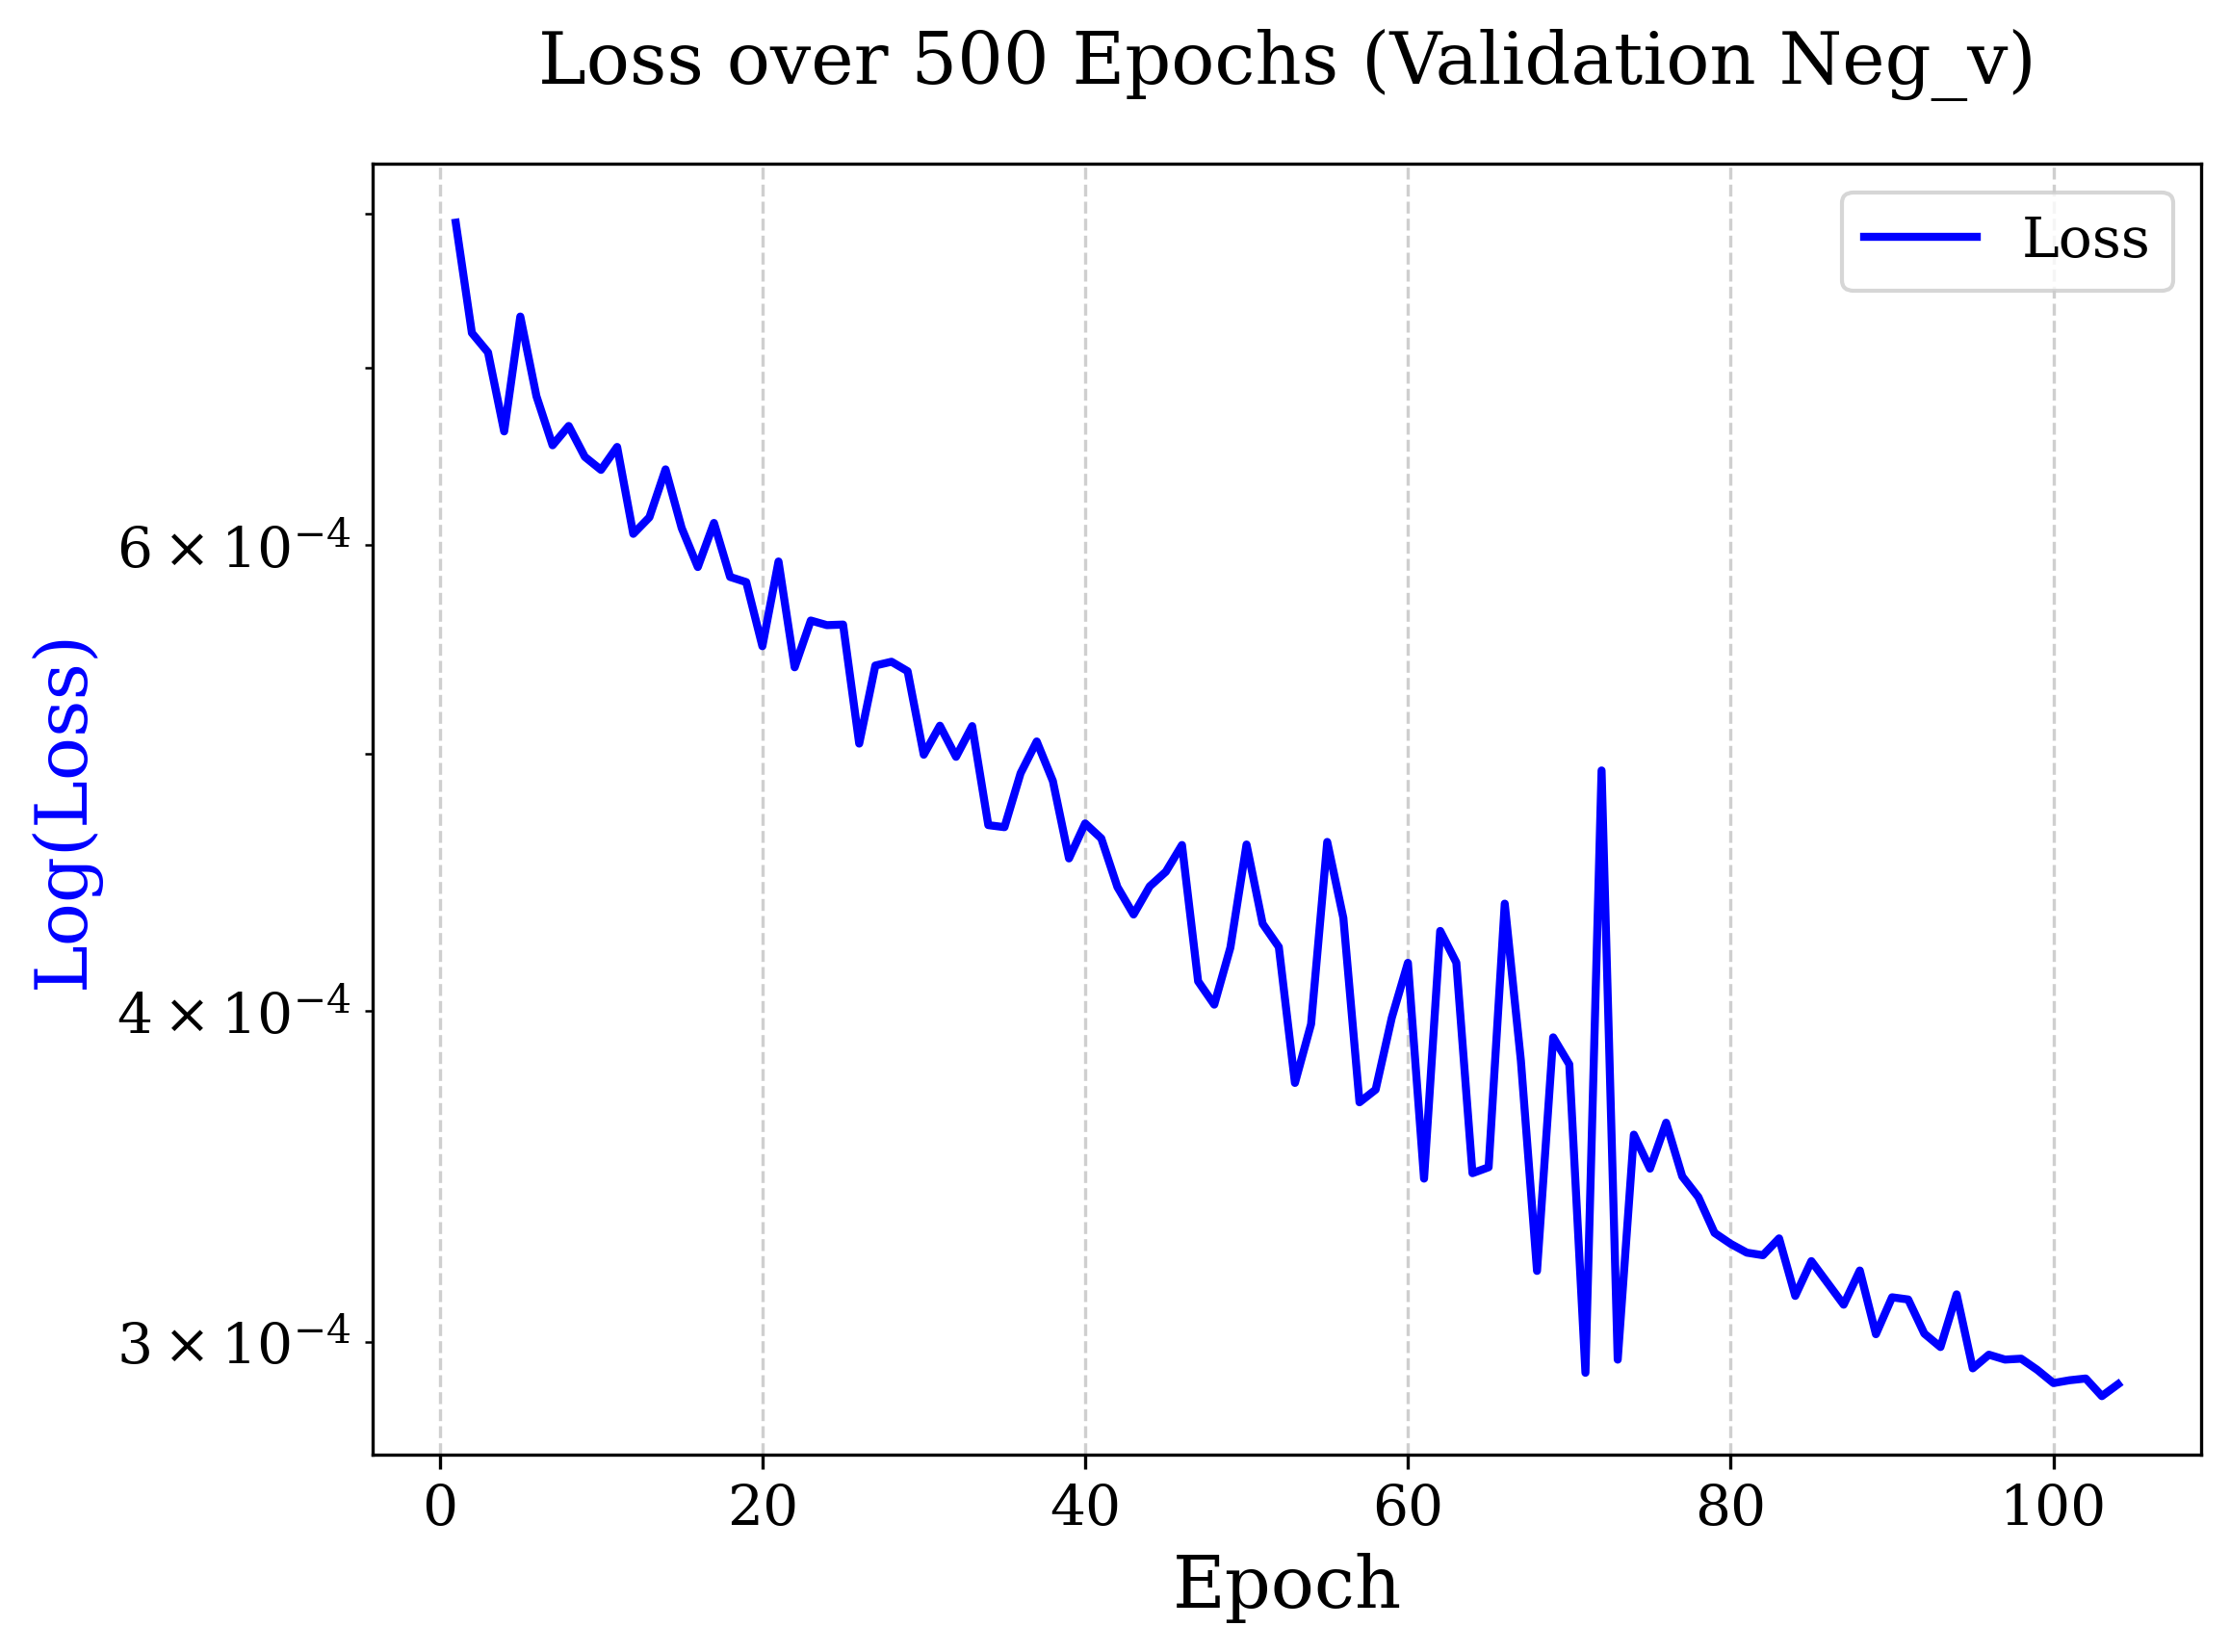

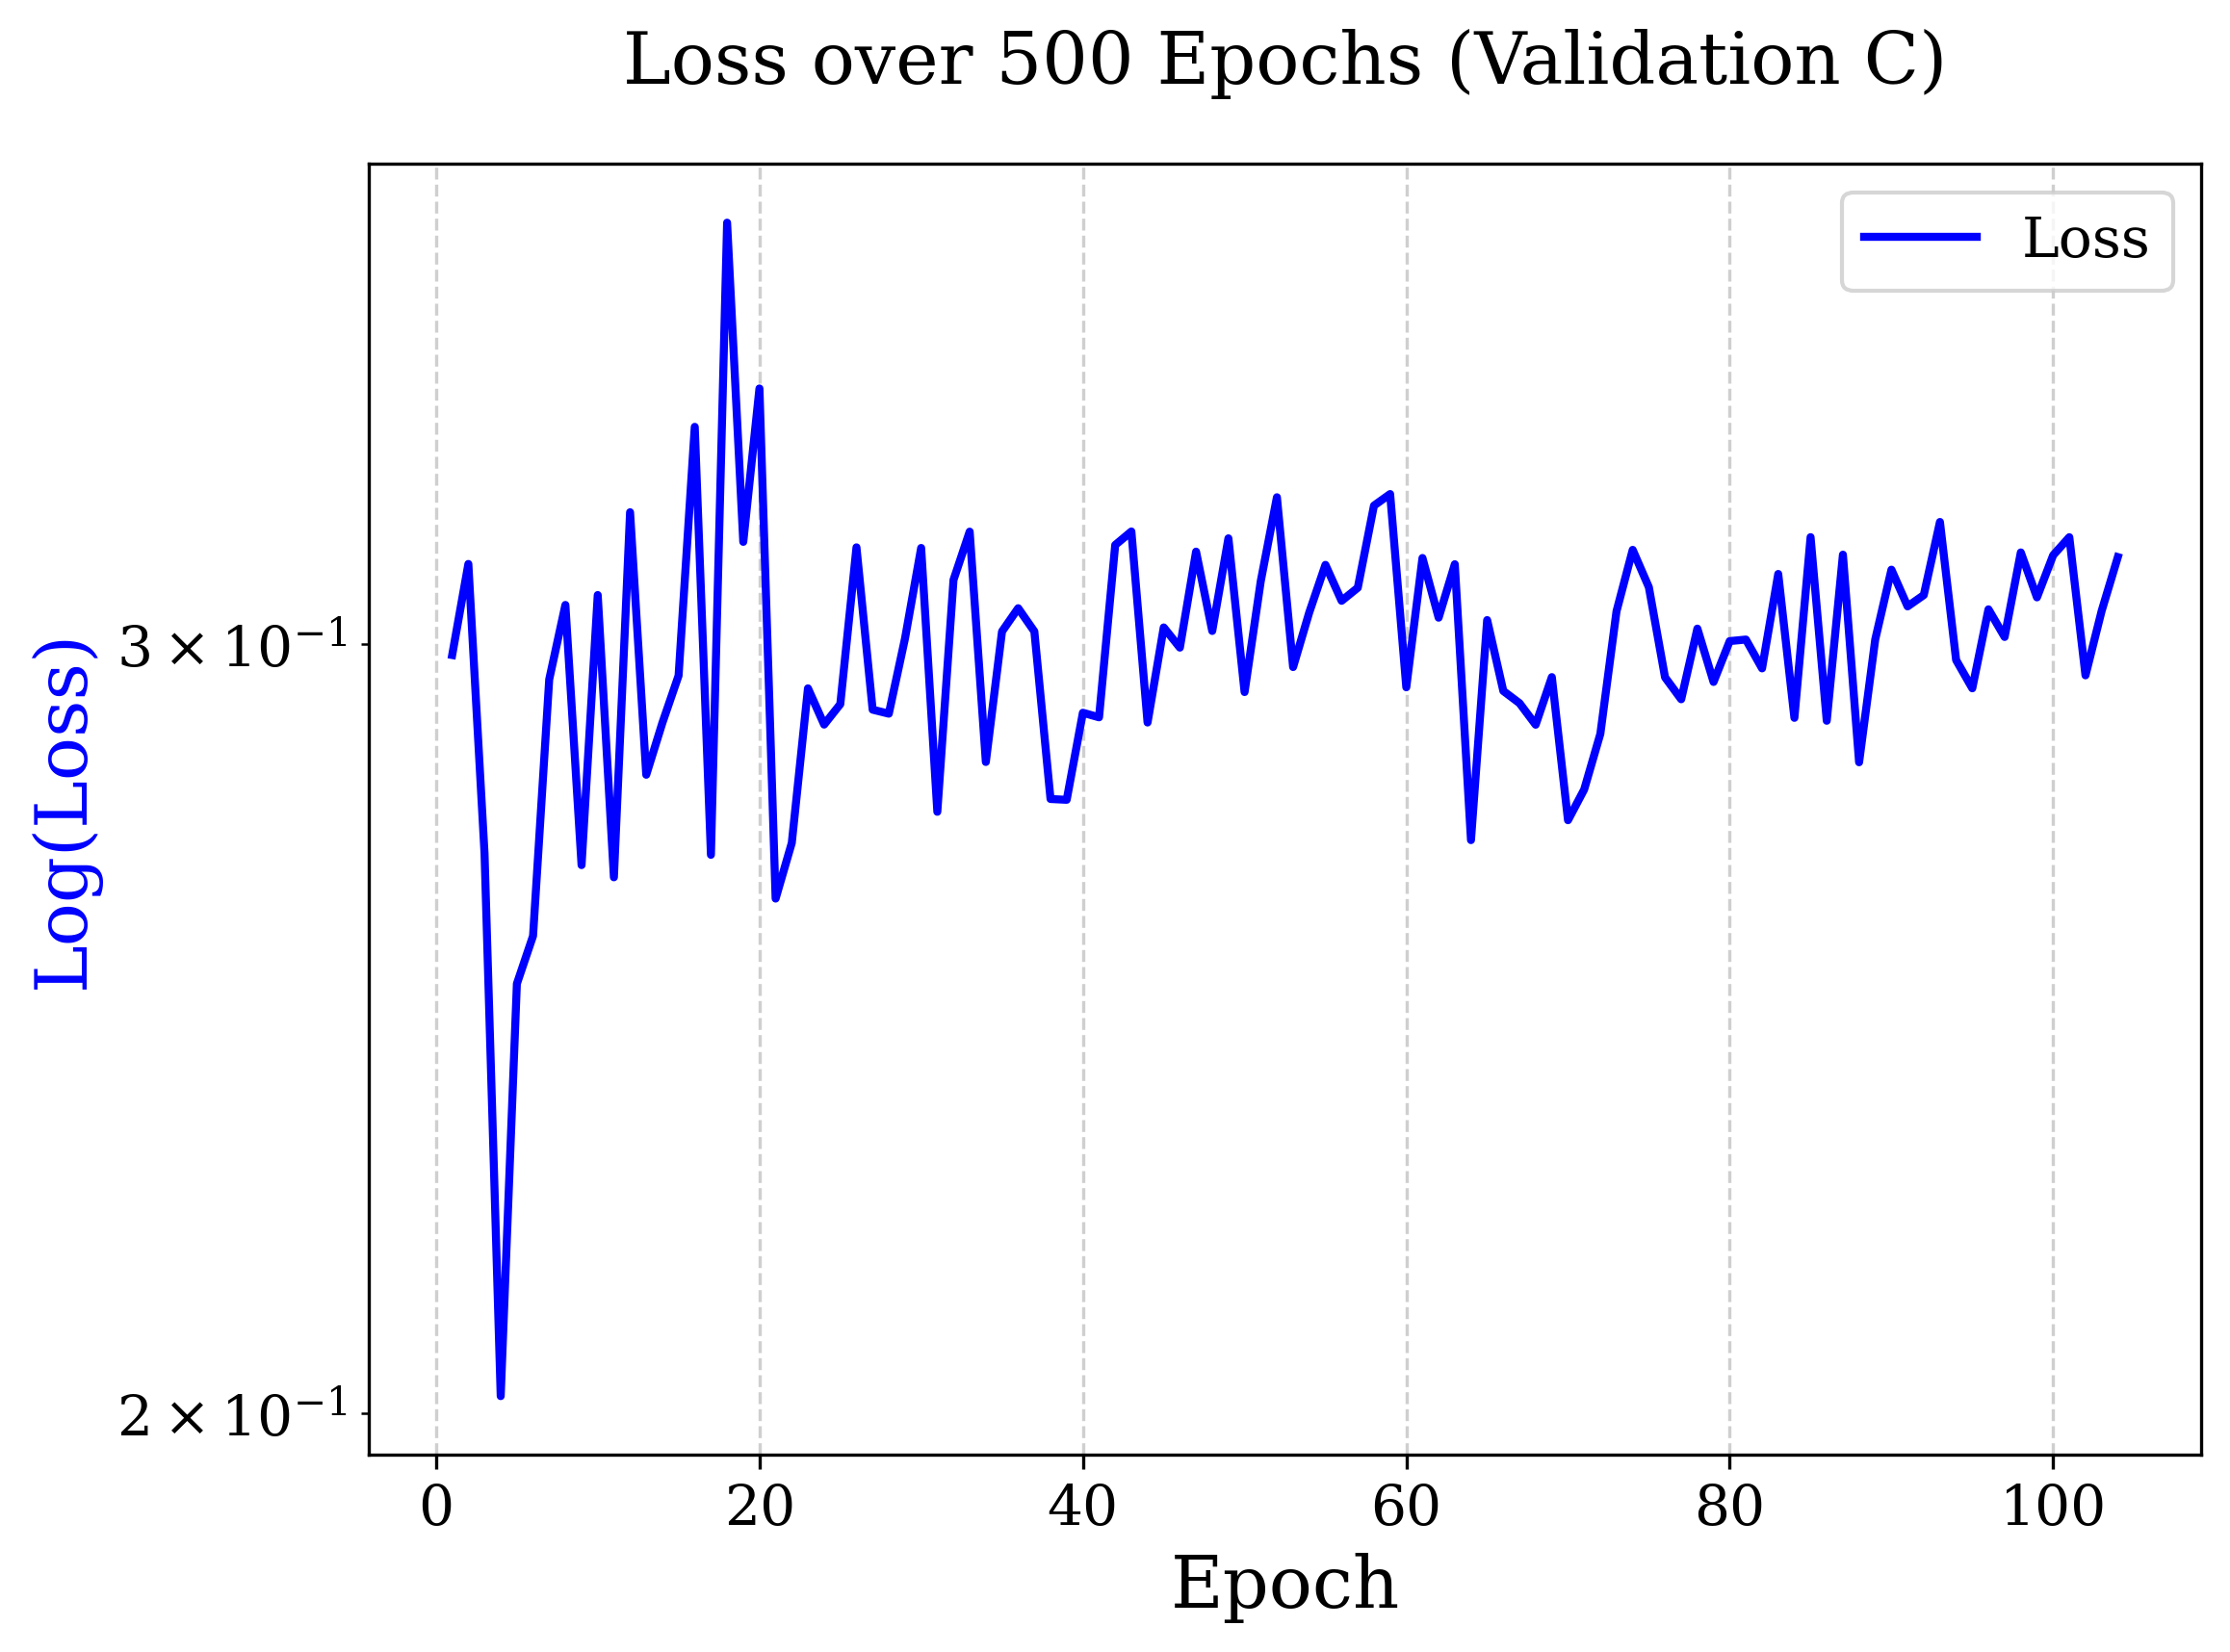

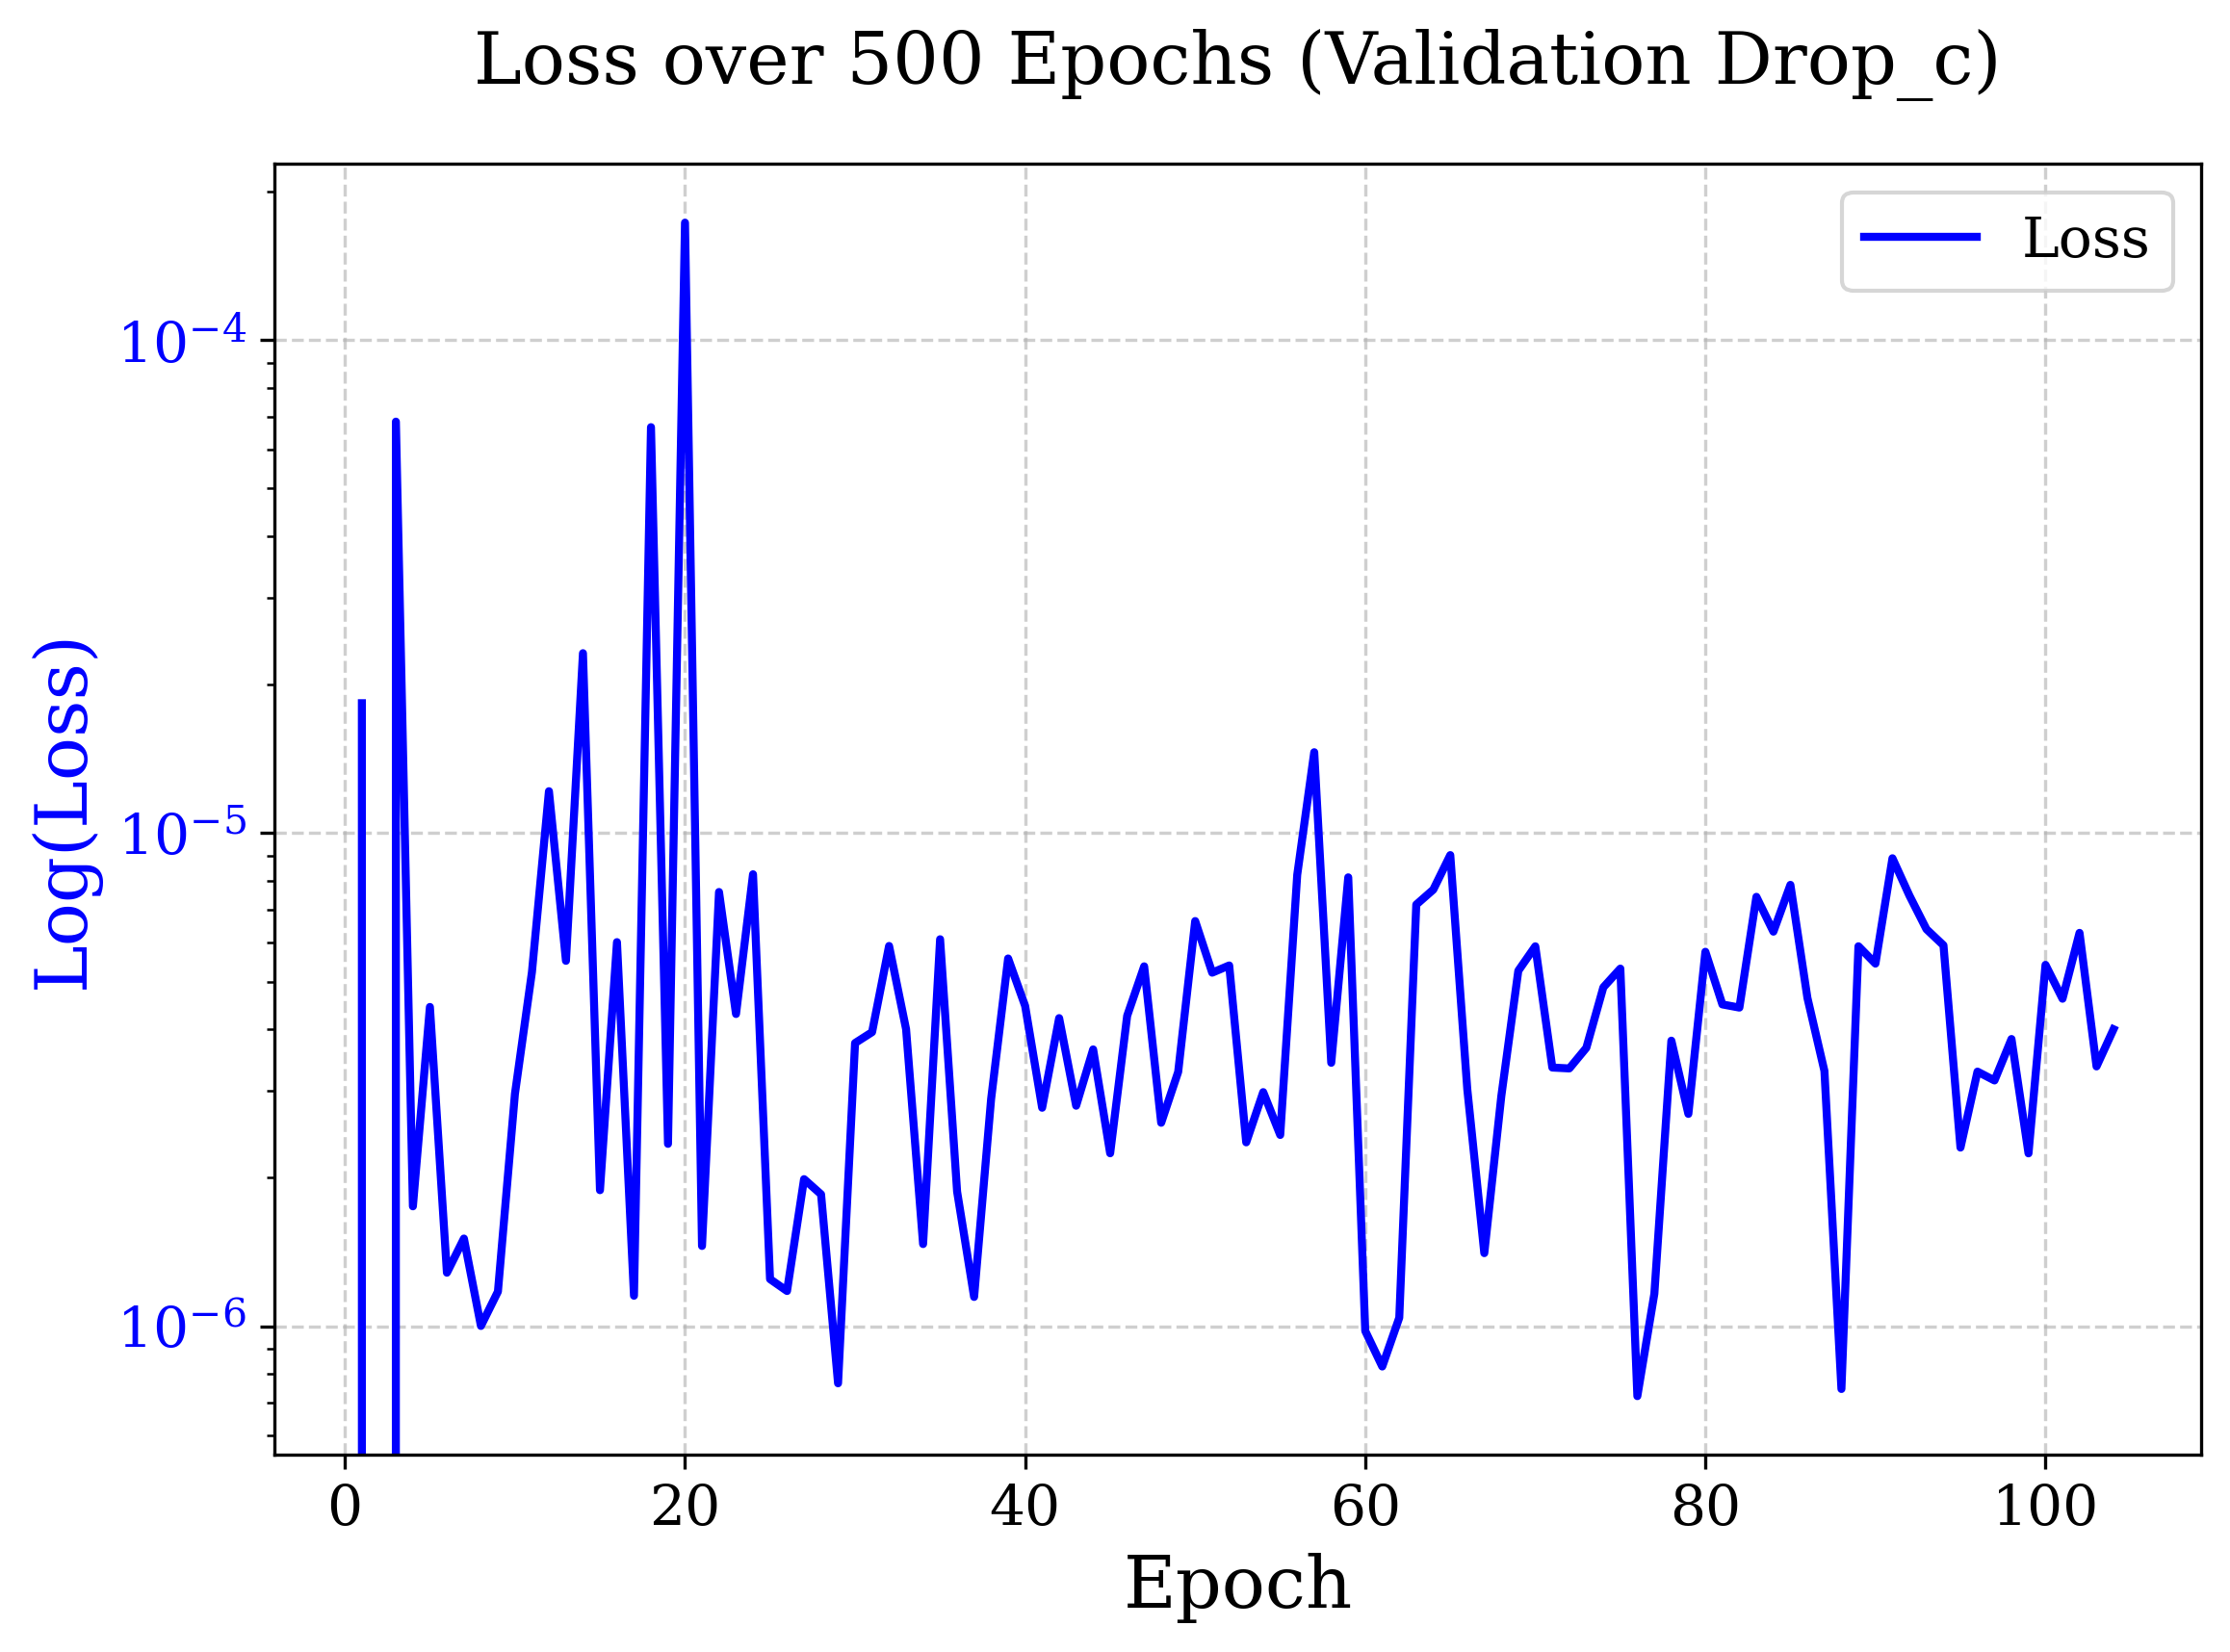

In [1]:
# P. putida
# Cell is slow you may past the cell in python code
# If you run this cell you will looses the models stored in folder model/

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
import utils
import data
import model
import plot
import sys

train_test_split = 'forecast' # 'forecast' or 'medium'
folder = './'
file_name = 'putida_OD_81'
media_file = folder+'data/'+'putida_media_81.csv'                 
od_file = folder+'data/'+file_name+'.csv'               
cobra_model_file = folder+'data/'+'IJN1463EXP_duplicated.xml'
biomass_rxn_id = 'BIOMASS_KT2440_WT3'

# Hyperparameters
seed = 1
np.random.seed(seed=seed)
hidden_layers_lag = [50]
hidden_layers_flux = [500]
num_epochs = 500
x_fold = 3    
batch_size = 10
patience = 100
N_iter = 3
run_name = f'{file_name}_{train_test_split}'

# Create model
mdl, train_array, train_dev, val_array, val_dev, val_ids = model.create_model_train_val(
    media_file, od_file,
    cobra_model_file,
    biomass_rxn_id,
    x_fold=x_fold, 
    hidden_layers_lag=hidden_layers_lag, 
    hidden_layers_flux=hidden_layers_flux, 
    dropout_rate=0.2,
    #lag_function='hill',
    loss_weight=[0.1, 0.1, 1, 1.0], # SV, negV, C, dropC
    loss_decay= [0,   1,   0, 0.5],
    verbose=False,
    train_test_split=train_test_split
)

# Saving for future testing and validation
np.savetxt(f'{folder}model/{run_name}_val_array.txt', val_array, fmt='%f')
np.savetxt(f'{folder}model/{run_name}_val_dev.txt', val_dev, fmt='%f')
np.savetxt(f'{folder}model/{run_name}_val_ids.txt', np.asarray(val_ids), fmt='%d')

# pretrain
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=280,
        decay_rate=0.9,
        staircase=True
    )
(
    (losses_s_v_train, losses_neg_v_train, losses_c_train, losses_drop_c_train),
    (losses_s_v_val, losses_neg_v_val, losses_c_val, losses_drop_c_val)
) = model.train_model(
        mdl, train_array, val_array=val_array,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        num_epochs=num_epochs, batch_size=batch_size, patience=patience,
        verbose=True,
        train_test_split=train_test_split,
        x_fold=x_fold
    )

# Train model
for i in range(N_iter):
    (
        (losses_s_v_train, losses_neg_v_train, losses_c_train, losses_drop_c_train),
        (losses_s_v_val, losses_neg_v_val, losses_c_val, losses_drop_c_val)
    ) = model.train_model(
        mdl, train_array, val_array=val_array,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        num_epochs=num_epochs, batch_size=batch_size, patience=patience,
        verbose=True,
        train_test_split=train_test_split,
        x_fold=x_fold
    )
    mdl_name = f'{folder}model/{run_name}_{str(i)}'
    mdl.save_model(model_name=mdl_name, verbose=True)

# Plot last run
plot.plot_loss('Training S_v', losses_s_v_train, num_epochs, save="./figure")
plot.plot_loss('Training Neg_v', losses_neg_v_train, num_epochs, save="./figure")
plot.plot_loss('Training C', losses_c_train, num_epochs, save="./figure")
plot.plot_loss('Training Drop_c', losses_drop_c_train, num_epochs, save="./figure")

if x_fold > 1:
    plot.plot_loss('Validation S_v', losses_s_v_val, num_epochs, save="./figure")
    plot.plot_loss('Validation Neg_v', losses_neg_v_val, num_epochs, save="./figure")
    plot.plot_loss('Validation C', losses_c_val, num_epochs, save="./figure")
    plot.plot_loss('Validation Drop_c', losses_drop_c_val, num_epochs, save="./figure")


## Test

Model: M28_OD_20_medium  R2 = 0.90±0.16 R2dev = 0.05 Median = 0.96


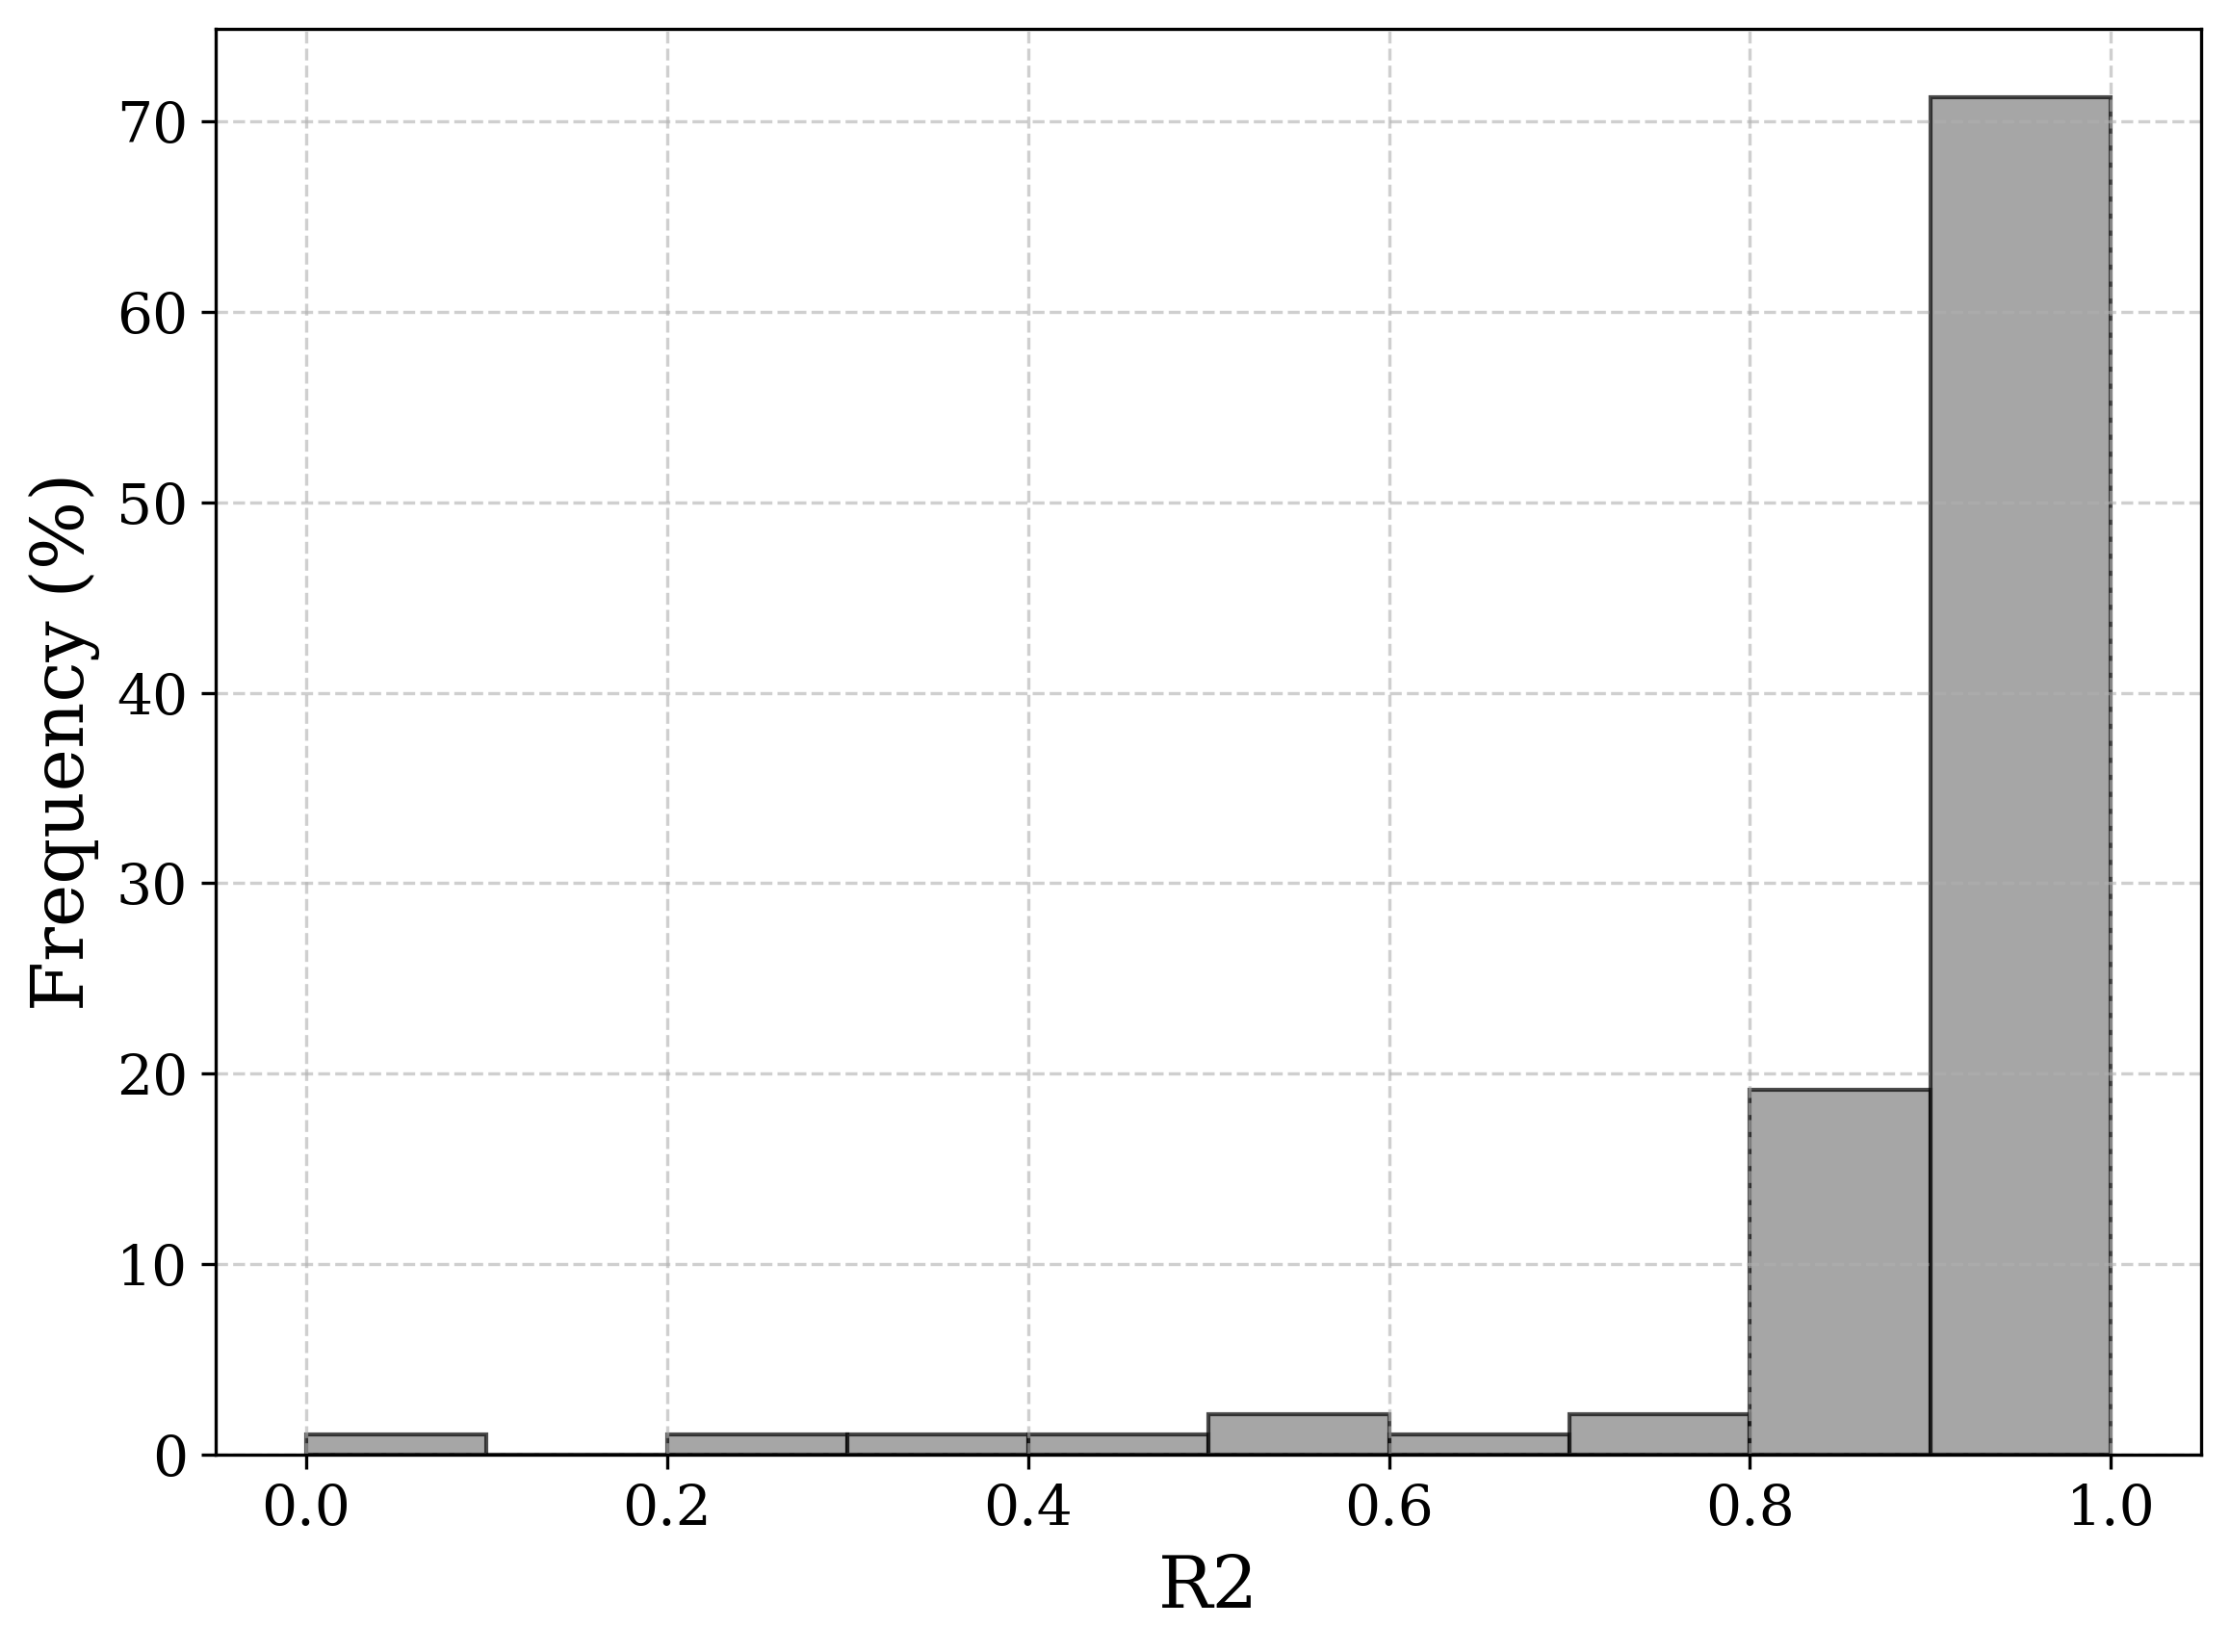

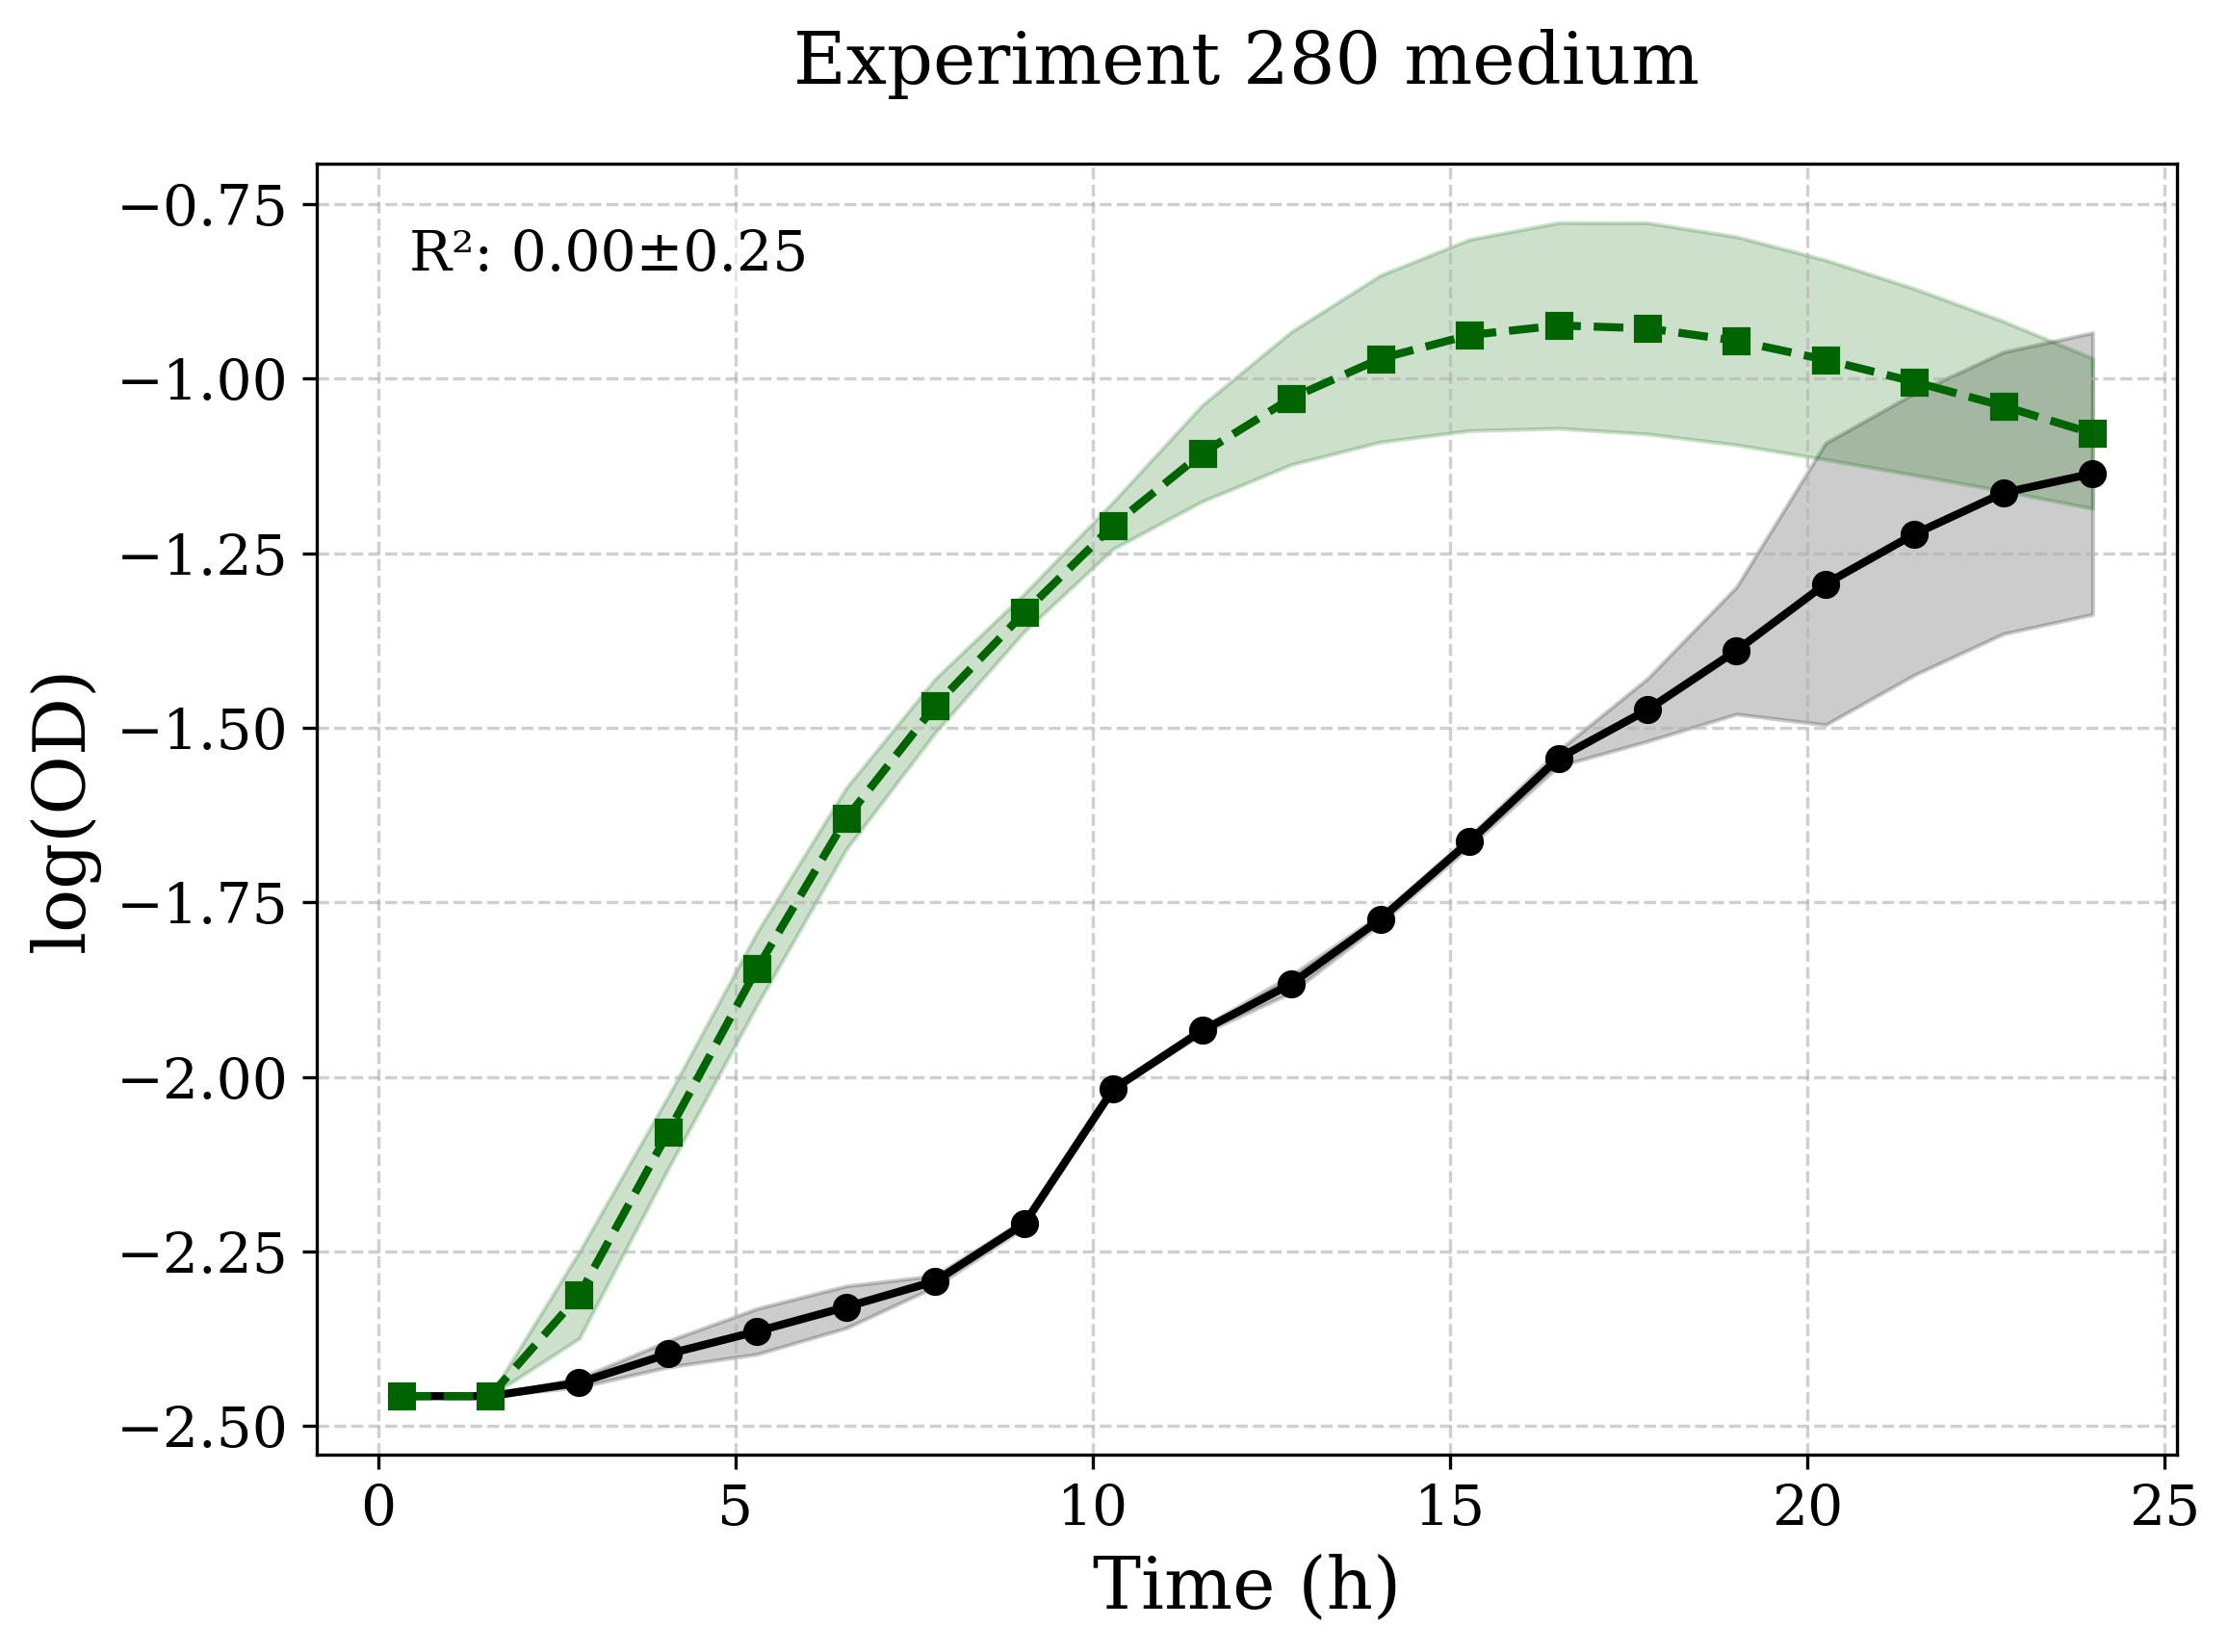

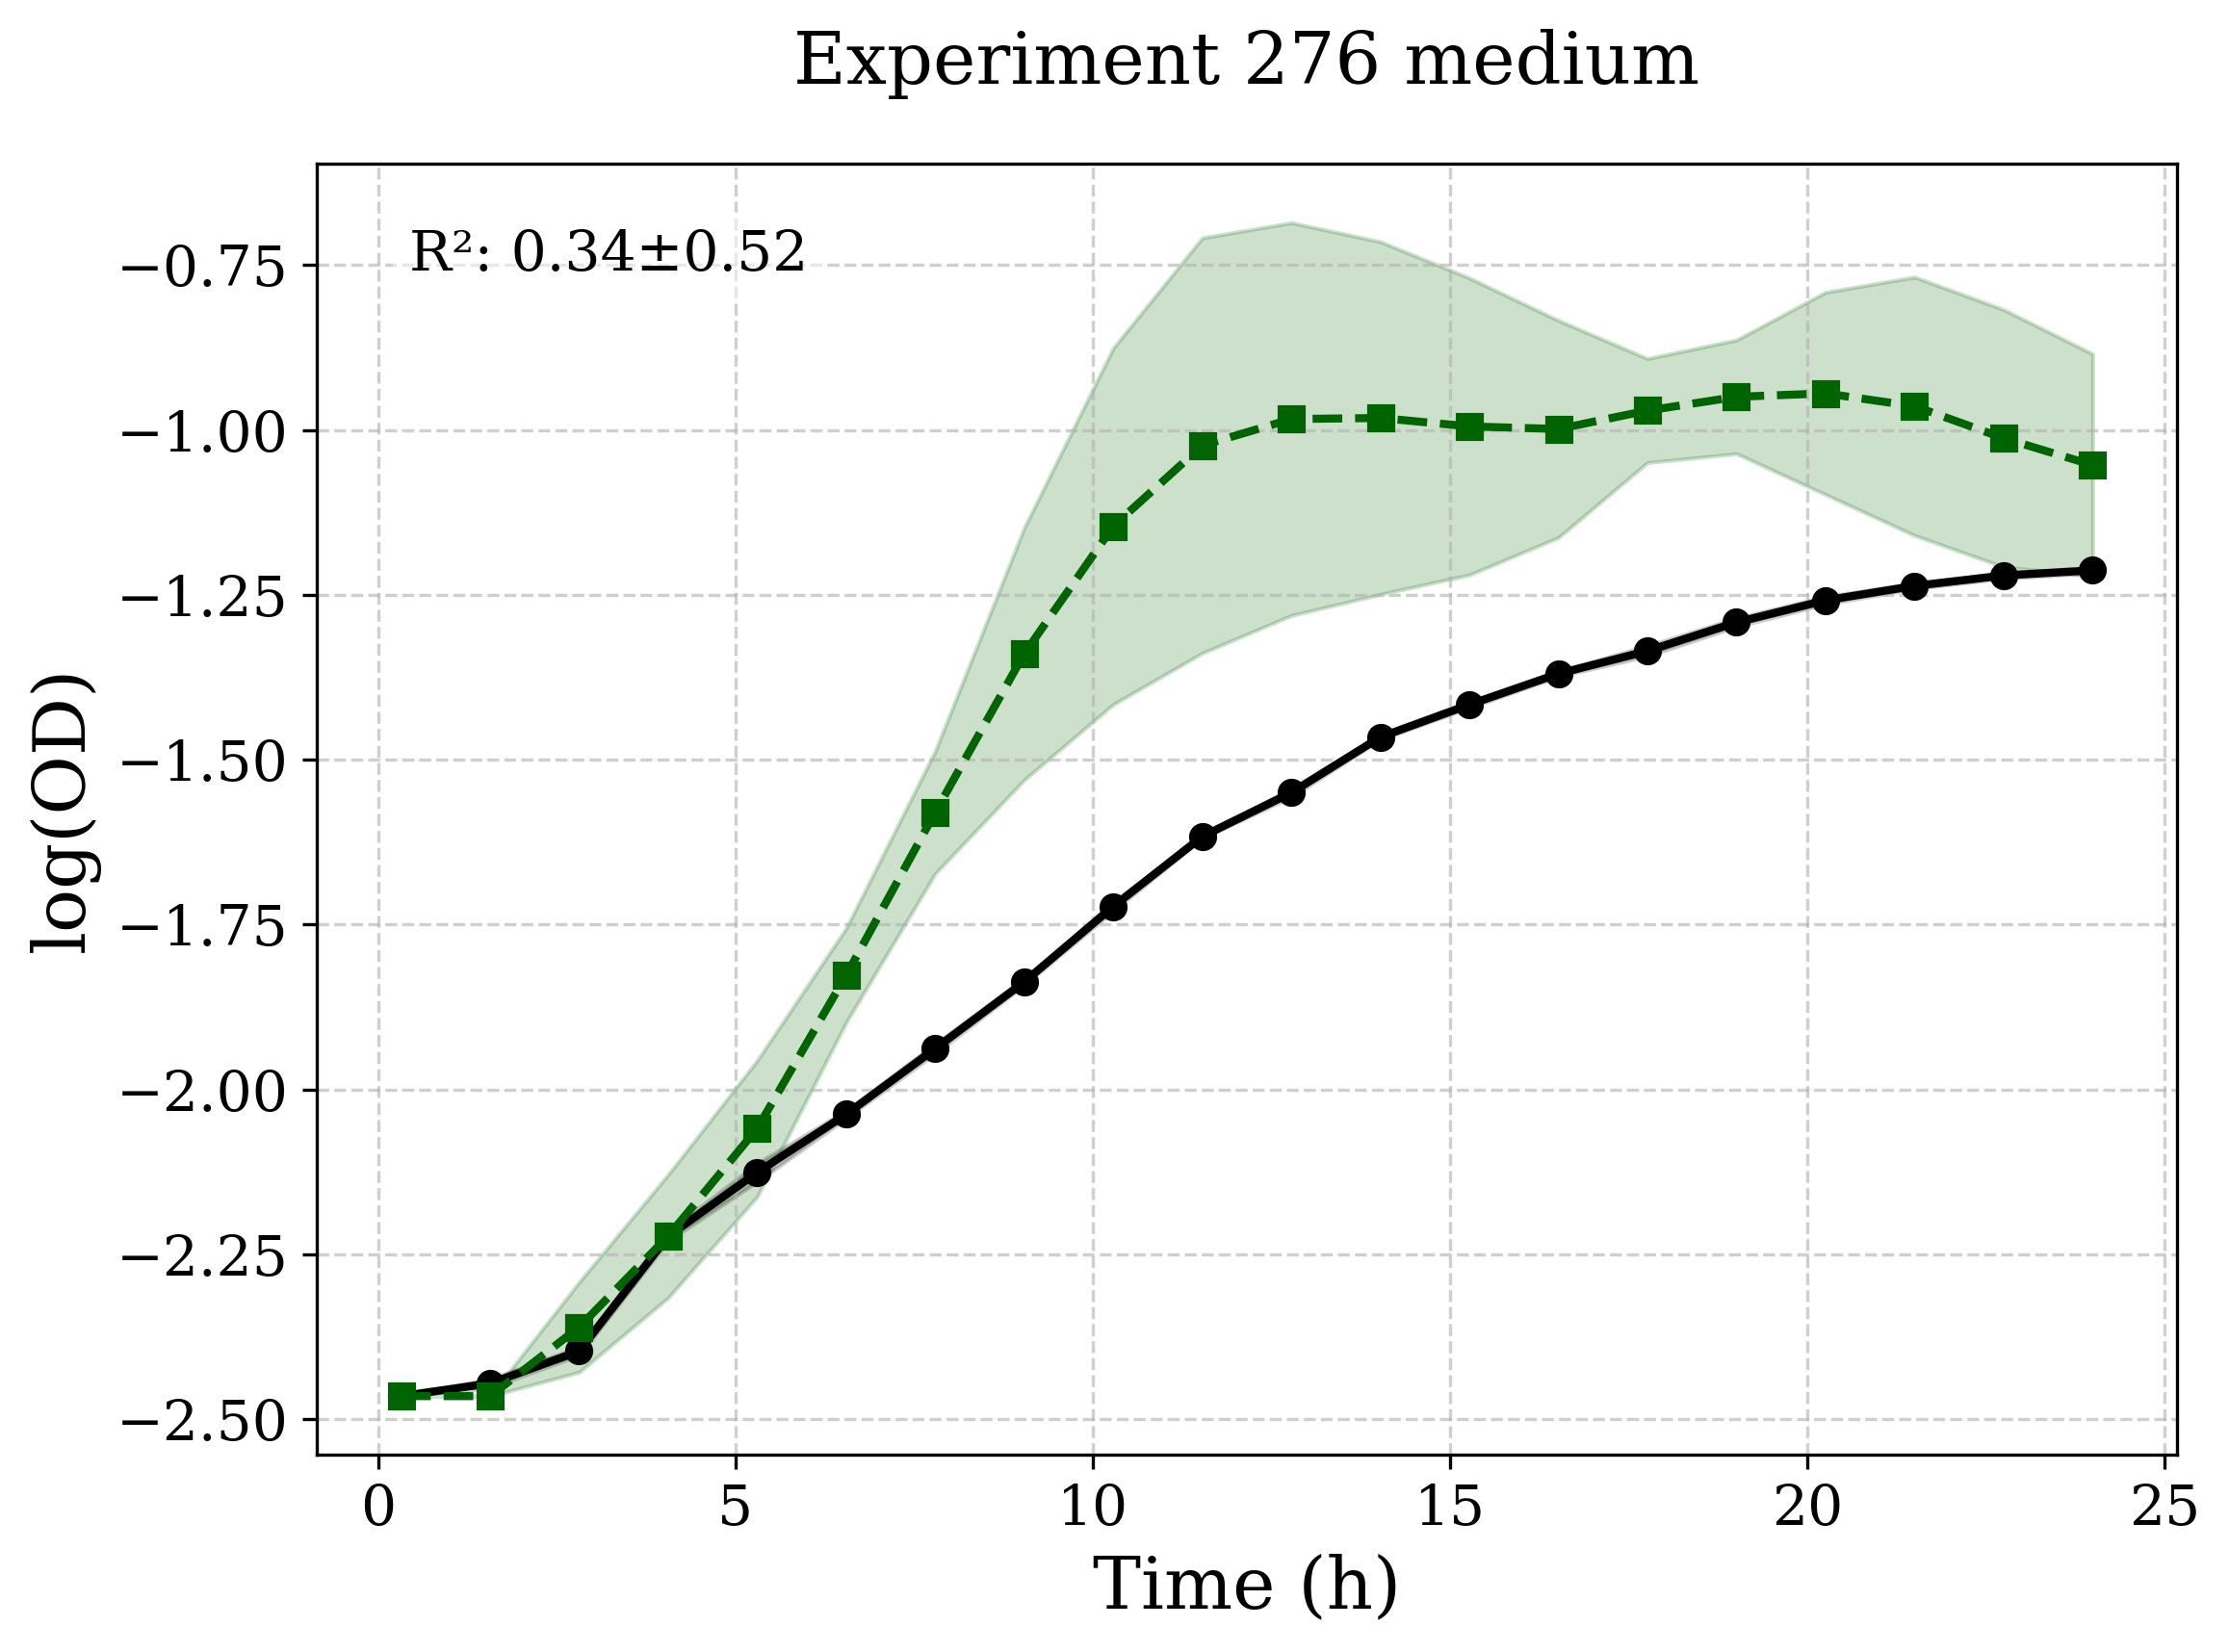

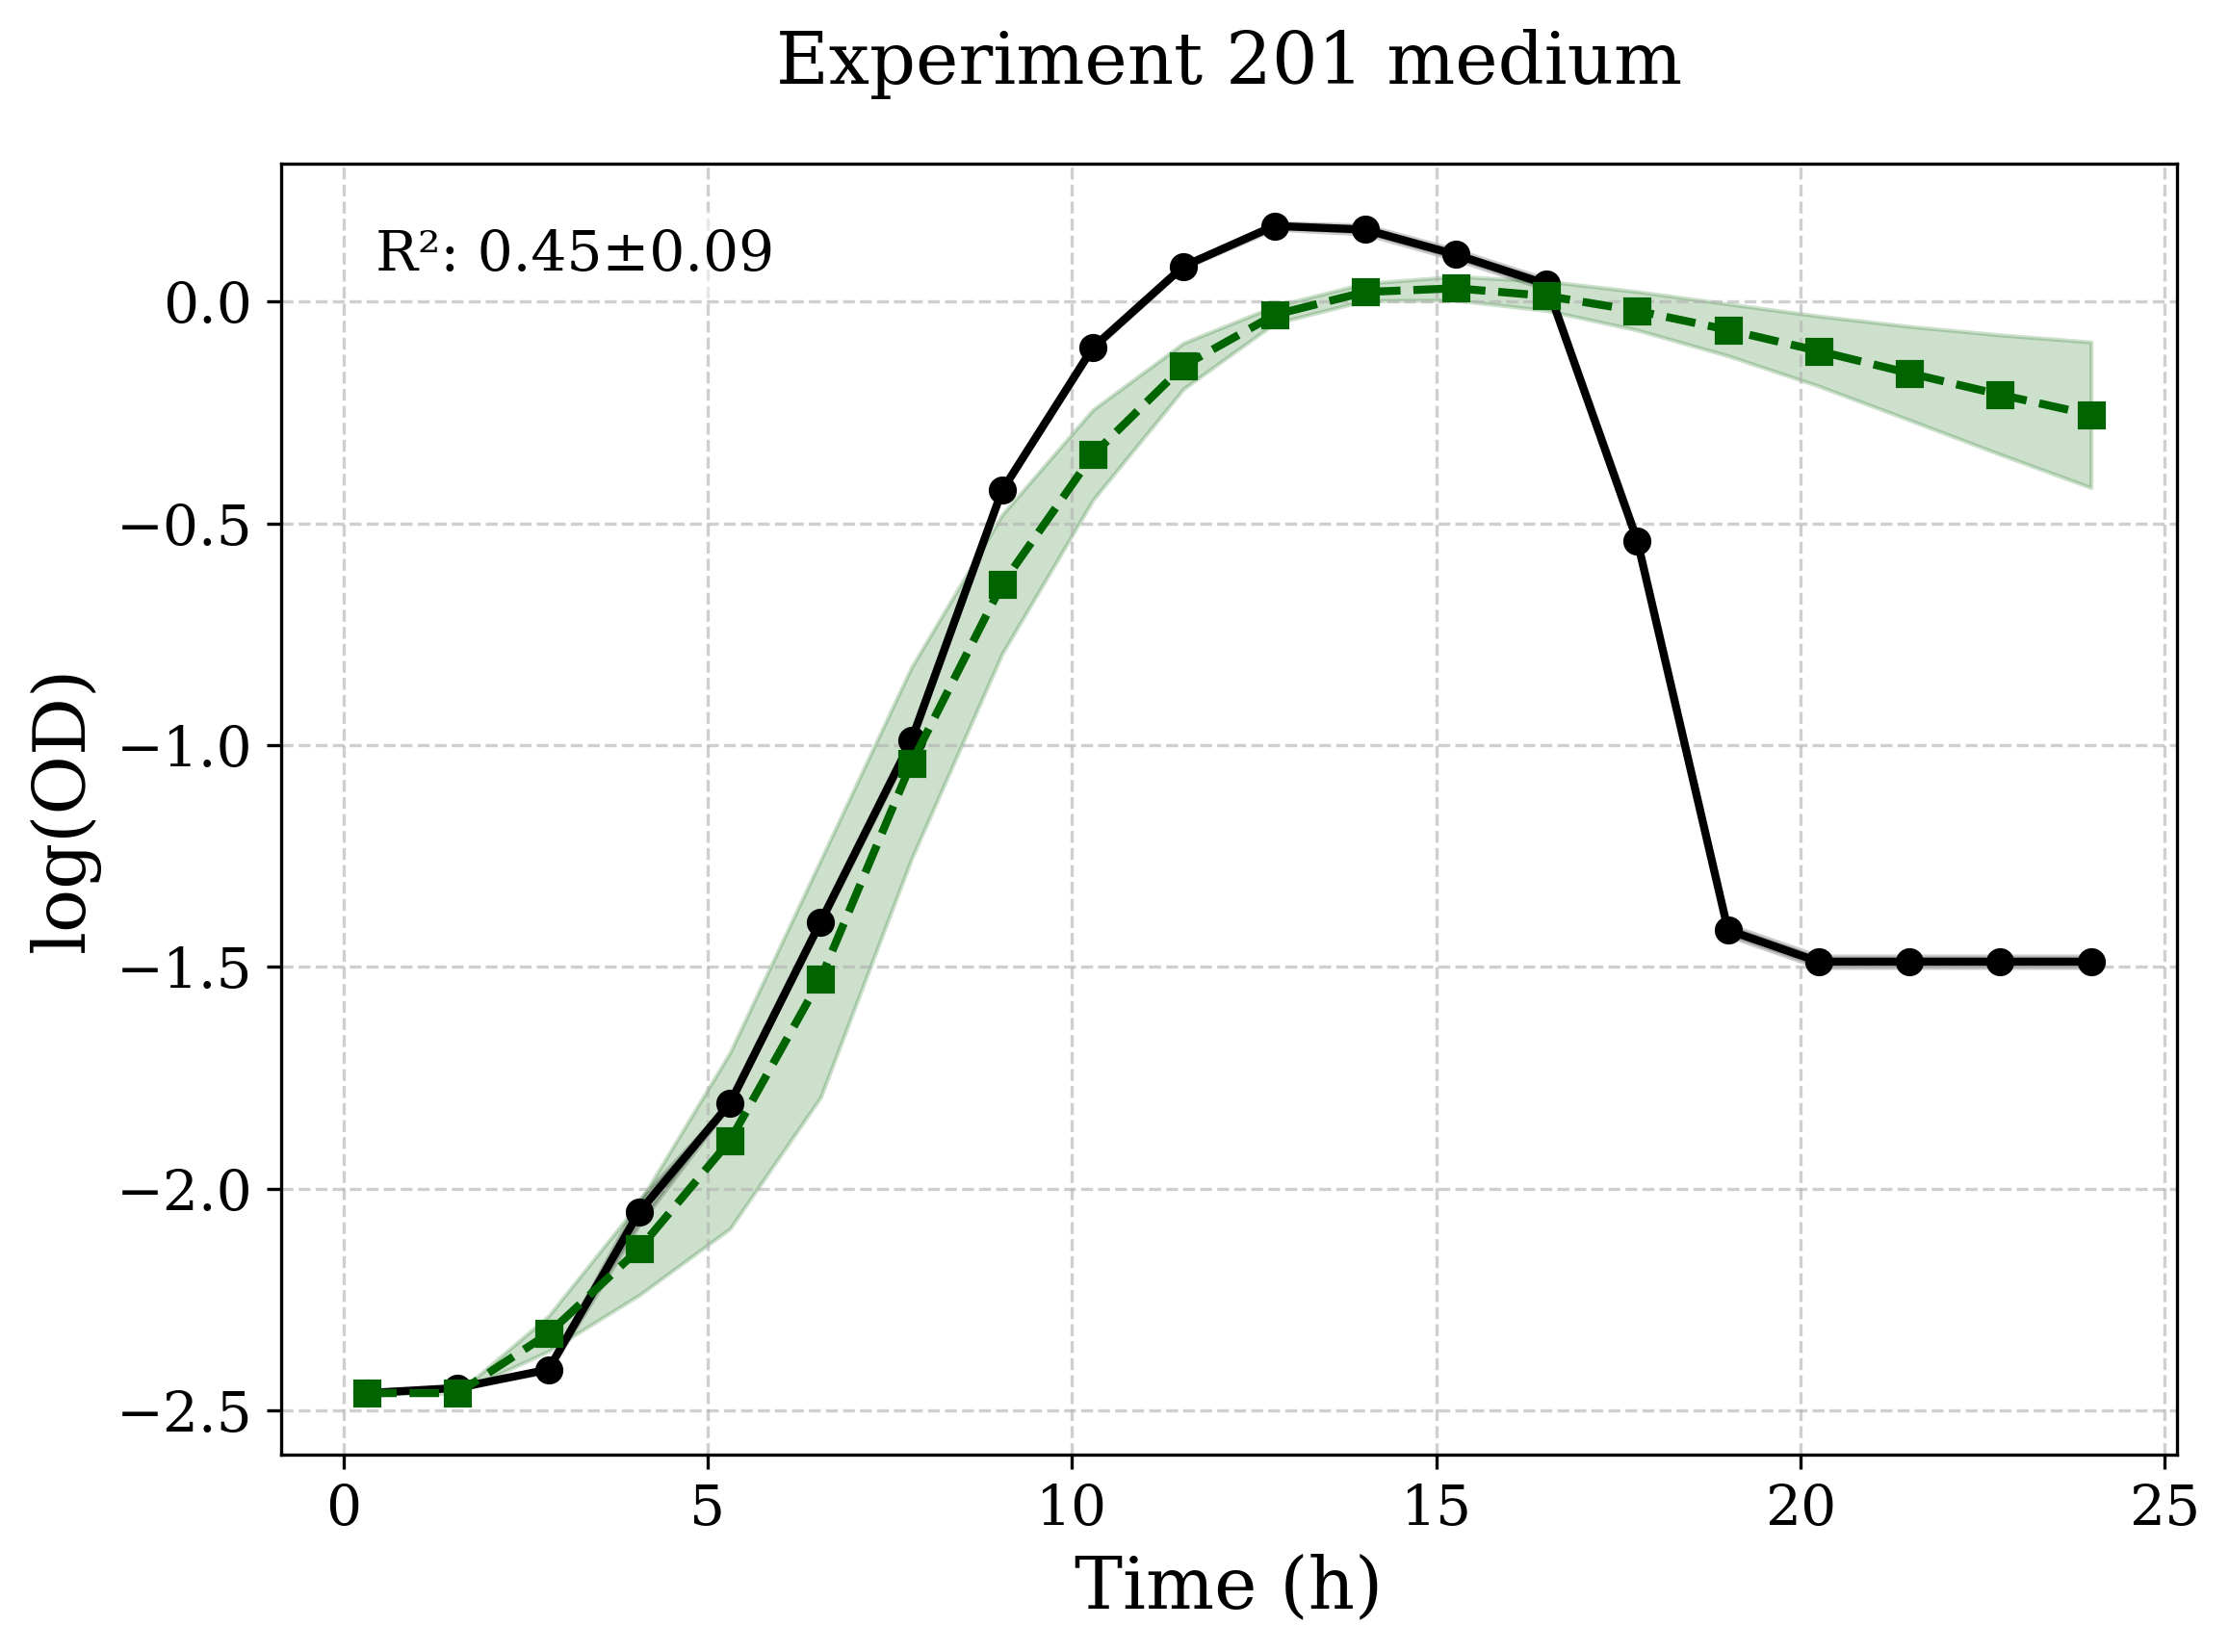

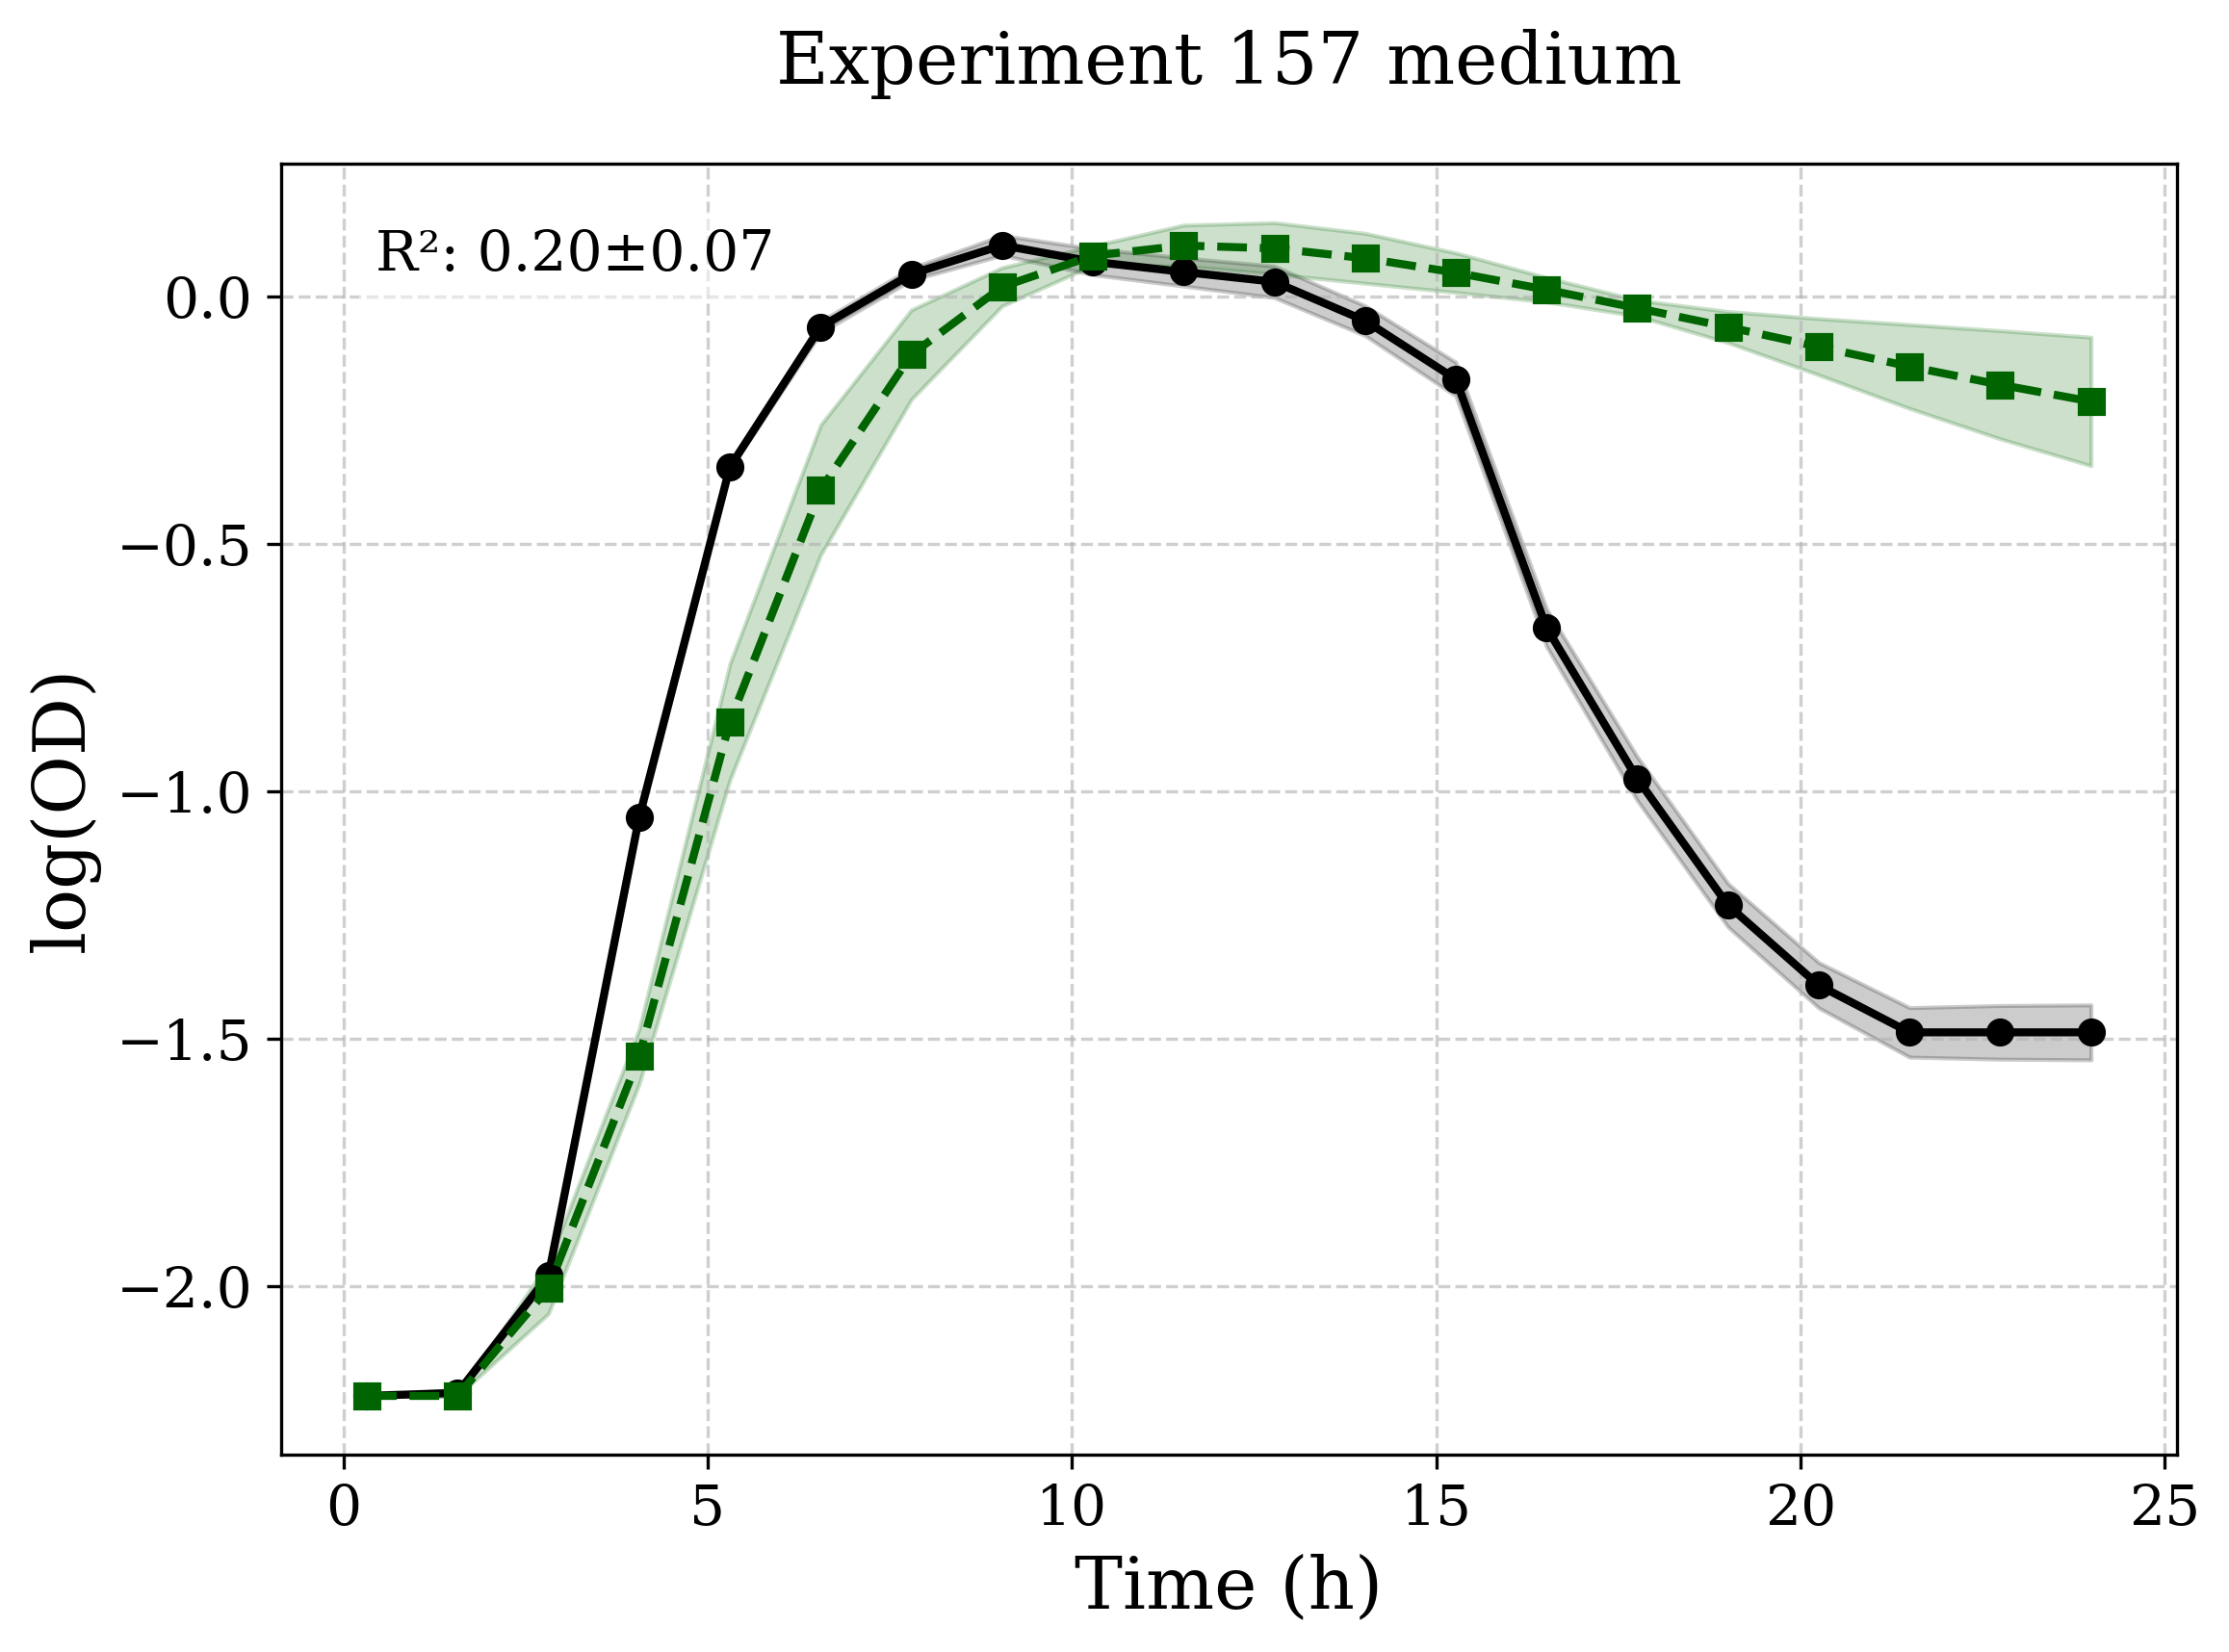

In [2]:
# E. coli

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sklearn
import utils
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
import utils
import data
import model
import plot

train_test_split ='medium'  # 'forecast' or 'medium'
folder = './'
file_name = 'M28_OD_20' # 'putida_OD_81' or 'M28_OD_20'
N_iter = 3
OD = True # when True biomass concentration transformed in OD
plt =  'growth' # 'growth' or 'substrate'
run_name = f'{file_name}_{train_test_split}'
metabolite_ids = [ # for old file
    'glc__D_e', 'xyl__D_e', 'succ_e', 'ala__L_e', 'arg__L_e', 'asn__L_e', 'asp__L_e',
    'cys__L_e', 'glu__L_e', 'gln__L_e', 'gly_e', 'his__L_e', 'ile__L_e', 'leu__L_e',
    'lys__L_e', 'met__L_e', 'phe__L_e', 'pro__L_e', 'ser__L_e', 'thr__L_e', 'trp__L_e',
    'tyr__L_e', 'val__L_e', 'ade_e', 'gua_e', 'csn_e', 'ura_e', 'thymd_e', 'BIOMASS'
]

# Load
val_array = np.loadtxt(f'{folder}model/{run_name}_val_array.txt', dtype=float)
val_dev = np.loadtxt(f'{folder}model/{run_name}_val_dev.txt', dtype=float)
val_ids = np.loadtxt(f'{folder}model/{run_name}_val_ids.txt', dtype=int)
if val_array is None:
    raise ValueError(f'Validation file not found: {folder}model/{run_name}_val_array.txt')

# Predict
Pred, Ref, Pred_bio, Ref_bio = {}, {}, {}, {}
for i in range(N_iter):
    mdl_name = f'{folder}model/{run_name}_{str(i)}'
    mdl = model.MetabolicModel.load_model(model_name=mdl_name, metabolite_ids=metabolite_ids, verbose=False)
    pred, ref = model.predict_on_val_data(mdl, val_array, verbose=False) # 1, 86, 157
    pred, ref = np.asarray(pred), np.asarray(ref)
    Pred[i], Ref[i] = pred, ref
Pred , Ref = np.asarray(list(Pred.values())), np.asarray(list(Ref.values()))
R2, R2dev = utils.r2_growth_curve_with_std(Pred, Ref, OD=OD)

print(f'Model: {run_name}  R2 = {np.mean(R2):.2f}±{np.std(R2):.2f} R2dev = {np.mean(R2dev):.2f} Median = {np.median(R2):.2f}')
title = f"R2 Histogram {train_test_split}"
plot.plot_similarity_distribution(title, R2, save="./figure")

# Plot
if plt == 'growth':
    plot.plot_predicted_reference_growth_curve(
    times=mdl.times,
    Pred=Pred, Ref=Ref, val_dev=val_dev,
    OD=OD,R2=R2,R2dev=R2dev,
    train_time_steps=mdl.train_time_steps if hasattr(mdl, "train_time_steps") else 0,
    experiment_ids=list(val_ids),
    run_name=run_name,
    train_test_split=train_test_split,
    R2min=0, R2max=0.5, # range you want the plots to be printed
    save="./figure"
    )
elif plt == 'substrate':
    plot.plot_predicted_biomass_and_substrate(
    mdl.times, Pred,
    experiment_ids=list(val_ids),
    metabolite_ids=list(mdl.metabolite_ids),
    run_name=run_name,
    train_test_split=train_test_split,
    save="./figure"
    )


Model: putida_OD_81_medium  R2 = 0.90±0.15 Median = 0.97


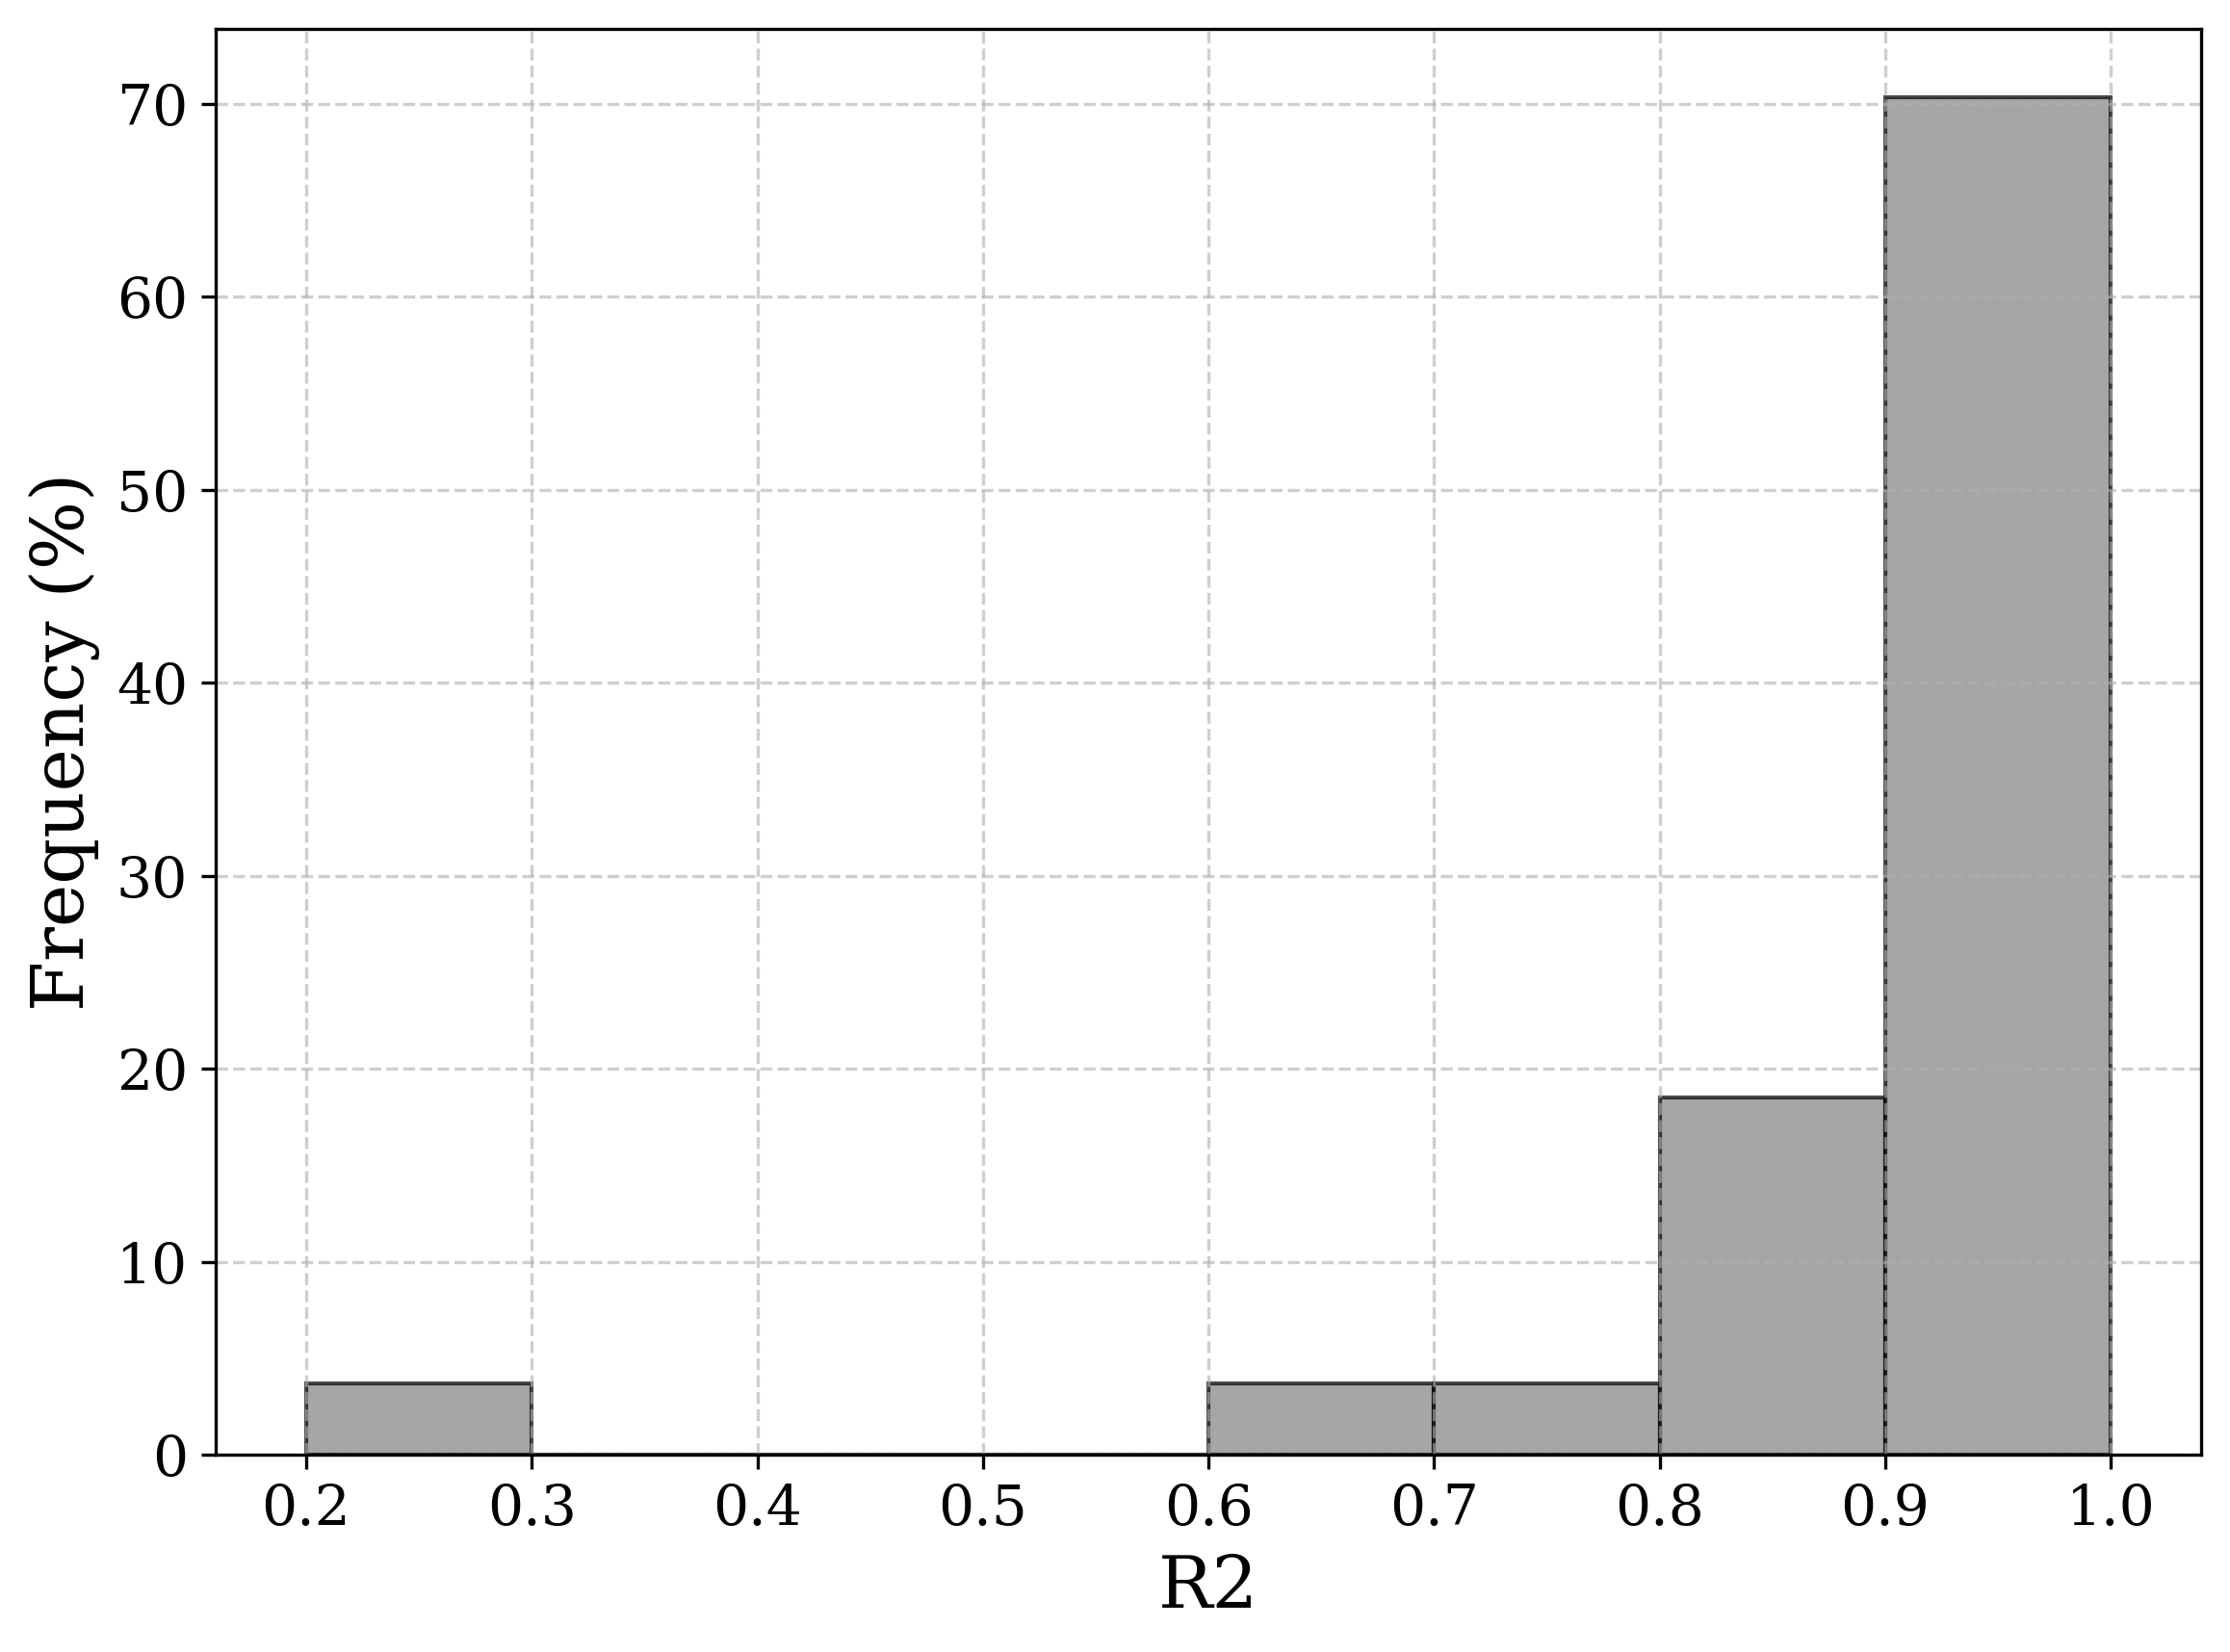

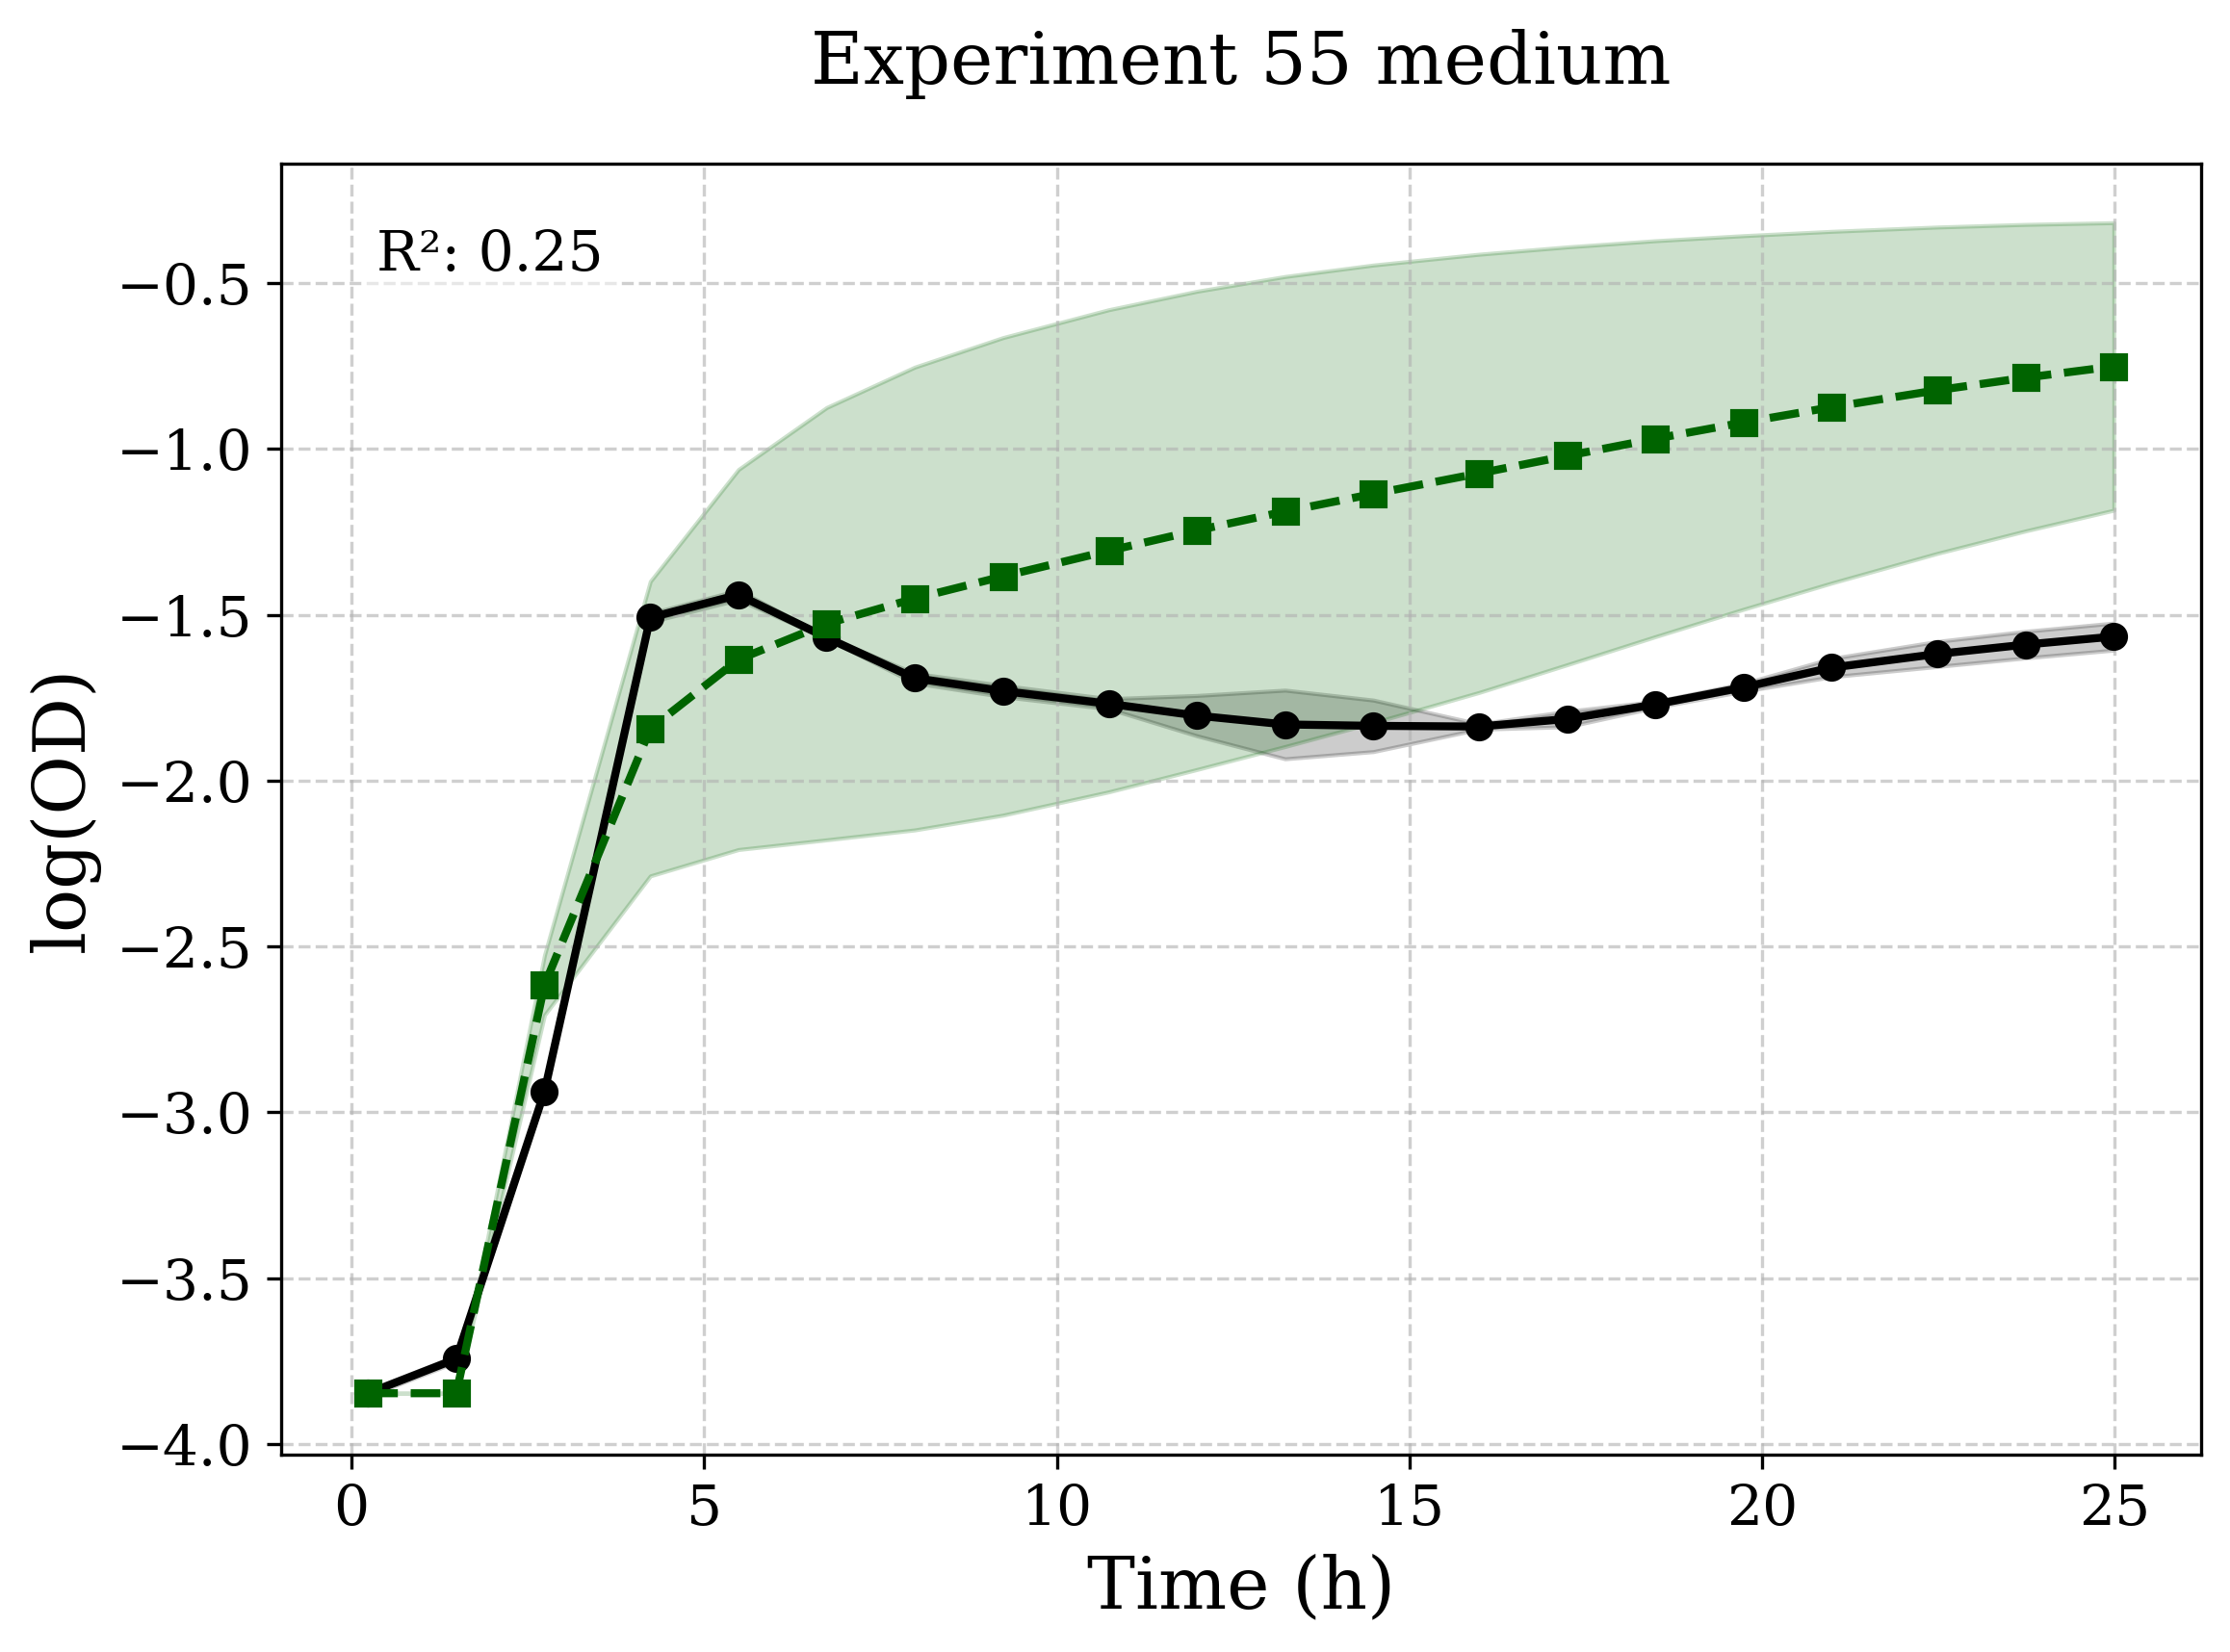

In [3]:
# P. putida

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sklearn
import utils
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
import utils
import data
import model
import plot

train_test_split = 'medium'   # 'forecast' or 'medium'
folder = './'
file_name = 'putida_OD_81' # 'putida_OD_81' or 'M28_OD_20
N_iter = 3
OD = True # when True biomass concentration transformed in OD
plt =  'growth' # 'growth' or 'substrate'
run_name = f'{file_name}_{train_test_split}'

# Load
val_array = np.loadtxt(f'{folder}model/{run_name}_val_array.txt', dtype=float)
val_dev = np.loadtxt(f'{folder}model/{run_name}_val_dev.txt', dtype=float)
val_ids = np.loadtxt(f'{folder}model/{run_name}_val_ids.txt', dtype=int)
if val_array is None:
    raise ValueError(f'Validation file not found: {folder}model/{run_name}_val_array.txt')

# Predict
Pred, Ref, Pred_bio, Ref_bio = {}, {}, {}, {}
for i in range(N_iter):
    mdl_name = f'{folder}model/{run_name}_{str(i)}'
    mdl = model.MetabolicModel.load_model(model_name=mdl_name, verbose=False)
    pred, ref = model.predict_on_val_data(mdl, val_array, verbose=False) # 1, 86, 157
    pred, ref = np.asarray(pred), np.asarray(ref)
    Pred[i], Ref[i] = pred, ref
Pred , Ref = np.asarray(list(Pred.values())), np.asarray(list(Ref.values()))
R2 = utils.r2_growth_curve(Pred, Ref, OD=OD)

print(f'Model: {run_name}  R2 = {np.mean(R2):.2f}±{np.std(R2):.2f} Median = {np.median(R2):.2f}')
title = f"R2 Histogram {train_test_split}"
plot.plot_similarity_distribution(title, R2, save="./figure")

# Plot
if plt == 'growth':
    plot.plot_predicted_reference_growth_curve(
    times=mdl.times,
    Pred=Pred, Ref=Ref, val_dev=val_dev,
    OD=OD,R2=R2,
    train_time_steps=mdl.train_time_steps if hasattr(mdl, "train_time_steps") else 0,
    experiment_ids=list(val_ids),
    run_name=run_name,
    train_test_split=train_test_split,
    R2min=0, R2max=0.5, # range you want the plots to be printed
    save="./figure"
    )
elif plt == 'substrate':
    plot.plot_predicted_biomass_and_substrate(
    mdl.times, Pred,
    experiment_ids=list(val_ids),
    metabolite_ids=list(mdl.metabolite_ids),
    run_name=run_name,
    train_test_split=train_test_split,
    save="./figure"
    )


# dAMN with Millard dataset

## Train and predict acetate overflow or glucose consumption

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[parse_training_mode] mode='concentration-ACE' kept as concentration mode.
[process_data] detected concentration mode (Millard-style GLC/ACE/BIOMASS)
Transport[1,106] = 1.0  EX_ac_e_o ac_e
Transport[2,2668] = 1.0  BIOMASS
Transport[1,2761] = -1.0  EX_ac_e_i ac_e
Transport[0,2805] = -1.0  EX_glc__D_e_i glc__D_e
Transport shape: (3, 3682), Stoichiometry shape: (1877, 3682)
Number of metabolites (k): 3, Number of fluxes (n): 3682
Train shape: (1, 39)
Val shape: (1, 39)
-----------------------------MetabolicModel-----------------------------
times: 0.00, 0.75, ..., 4.58
metabolite_ids: ['glc__D_e', 'ac_e', 'BIOMASS']
Total time step: 13
Train time step: 13
dt: [2.2727277 1.5151519 1.0000004 1.030303  1.0000004 1.        1.0303037
 1.        1.        1.0303037 1.        1.       ]
Transport: (3, 3682)
Stoichiometry: (1877, 3682)
n: 3682
k: 3
Reaction ids: 3682
Biomass id: BIOMASS_Ec_iML1515_core_75p37M
Biomas

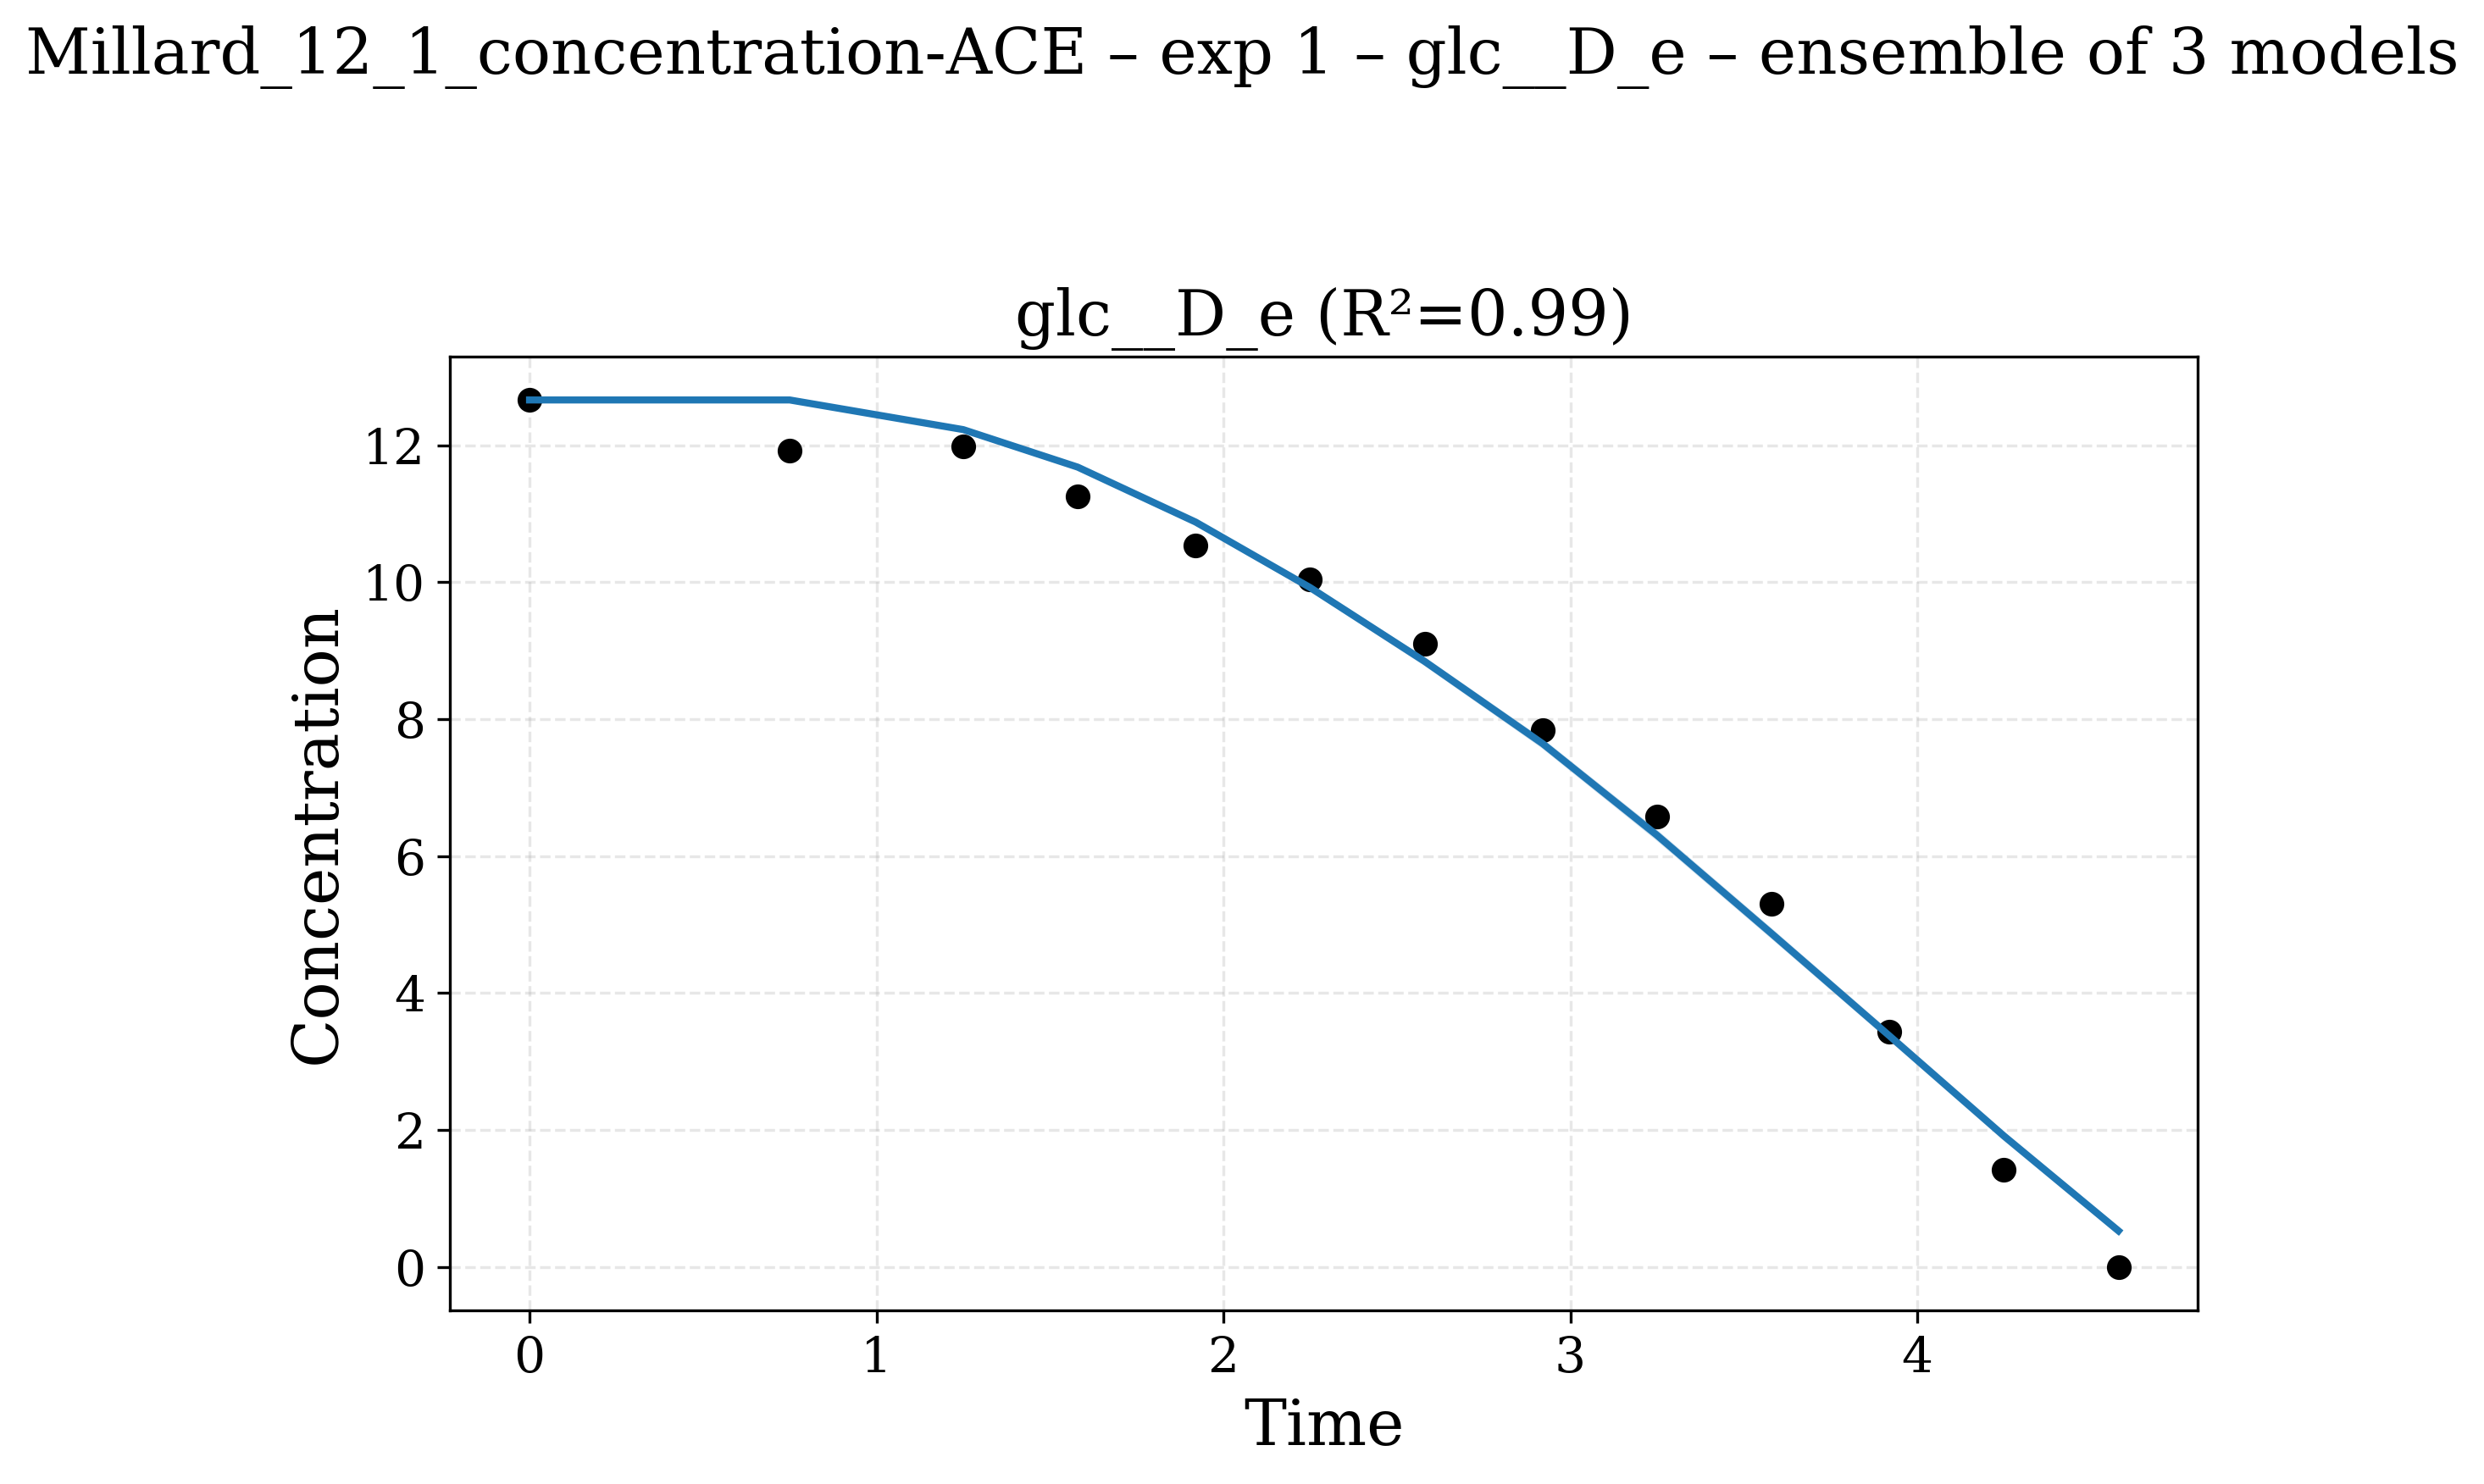

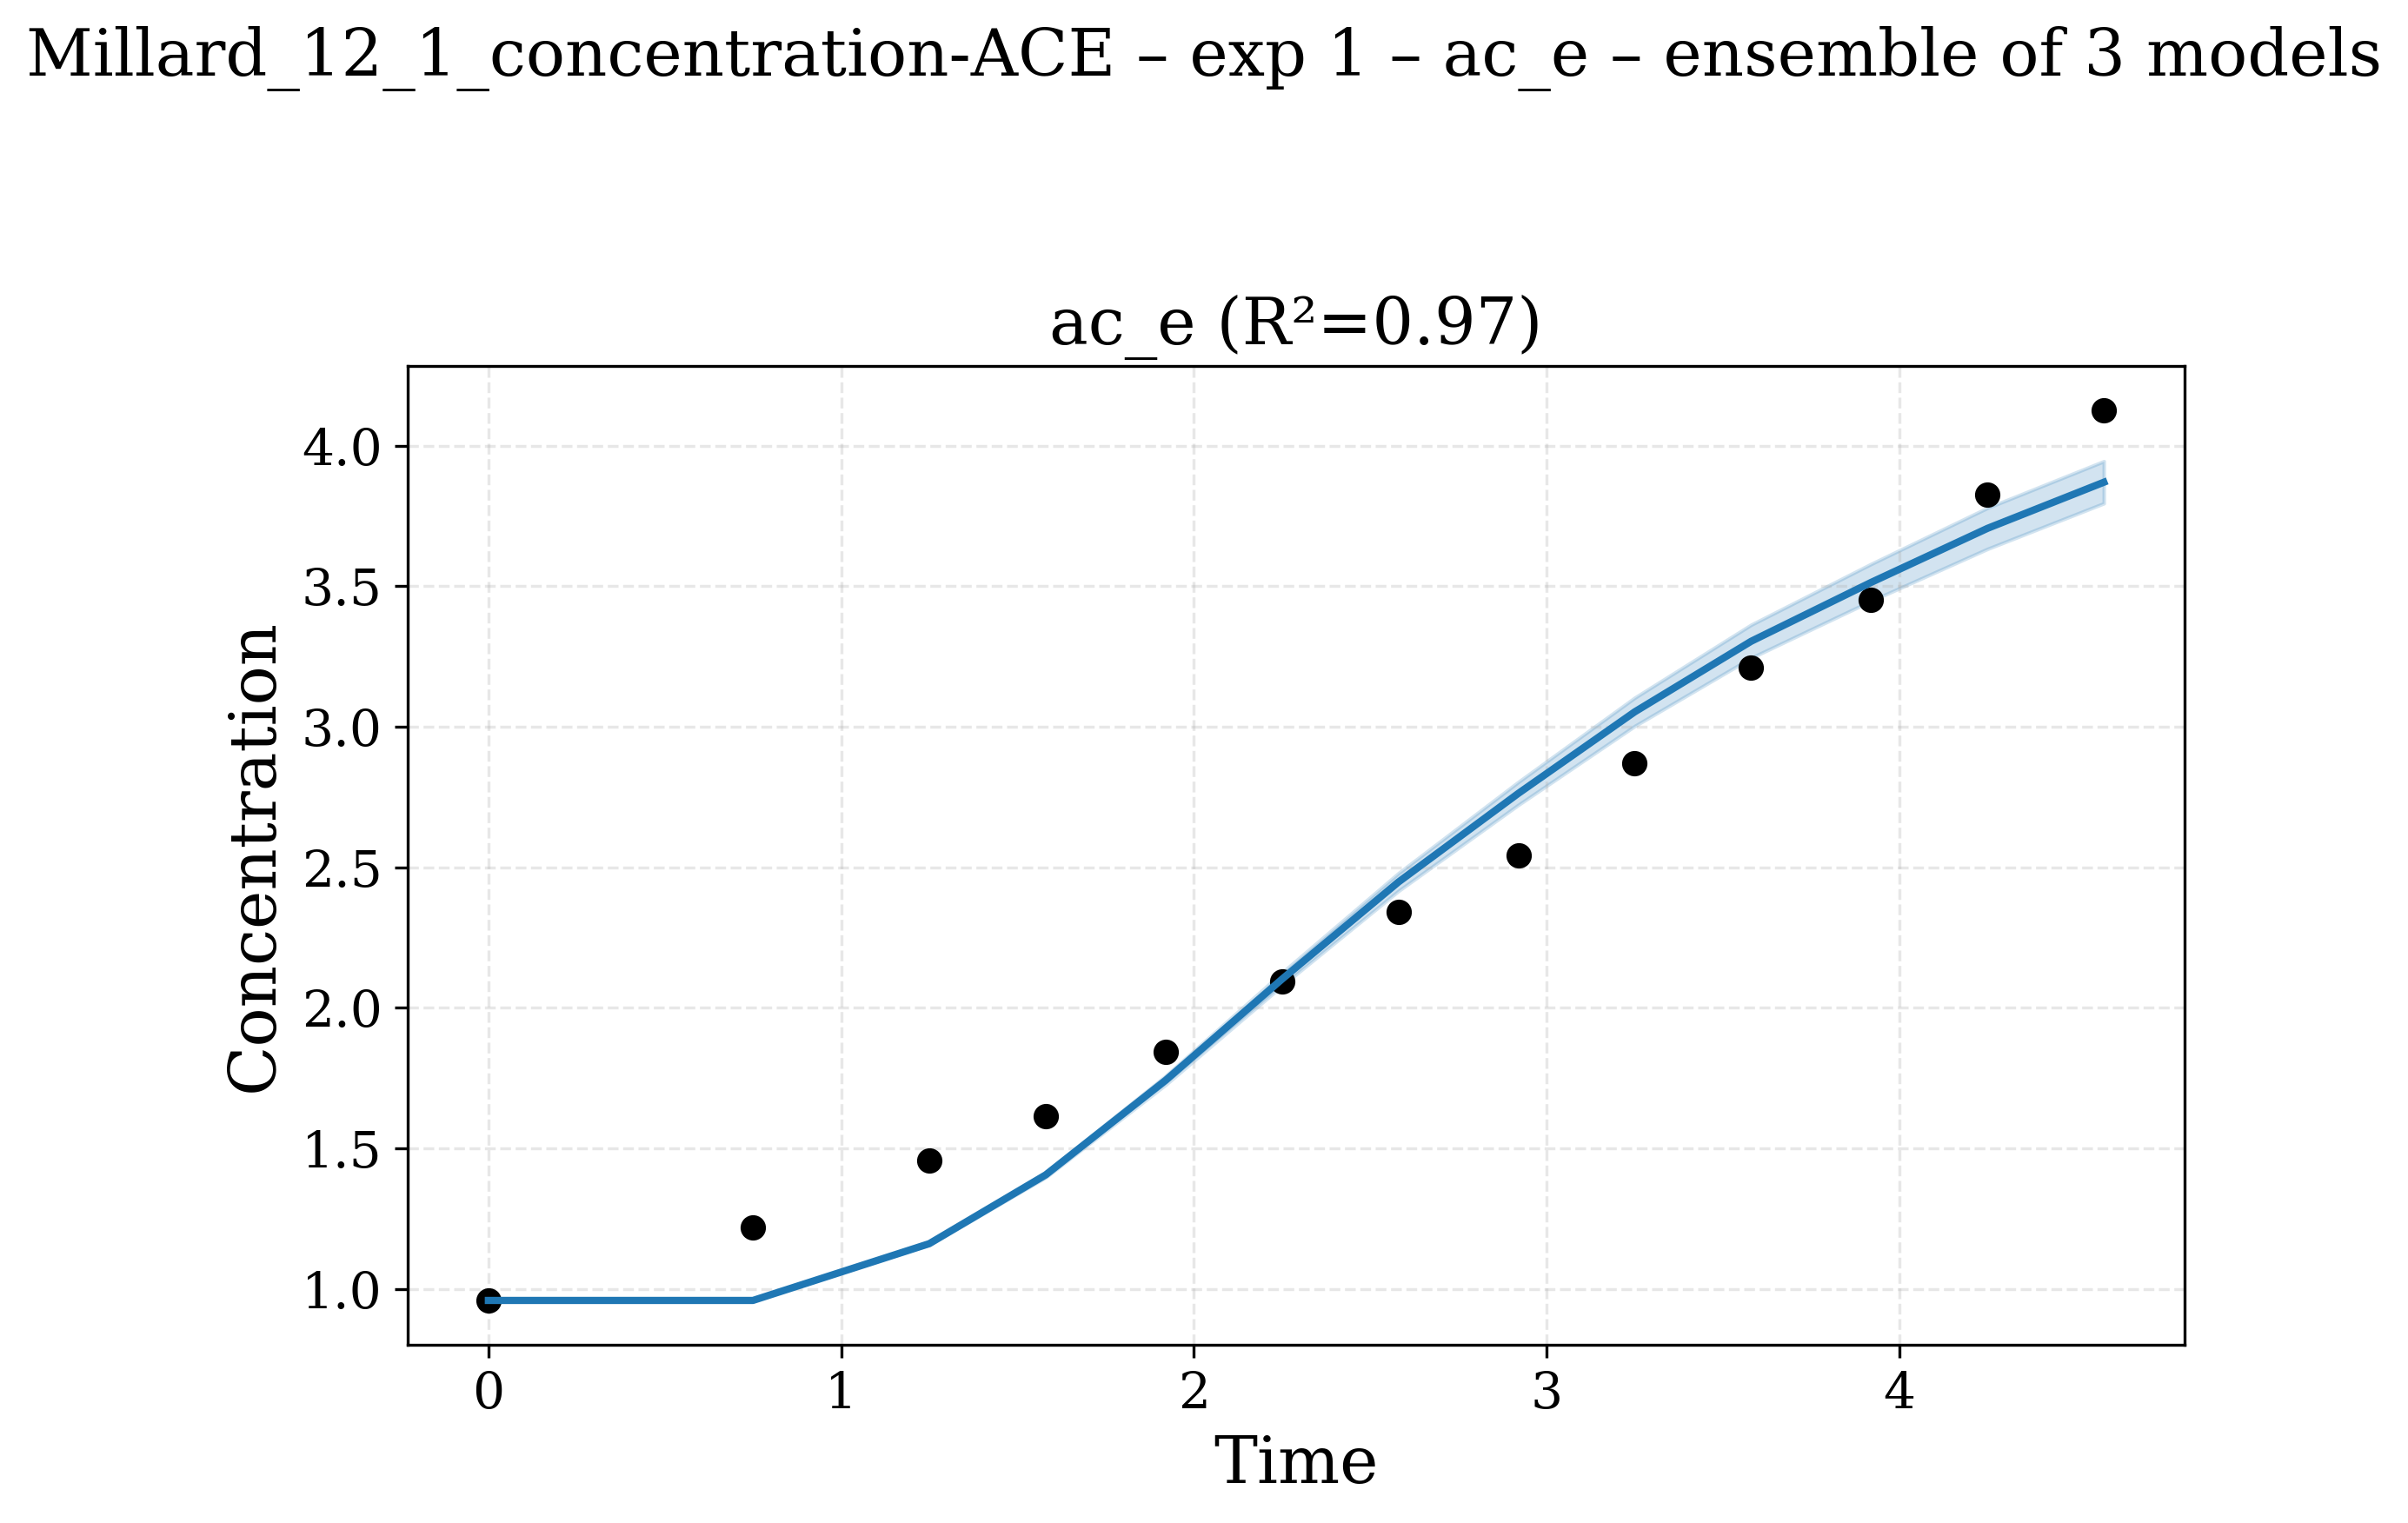

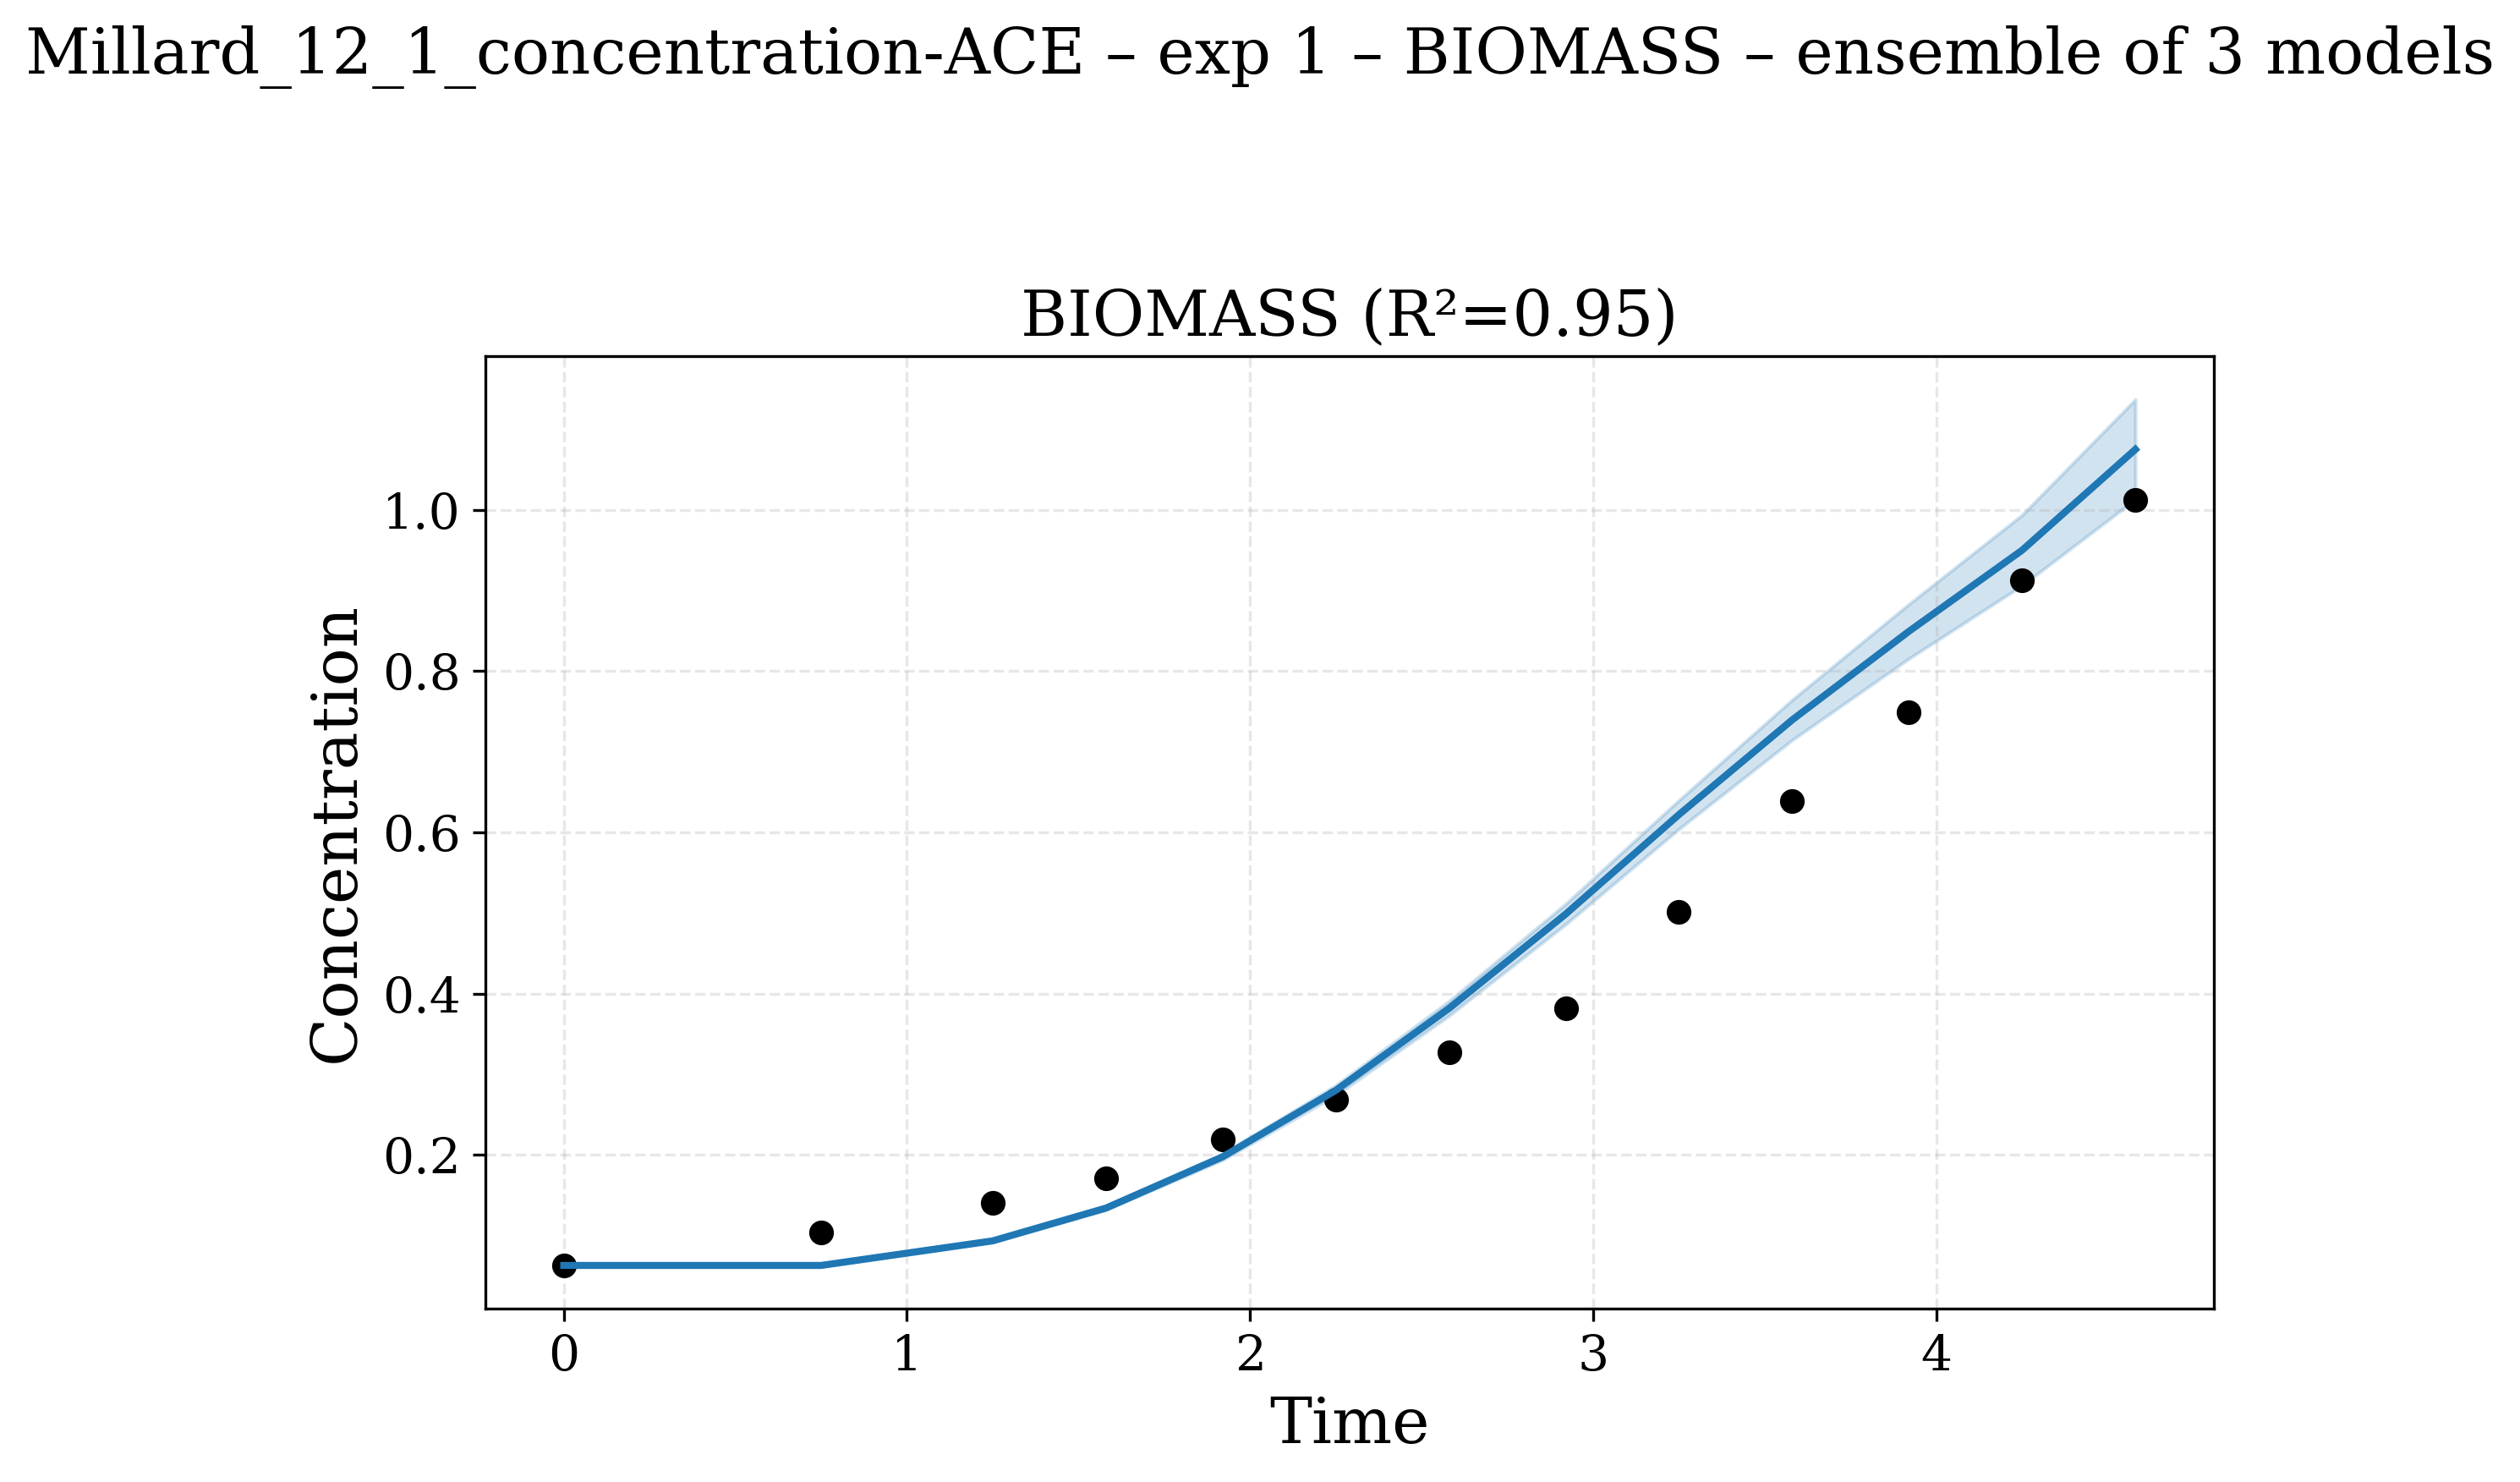

In [4]:
# Predict acetate overflow using glucose and biomass data. 
# or predict glucose consumption using acetate and biomass data. 
# Cell run fast - The models are not saved

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils
import data
import model
import plot
print('Physical GPUs:', tf.config.list_physical_devices('GPU'))

# -----------------------------
# Config
# -----------------------------
training_mode = 'concentration-ACE' # 'concentration-ACE' or 'concentration-GLC'
train_test_split = data.parse_training_mode(
    mode_str=training_mode,
    default_split="forecast",
    verbose=True
)
(UB_in, UB_out) = (0, 0.3) if training_mode == 'concentration-ACE' else (1.5, 0)
folder    = './'
file_name = 'Millard_12_1'

media_file       = folder + 'data/' + 'Millard_media.csv'
od_file          = folder + 'data/' + file_name + '.csv'
cobra_model_file = folder + 'data/' + 'iML1515_duplicated.xml'
biomass_rxn_id   = 'BIOMASS_Ec_iML1515_core_75p37M'

run_name = f'{file_name}_{training_mode}'

# Hyperparameters
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
hidden_layers_lag  = [50]
hidden_layers_flux = [500]
num_epochs = 1000
batch_size = 5
patience   = 100
N_models   = 3     # train on independent models
loss_weight = [0.01, 1, 1, 1] # order: SV, negV, C, dropC
loss_decay  = [0, 0.0, 0.25, 0] # order: SV, negV, C, dropC

# -----------------------------
# 1) Build data + template model
# -----------------------------
template_mdl, train_array, train_dev, val_array, val_dev, val_ids = model.create_model_train_val(
    media_file, od_file,
    cobra_model_file,
    biomass_rxn_id,
    x_fold=1,
    hidden_layers_lag=hidden_layers_lag,
    hidden_layers_flux=hidden_layers_flux,
    dropout_rate=0.2,
    loss_weight=loss_weight,
    loss_decay=loss_decay,
    UB_in=UB_in, UB_out=UB_out,
    verbose=True,
    train_test_split=train_test_split
)

metabolite_ids = list(template_mdl.metabolite_ids)
val_ids = np.array(val_ids, ndmin=1)

# -----------------------------
# 2) Train N_models independent models
# -----------------------------
Pred_list = []
Ref_list  = []
mdl = model.reset_model(template_mdl, verbose=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=280,
        decay_rate=0.9,
        staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
(train_losses, val_losses) = model.train_model(
        mdl,
        train_array,
        val_array=val_array,
        optimizer=optimizer,
        num_epochs=num_epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=False,
        train_test_split=train_test_split,
        x_fold=1
)

for m in range(N_models):
    print(f"================ Training Model {m+1}/{N_models} ================")
    (train_losses, val_losses) = model.train_model(
        mdl,
        train_array,
        val_array=val_array,
        optimizer=optimizer,
        num_epochs=num_epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=False,
        train_test_split=train_test_split,
        x_fold=1
    )
    pred, ref = model.predict_on_val_data(mdl, val_array, verbose=False)
    Pred_list.append(np.asarray(pred))  # (Z, T, k)
    Ref_list.append(np.asarray(ref))    # (Z, T, k)

Pred_arr = np.asarray(Pred_list)   # shape (N_models, Z, T, k)
Ref_arr  = np.asarray(Ref_list)    # shape (N_models, Z, T, k)

# Reference should be identical across models => keep the first
Ref = Ref_arr[0]                   # (Z, T, k)

# -----------------------------
# 3) Ensemble mean & std
# -----------------------------
Pred_mean = Pred_arr.mean(axis=0)  # (Z, T, k)
Pred_std  = Pred_arr.std(axis=0)   # (Z, T, k)

# -----------------------------
# 3b) R² for MEAN prediction vs reference
# -----------------------------
# Wrap mean prediction & ref with a fake "iteration" axis: (1, Z, T, k)
Pred_mean_single = Pred_mean[np.newaxis, ...]
Ref_single       = Ref[np.newaxis, ...]

R2_mat = utils.r2_concentrations_all(Pred_mean_single, Ref_single)  # shape (Z, k_met)

print("\nR² (mean prediction vs reference):")
for j, met in enumerate(metabolite_ids):
    vals = R2_mat[:, j]
    print(f"  {met:10s}: mean={np.nanmean(vals):.3f}, std={np.nanstd(vals):.3f}")

R2_flat = R2_mat.reshape(-1)
print(
    f"\nGlobal R² (mean prediction): "
    f"mean={np.nanmean(R2_flat):.3f} ± {np.nanstd(R2_flat):.3f}, "
    f"median={np.nanmedian(R2_flat):.3f}"
)

# -----------------------------
# 4) Plot mean ± std using plot.py helper
# -----------------------------
times = template_mdl.times  # or template_model.times depending on your variable name
plot.plot_ensemble_concentrations(
    times=times,
    Ref=Ref,
    Pred_mean=Pred_mean,
    Pred_std=Pred_std,
    metabolite_ids=metabolite_ids,
    val_ids=val_ids,
    run_name=run_name,
    time_cutoffs=9,   
    N_models=N_models,
    R2_mat=R2_mat,
    save_dir="./figure"
)


## Train and forecast glucose acetate consumption switch

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[parse_training_mode] mode='concentration-ACE' kept as concentration mode.
[process_data] detected concentration mode (Millard-style GLC/ACE/BIOMASS)
Transport[1,106] = 1.0  EX_ac_e_o ac_e
Transport[2,2668] = 1.0  BIOMASS
Transport[1,2761] = -1.0  EX_ac_e_i ac_e
Transport[0,2805] = -1.0  EX_glc__D_e_i glc__D_e
Transport shape: (3, 3682), Stoichiometry shape: (1877, 3682)
Number of metabolites (k): 3, Number of fluxes (n): 3682
Train shape: (1, 120)
Val shape: (1, 120)
-----------------------------MetabolicModel-----------------------------
times: 0.00, 0.75, ..., 13.49
metabolite_ids: ['glc__D_e', 'ac_e', 'BIOMASS']
Total time step: 40
Train time step: 40
dt: [2.2727277 1.5151519 1.0000004 1.030303  1.0000004 1.        1.0303037
 1.        1.        1.0303037 1.        1.        1.        1.
 1.0000014 1.        1.        1.        1.        1.        1.0000014
 1.        1.        1.        1.        1. 

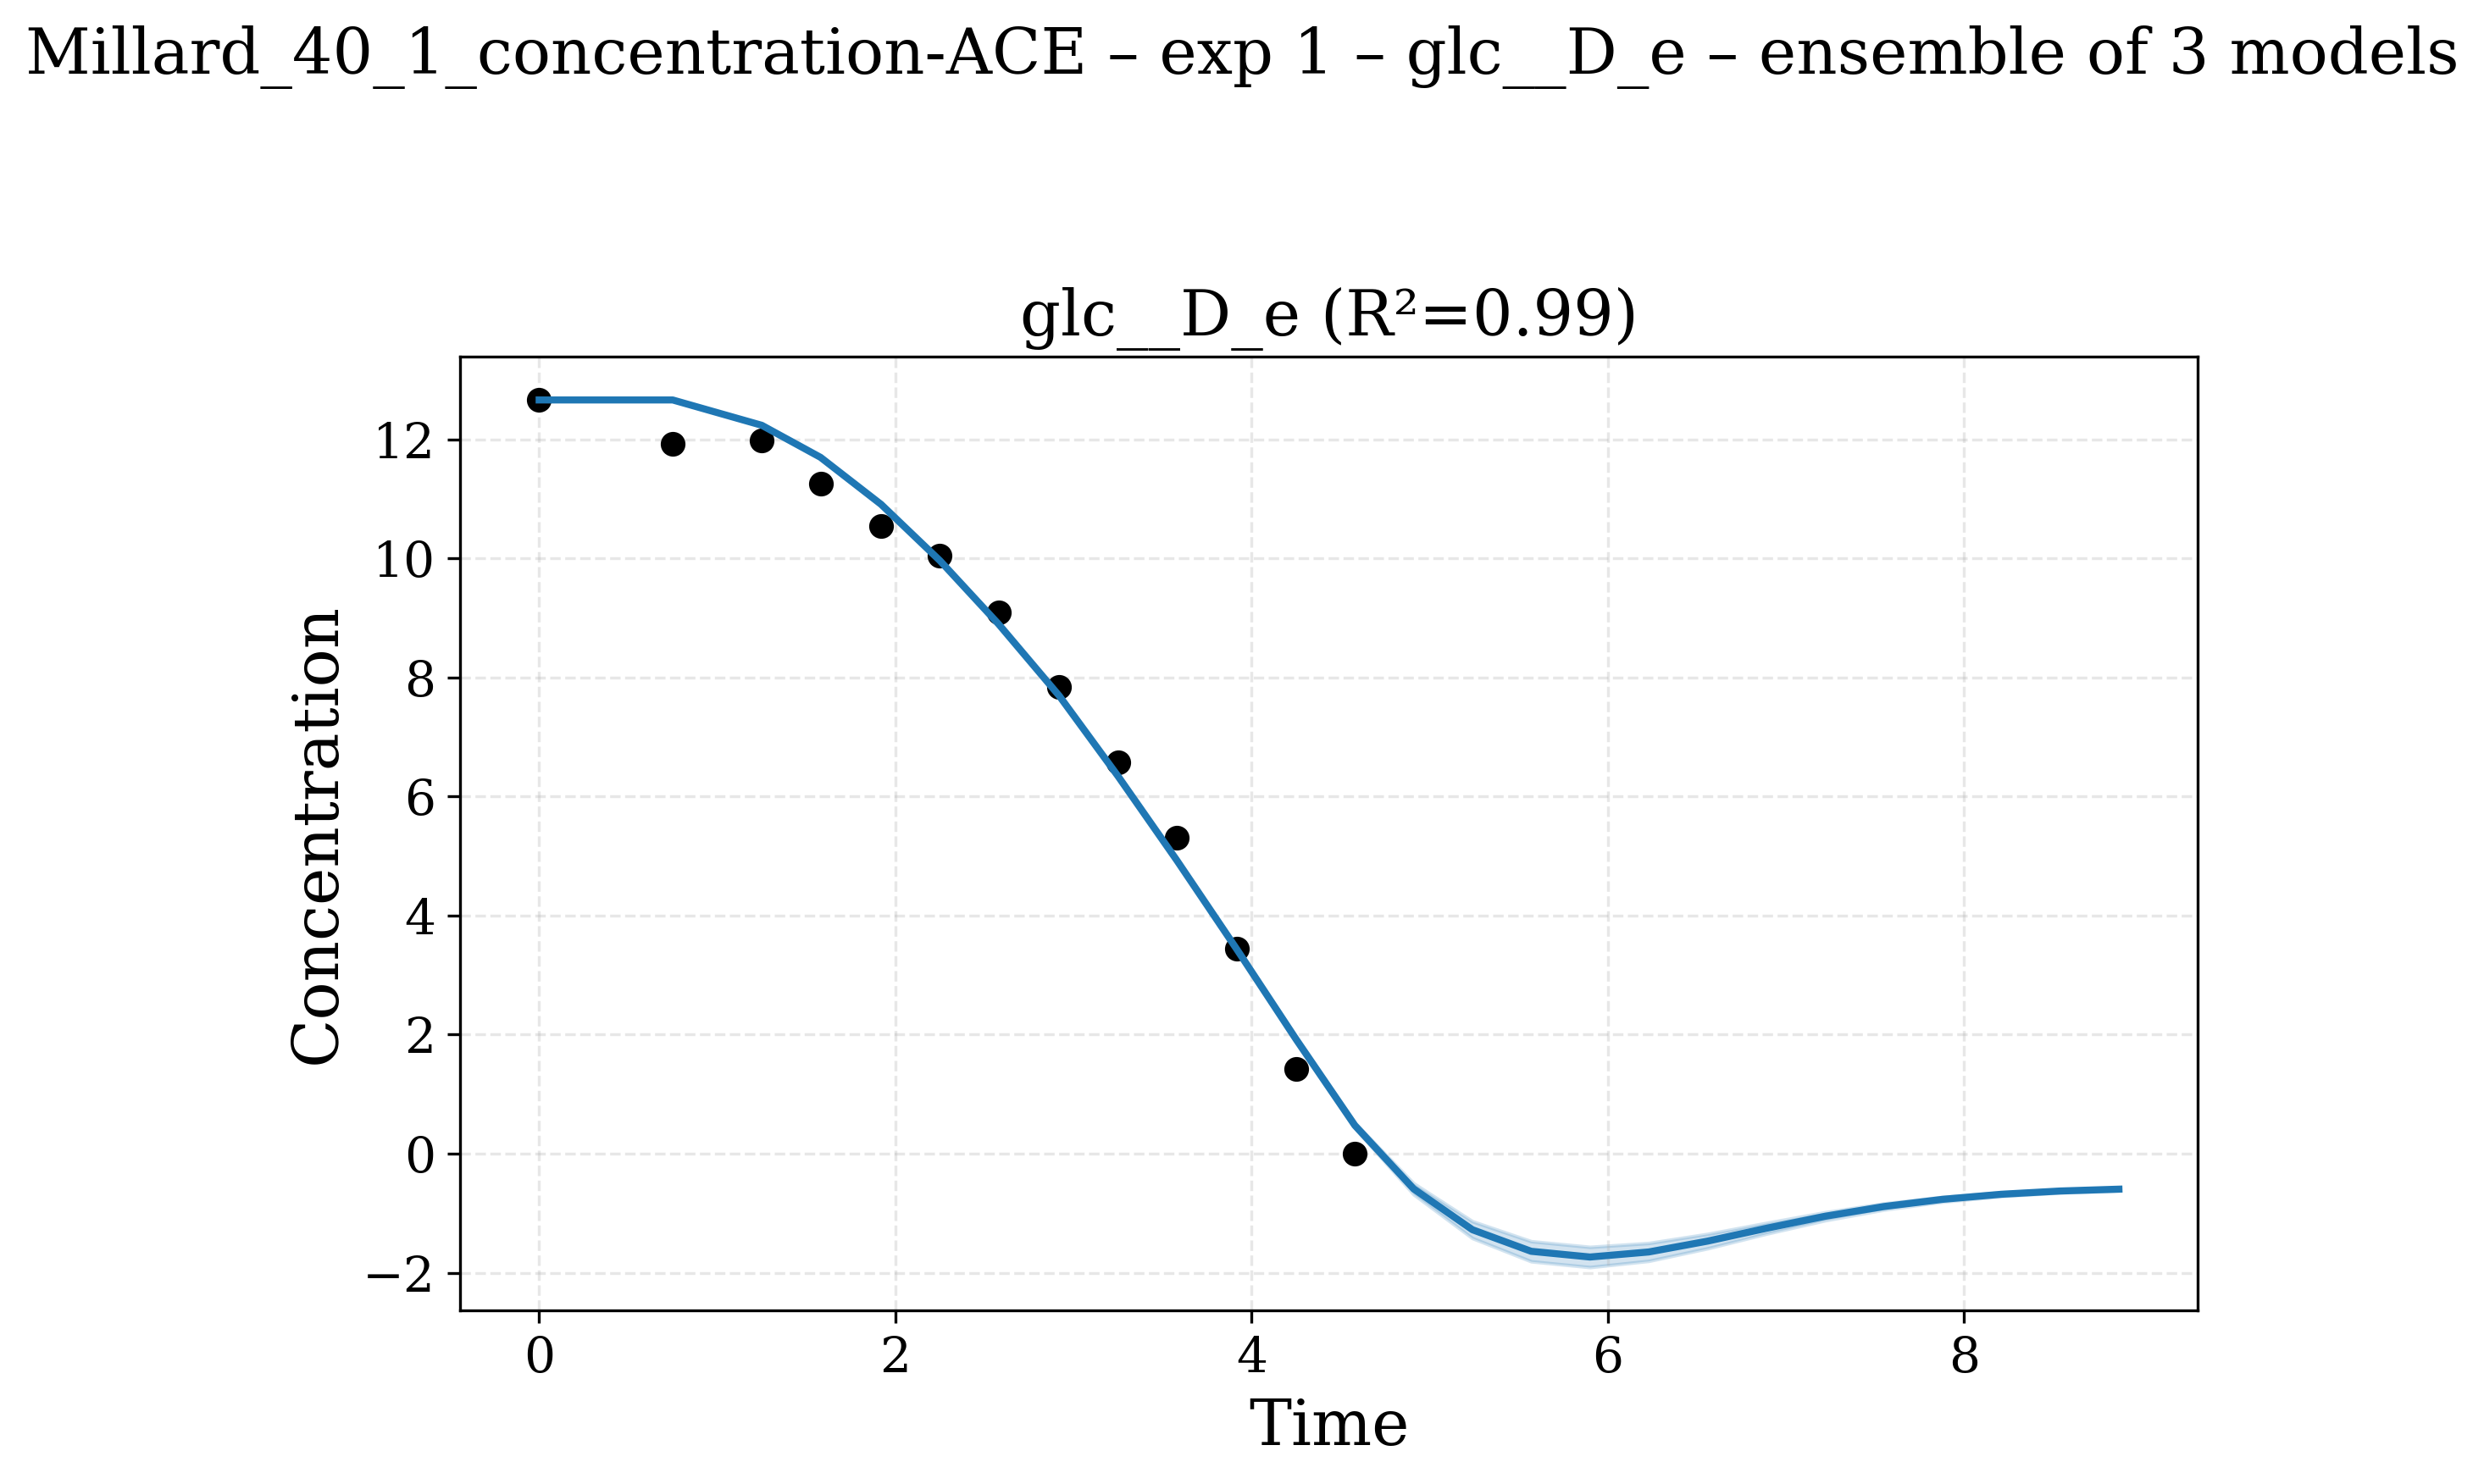

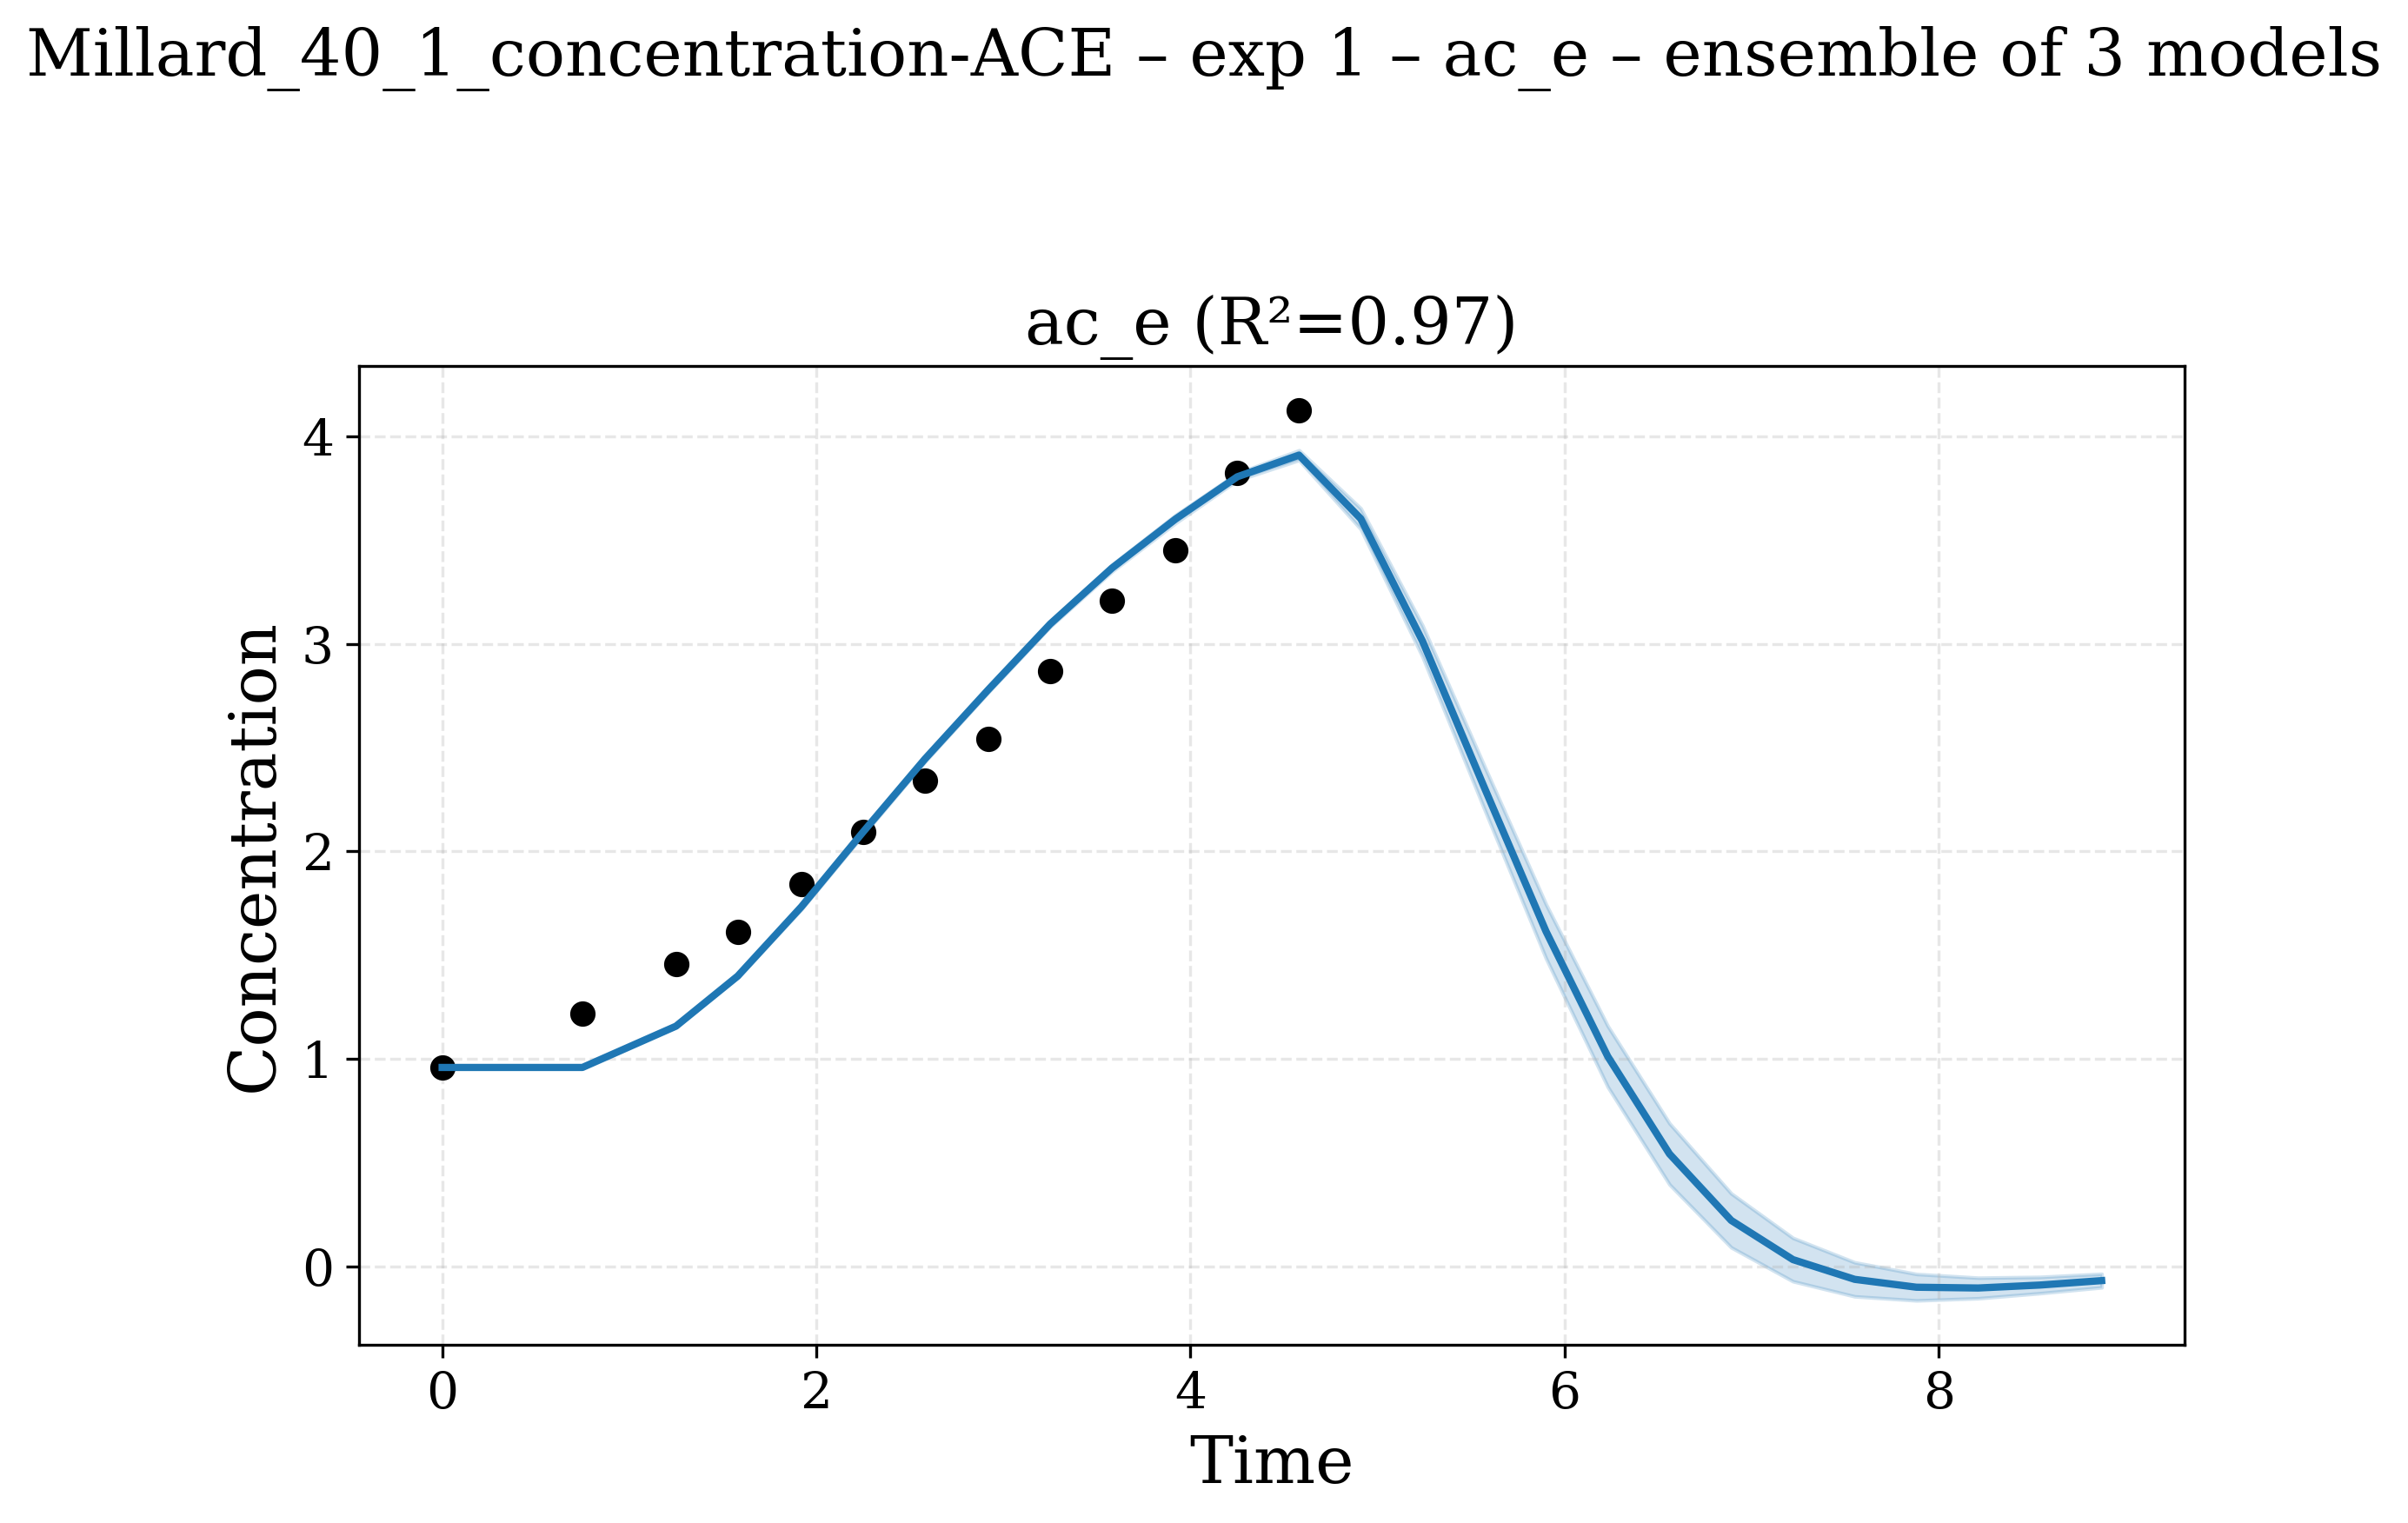

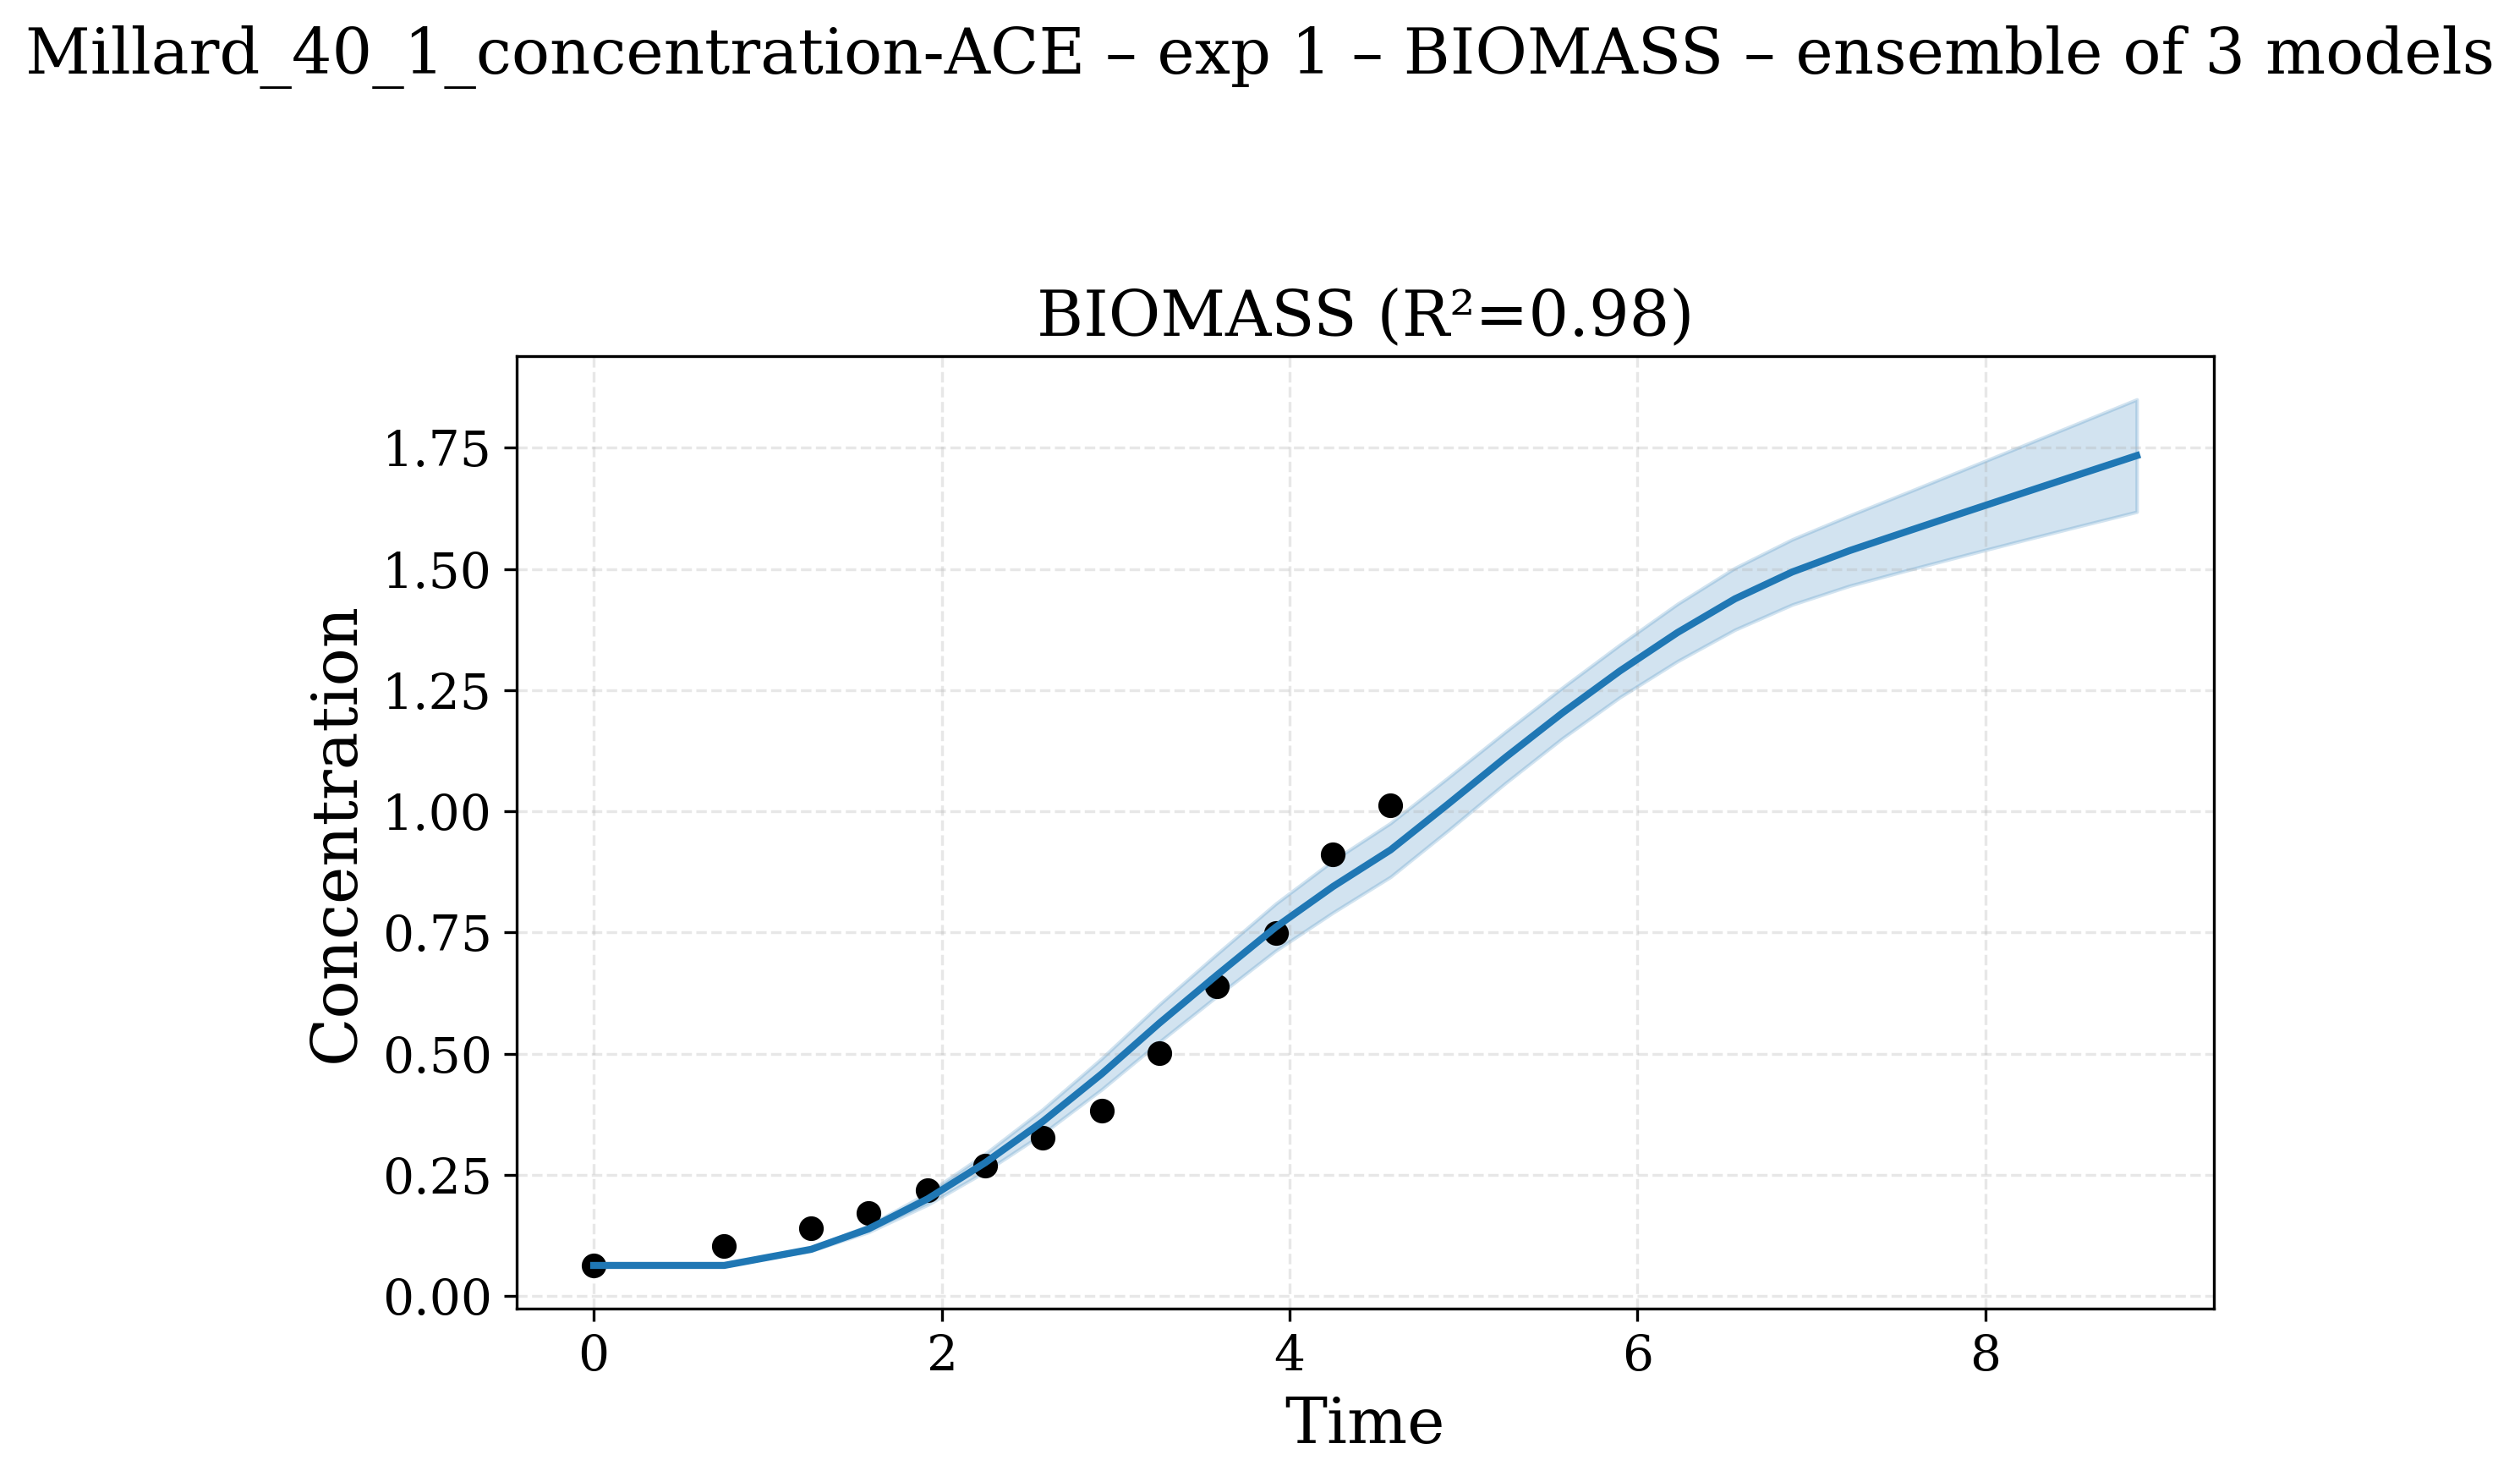

In [1]:
# Forecast glucose acetate switch using glucose and biomass data
# Cell run slow may be pasted in python code

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils
import data
import model
import plot
print('Physical GPUs:', tf.config.list_physical_devices('GPU'))

# -----------------------------
# Config
# -----------------------------
training_mode = 'concentration-ACE' # 'concentration-ACE' or 'concentration-GLC'
train_test_split = data.parse_training_mode(
    mode_str=training_mode,
    default_split="forecast",
    verbose=True
)

folder    = './'
file_name = 'Millard_40_1' # --> data provided for 12 time point but time extend to 40 points

media_file       = folder + 'data/' + 'Millard_media.csv'
od_file          = folder + 'data/' + file_name + '.csv'
cobra_model_file = folder + 'data/' + 'iML1515_duplicated.xml'
biomass_rxn_id   = 'BIOMASS_Ec_iML1515_core_75p37M'

run_name = f'{file_name}_{training_mode}'

# Hyperparameters
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

hidden_layers_lag  = [50]
hidden_layers_flux = [500]
num_epochs = 1000
batch_size = 5
patience   = 100
N_models   = 3     # train on independent models

loss_weight = [0.01, 1, 1, 1] # order: SV, negV, C, dropC
loss_decay  = [0, 0.0, 0.25, 0] # order: SV, negV, C, dropC

# -----------------------------
# 1) Build data + template model
# -----------------------------
template_mdl, train_array, train_dev, val_array, val_dev, val_ids = model.create_model_train_val(
    media_file, od_file,
    cobra_model_file,
    biomass_rxn_id,
    x_fold=1,
    hidden_layers_lag=hidden_layers_lag,
    hidden_layers_flux=hidden_layers_flux,
    dropout_rate=0.2,
    loss_weight=loss_weight,
    loss_decay=loss_decay,
    UB_in=1.5, UB_out=0, # ACE: UB_in=0, UB_out=0.3, GL: UB_in=1.5, UB_out=0
    verbose=True,
    train_test_split=train_test_split
)

metabolite_ids = list(template_mdl.metabolite_ids)
val_ids = np.array(val_ids, ndmin=1)

# -----------------------------
# 2) Train N_models independent models
# -----------------------------
Pred_list = []
Ref_list  = []
mdl = model.reset_model(template_mdl, verbose=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=280,
        decay_rate=0.9,
        staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
(train_losses, val_losses) = model.train_model(
        mdl,
        train_array,
        val_array=val_array,
        optimizer=optimizer,
        num_epochs=num_epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=False,
        train_test_split=train_test_split,
        x_fold=1
)

for m in range(N_models):
    print(f"================ Training Model {m+1}/{N_models} ================")
    (train_losses, val_losses) = model.train_model(
        mdl,
        train_array,
        val_array=val_array,
        optimizer=optimizer,
        num_epochs=num_epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=False,
        train_test_split=train_test_split,
        x_fold=1
    )
    pred, ref = model.predict_on_val_data(mdl, val_array, verbose=False)
    Pred_list.append(np.asarray(pred))  # (Z, T, k)
    Ref_list.append(np.asarray(ref))    # (Z, T, k)

Pred_arr = np.asarray(Pred_list)   # shape (N_models, Z, T, k)
Ref_arr  = np.asarray(Ref_list)    # shape (N_models, Z, T, k)

# Reference should be identical across models => keep the first
Ref = Ref_arr[0]                   # (Z, T, k)

# -----------------------------
# 3) Ensemble mean & std
# -----------------------------
Pred_mean = Pred_arr.mean(axis=0)  # (Z, T, k)
Pred_std  = Pred_arr.std(axis=0)   # (Z, T, k)

# -----------------------------
# 3b) R² for MEAN prediction vs reference
# -----------------------------
# Wrap mean prediction & ref with a fake "iteration" axis: (1, Z, T, k)
Pred_mean_single = Pred_mean[np.newaxis, ...]
Ref_single       = Ref[np.newaxis, ...]

R2_mat = utils.r2_concentrations_all(Pred_mean_single, Ref_single)  # shape (Z, k_met)

print("\nR² (mean prediction vs reference):")
for j, met in enumerate(metabolite_ids):
    vals = R2_mat[:, j]
    print(f"  {met:10s}: mean={np.nanmean(vals):.3f}, std={np.nanstd(vals):.3f}")

R2_flat = R2_mat.reshape(-1)
print(
    f"\nGlobal R² (mean prediction): "
    f"mean={np.nanmean(R2_flat):.3f} ± {np.nanstd(R2_flat):.3f}, "
    f"median={np.nanmedian(R2_flat):.3f}"
)

# -----------------------------
# 4) Plot mean ± std using plot.py helper
# -----------------------------
times = template_mdl.times  # or template_model.times depending on your variable name
plot.plot_ensemble_concentrations(
    times=times,
    Ref=Ref,
    Pred_mean=Pred_mean,
    Pred_std=Pred_std,
    metabolite_ids=metabolite_ids,
    val_ids=val_ids,
    run_name=run_name,
    time_cutoffs=9,   
    N_models=N_models,
    R2_mat=R2_mat,
    save_dir="./figure"
)